## Notebook for applying Data Assimilation on seasonal data (PWP reconstructions)

### Assemble data in the proxy domain using offline (block update) assimilation instead of point-by-point
### Both SST and SAT in D47 domain

Author: **N.J. de Winter** (*n.j.de.winter@vu.nl*)<br>
Assistant Professor Vrije Universiteit Amsterdam

**References used in coding**
- Steiger, N.J., Hakim, G.J., Steig, E.J., Battisti, D.S., Roe, G.H., 2014. Assimilation of Time-Averaged Pseudoproxies for Climate Reconstruction. Journal of Climate 27, 426–441. https://doi.org/10.1175/JCLI-D-12-00693.1
- Hakim, G.J., Emile-Geay, J., Steig, E.J., Noone, D., Anderson, D.M., Tardif, R., Steiger, N., Perkins, W.A., 2016. The last millennium climate reanalysis project: Framework and first results. Journal of Geophysical Research: Atmospheres 121, 6745–6764. https://doi.org/10.1002/2016JD024751
- King, J., Tierney, J., Osman, M., Judd, E.J., Anchukaitis, K.J., 2023. DASH: a MATLAB toolbox for paleoclimate data assimilation. Geoscientific Model Development 16, 5653–5683. https://doi.org/10.5194/gmd-16-5653-2023
- Judd, E.J., Tierney, J.E., Lunt, D.J., Montañez, I.P., Huber, B.T., Wing, S.L., Valdes, P.J., 2024. A 485-million-year history of Earth’s surface temperature. Science 385, eadk3705. https://doi.org/10.1126/science.adk3705
- de Winter, N.J., Tindall, J., Johnson, A.L.A., Goudsmit-Harzevoort, B., Wichern, N., Kaskes, P., Claeys, P., Huygen, F., van Leeuwen, S., Metcalfe, B., Bakker, P., Goolaerts, S., Wesselingh, F., Ziegler, M., 2024. Amplified seasonality in western Europe in a warmer world. Science Advances 10, eadl6717. https://doi.org/10.1126/sciadv.adl6717
- Harwood, A. J. P., Dennis, P. F., Marca, A. D., Pilling, G. M., and Millner, R. S.: The oxygen isotope composition of water masses within the North Sea, Estuarine, Coastal and Shelf Science, 78, 353–359, https://doi.org/10.1016/j.ecss.2007.12.010, 2008.
- Daëron, M. and Vermeesch, P.: Omnivariant generalized least squares regression: Theory, geochronological applications, and making the case for reconciled Δ47 calibrations, Chemical Geology, 121881, https://doi.org/10.1016/j.chemgeo.2023.121881, 2023.

# Load packages

In [1]:
# Load packages
import numpy as np # The 'numpy' package is needed for matrix operations and calculations
import pandas as pd # The 'pandas' package helps us to import and manage data
import math as math # Math package for data cleaning
from scipy import stats # Import scipy.package for confidence intervals
from sklearn.preprocessing import StandardScaler # Import the package for standardizing data
import D47calib as D47c # Import the package for treating clumped isotope data by Daëron and Vermeesch (2023; https://github.com/mdaeron/D47calib)
import matplotlib.pyplot as plt # The 'matplotlib' package contains tools needed to plot our data and results
import seaborn as sns # The 'seaborn' package is used to make our plots look nicer (e.g. enable heatmaps)
import warnings # The 'warnings' package is used to suppress warnings that might occur during the calculations
%matplotlib inline

# PRIOR - MONTHLY
## Load monthly SST model data

In [2]:
# Load model SST data as prior and show data structure
PlioMIP_SST = pd.read_csv('PWP case/PlioMIP_SST.csv') # Load the data for this assignment into Python and in the Jupyter environment.
PlioMIP_SST.head()

,modelname,ja,fb,mr,ar,my,jn,jl,ag,sp,ot,nv,dc
0,CCSM4-UoT,8.33,7.14,7.45,9.67,13.33,18.40,22.50,24.35,22.60,18.74,14.83,10.86
1,CCSM4-Utr,9.96,8.75,8.95,11.03,14.62,19.37,23.50,25.29,23.95,20.76,16.37,12.48
2,COSMOS,7.91,6.68,6.38,7.34,9.53,12.23,14.95,15.94,14.94,13.34,11.49,9.58
3,EC-Earth3.3,9.18,7.62,7.41,9.32,13.58,19.22,24.06,25.27,23.56,20.26,16.05,12.13
4,GISS2.1G,4.87,3.58,3.88,6.75,11.21,15.56,18.68,19.39,17.68,14.47,10.53,7.18


## Load monthly SAT model data

In [3]:
# Load model SAT data as prior and show data structure
PlioMIP_SAT = pd.read_csv('PWP case/PlioMIP_SAT.csv') # Load the data for this assignment into Python and in the Jupyter environment.
PlioMIP_SAT.head()

,modelname,ja,fb,mr,ar,my,jn,jl,ag,sp,ot,nv,dc
0,CCSM4,8.39,8.81,9.63,12.05,15.15,19.61,22.81,22.96,19.02,14.70,11.03,9.13
1,CCSM4-UoT,6.97,7.58,9.96,12.54,16.46,21.92,25.43,24.72,19.69,14.32,9.94,7.02
2,CCSM4-Utr,9.43,9.50,10.88,13.14,16.81,21.09,25.02,24.99,21.79,17.26,12.84,10.15
3,CESM1.2,9.32,9.84,10.56,13.06,16.71,20.91,23.83,23.44,20.11,15.96,12.77,10.38
4,CESM2,10.70,10.44,11.75,13.85,17.69,22.31,25.02,25.18,21.79,17.65,13.99,12.05


## Load monthly SSS model data

In [4]:
# Load model SSS data as prior and show data structure
PlioMIP_SSS = pd.read_csv('PWP case/PlioMIP_SSS.csv')  # Load the data for this assignment into Python and in the Jupyter environment.
PlioMIP_SSS = PlioMIP_SSS.pivot(index='modelname', columns='month', values='SSS').reset_index() # Pivot the data to have months as columns and models as rows
# Rename months to two-letter codes
month_mapping = {
    'Jan': 'ja', 'Feb': 'fb', 'Mar': 'mr', 'Apr': 'ar', 'May': 'my', 
    'Jun': 'jn', 'Jul': 'jl', 'Aug': 'ag', 'Sep': 'sp', 'Oct': 'ot', 
    'Nov': 'nv', 'Dec': 'dc'
}
PlioMIP_SSS.rename(columns=month_mapping, inplace=True) # Rename the columns to two-letter codes for months
PlioMIP_SSS.head()

month,modelname,ar,ag,dc,fb,ja,jl,jn,mr,my,nv,ot,sp
0,CCSM4-UoT,18.641620,17.664583,19.175005,19.155079,19.240961,17.706797,17.993721,18.922827,18.357751,18.862000,18.452913,17.934462
1,COSMOS,19.671519,19.139396,19.822553,19.930394,19.886921,19.228002,19.358863,19.860139,19.468221,19.729077,19.523501,19.264149
2,HadCM3,35.505535,34.605678,35.505248,35.616506,35.583428,34.878770,35.134441,35.604174,35.330172,35.355503,35.068206,34.696112
3,HadGEM3,32.947459,32.489019,32.896642,33.094949,33.066085,32.465359,32.599833,33.040556,32.797878,32.658298,32.534356,32.513514
4,IPSL-CM6A-LR,34.079274,33.265265,34.244052,34.275511,34.315632,33.524891,33.752462,34.183905,33.928167,34.027614,33.766878,33.409809


## Load monthly precipitation data

In [5]:
# Load model precipitation data as prior and show data structure
PlioMIP_precip = pd.read_csv('PWP case/PlioMIP_precip.csv')  # Load the data for this assignment into Python and in the Jupyter environment.
PlioMIP_precip = PlioMIP_precip.pivot(index='modelname', columns='month', values='Mean_Precipitation').reset_index()  # Pivot the data to have months as columns and models as rows
PlioMIP_precip.rename(columns=month_mapping, inplace=True)  # Rename the columns to two-letter codes for months
PlioMIP_precip.head()

month,modelname,ar,ag,dc,fb,ja,jl,jn,mr,my,nv,ot,sp
0,CCSM4,1.481677,1.825992,4.034268,2.957591,3.776682,0.731645,0.996839,1.921807,1.343585,3.962916,3.387227,2.900726
1,CCSM4UOT,1.494104,1.732526,3.068386,2.104363,2.758223,0.965024,1.286421,1.389566,1.473732,3.428390,2.597931,2.323011
2,CCSM4Utr,1.525553,1.702673,3.965647,2.613341,3.236507,1.256546,1.676994,1.656356,1.695042,3.999845,2.977811,2.365357
3,CESM1.2,1.461625,2.224233,3.428275,2.466815,3.199764,0.845094,0.787780,2.065939,1.132148,3.458813,3.049558,2.940248
4,CESM2,1.549717,2.337191,4.229531,2.705796,3.424249,1.708422,1.124801,1.911965,1.448587,4.192045,3.278223,2.665053


### Combine SST, SAT, SSS and precipitation data by modelname

In [6]:
# Normalize model names to lowercase and remove "-" signs
def normalize_modelname(df):
    df['modelname'] = df['modelname'].str.lower().str.replace('-', '', regex=False)
    return df

# Apply normalization to all datasets
PlioMIP_SST = normalize_modelname(PlioMIP_SST)
PlioMIP_SAT = normalize_modelname(PlioMIP_SAT)
PlioMIP_SSS = normalize_modelname(PlioMIP_SSS)
PlioMIP_precip = normalize_modelname(PlioMIP_precip)

# Merge the datasets of SST, SAT, SSS, and precipitation, force suffixes to be added to the column names
PlioMIP = pd.merge(
    PlioMIP_SST.rename(columns={c: c + '_SST' for c in PlioMIP_SST.columns if c != 'modelname'}),
    PlioMIP_SAT.rename(columns={c: c + '_SAT' for c in PlioMIP_SAT.columns if c != 'modelname'}),
    on='modelname',
    how='outer'
)

PlioMIP = pd.merge(
    PlioMIP,
    PlioMIP_SSS.rename(columns={c: c + '_SSS' for c in PlioMIP_SSS.columns if c != 'modelname'}),
    on='modelname',
    how='outer'
)

PlioMIP = pd.merge(
    PlioMIP,
    PlioMIP_precip.rename(columns={c: c + '_precip' for c in PlioMIP_precip.columns if c != 'modelname'}),
    on='modelname',
    how='outer'
)

# Display the combined dataset
PlioMIP.head()

,modelname,ja_SST,fb_SST,mr_SST,ar_SST,my_SST,jn_SST,jl_SST,ag_SST,sp_SST,...,dc_precip,fb_precip,ja_precip,jl_precip,jn_precip,mr_precip,my_precip,nv_precip,ot_precip,sp_precip
0,ccsm4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.034268,2.957591,3.776682,0.731645,0.996839,1.921807,1.343585,3.962916,3.387227,2.900726
1,ccsm4uot,8.33,7.14,7.45,9.67,13.33,18.40,22.5,24.35,22.60,...,3.068386,2.104363,2.758223,0.965024,1.286421,1.389566,1.473732,3.428390,2.597931,2.323011
2,ccsm4utr,9.96,8.75,8.95,11.03,14.62,19.37,23.5,25.29,23.95,...,3.965647,2.613341,3.236507,1.256546,1.676994,1.656356,1.695042,3.999845,2.977811,2.365357
3,cesm1.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.428275,2.466815,3.199764,0.845094,0.787780,2.065939,1.132148,3.458813,3.049558,2.940248
4,cesm2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.229531,2.705796,3.424249,1.708422,1.124801,1.911965,1.448587,4.192045,3.278223,2.665053


## Calculate the monthly prior for model SST, SAT, SSS and precipitation values

In [7]:
# Create list of month names
months = ['ja', 'fb', 'mr', 'ar', 'my', 'jn', 'jl', 'ag', 'sp', 'ot', 'nv', 'dc']

# Prior SST, SAT, SSS & precipitation estimates from climate models (mean)
mu_prior_SAT_monthly = np.array(PlioMIP[[f"{month}_SAT" for month in months]].mean(axis=0, skipna=True))
mu_prior_SST_monthly = np.array(PlioMIP[[f"{month}_SST" for month in months]].mean(axis=0, skipna=True))
mu_prior_SSS_monthly = np.array(PlioMIP[[f"{month}_SSS" for month in months]].mean(axis=0, skipna=True))
mu_prior_precip_monthly = np.array(PlioMIP[[f"{month}_precip" for month in months]].mean(axis=0, skipna=True))

# Covariance between months in prior SST, SAT, SSS, and precip estimates from climate models (covariance matrix)
cov_prior_SAT_monthly = np.cov(PlioMIP[[f"{month}_SAT" for month in months]].dropna(), rowvar=False)
cov_prior_SST_monthly = np.cov(PlioMIP[[f"{month}_SST" for month in months]].dropna(), rowvar=False)
cov_prior_SSS_monthly = np.cov(PlioMIP[[f"{month}_SSS" for month in months]].dropna(), rowvar=False)
cov_prior_precip_monthly = np.cov(PlioMIP[[f"{month}_precip" for month in months]].dropna(), rowvar=False)

# Store copy of original prior means to keep when later updating the prior
mu_prior_SAT_monthly_original, cov_prior_SAT_monthly_original = mu_prior_SAT_monthly.copy(), cov_prior_SAT_monthly.copy()
mu_prior_SST_monthly_original, cov_prior_SST_monthly_original = mu_prior_SST_monthly.copy(), cov_prior_SST_monthly.copy()
mu_prior_SSS_monthly_original, cov_prior_SSS_monthly_original = mu_prior_SSS_monthly.copy(), cov_prior_SSS_monthly.copy()
mu_prior_precip_monthly_original, cov_prior_precip_monthly_original = mu_prior_precip_monthly.copy(), cov_prior_precip_monthly.copy()

# Extract the standard deviations (uncertainty) from the covariance matrix
std_prior_SAT_monthly = np.sqrt(np.diag(cov_prior_SAT_monthly))
std_prior_SST_monthly = np.sqrt(np.diag(cov_prior_SST_monthly))
std_prior_SSS_monthly = np.sqrt(np.diag(cov_prior_SSS_monthly))
std_prior_precip_monthly = np.sqrt(np.diag(cov_prior_precip_monthly))

print("SAT Monthly Means:", mu_prior_SAT_monthly)
print("SAT Monthly Std Devs:", std_prior_SAT_monthly)
print("SST Monthly Means:", mu_prior_SST_monthly)
print("SST Monthly Std Devs:", std_prior_SST_monthly)
print("SSS Monthly Means:", mu_prior_SSS_monthly)
print("SSS Monthly Std Devs:", std_prior_SSS_monthly)
print("Precip Monthly Means:", mu_prior_precip_monthly)
print("Precip Monthly Std Devs:", std_prior_precip_monthly)

SAT Monthly Means: [ 6.71411765  6.69294118  8.04647059 10.80058824 14.58529412 19.27941176
 22.28411765 21.87705882 18.43058824 14.13235294 10.31941176  7.91294118]
SAT Monthly Std Devs: [2.19619574 2.33777342 2.13652153 1.88298457 1.96586214 2.24523793
 2.7378734  2.89253514 2.75413206 2.61063098 2.36348384 2.20706469]
SST Monthly Means: [ 8.89909091  7.84181818  7.89181818  9.60909091 12.97272727 17.37909091
 21.1        22.14727273 20.38636364 17.25272727 13.83181818 10.91818182]
SST Monthly Std Devs: [1.66519341 1.70563078 1.62979028 1.41943971 1.74026487 2.5002778
 3.07210677 3.32125606 3.31004916 2.94745684 2.34808781 1.8649387 ]
SSS Monthly Means: [29.29601903 29.27455803 29.08572385 28.76846642 28.43459126 28.18546307
 28.01587662 27.98742991 28.17716438 28.56415277 28.93190974 29.18675145]
SSS Monthly Std Devs: [5.92900181 5.93098095 5.9695257  6.03338574 6.09152224 6.17221843
 6.2365113  6.23680216 6.19993142 6.09896377 6.00078604 5.9423462 ]
Precip Monthly Means: [3.3589960

## Plot the monthly priors for all model values

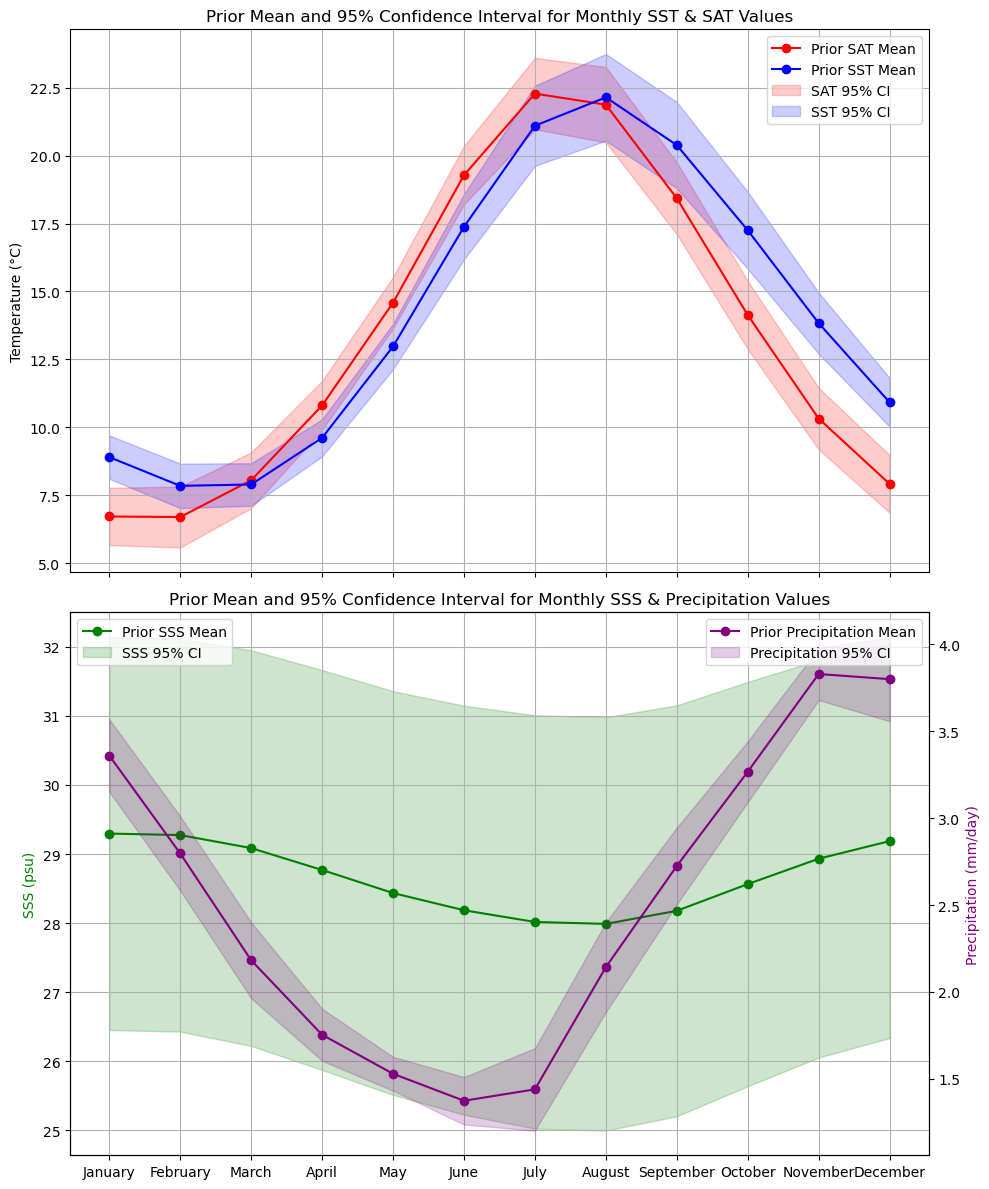

In [8]:
# Set dimensions of data
n_models_monthly = len(PlioMIP["modelname"])  # Find the total number of models (use monthly data because monthly data has this column duplicated 3 times)

# Create a monthly scale for the x-axis
month_names = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']  # List full month names
months_scale = np.arange(len(months)) + 1  # Create monthly scale

# Create the figure and axes
fig, axes = plt.subplots(2, 1, figsize=(10, 12), sharex=True)

# Panel 1: Plot the prior distribution for SST and SAT
axes[0].plot(months_scale, mu_prior_SAT_monthly, label='Prior SAT Mean', marker='o', color='r')
axes[0].plot(months_scale, mu_prior_SST_monthly, label='Prior SST Mean', marker='o', color='b')

# Add 95% confidence intervals for SAT
axes[0].fill_between(
    months_scale,
    mu_prior_SAT_monthly - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SAT_monthly / np.sqrt(n_models_monthly),
    mu_prior_SAT_monthly + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SAT_monthly / np.sqrt(n_models_monthly),
    alpha=0.2, color='r', label='SAT 95% CI'
)

# Add 95% confidence intervals for SST
axes[0].fill_between(
    months_scale,
    mu_prior_SST_monthly - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SST_monthly / np.sqrt(n_models_monthly),
    mu_prior_SST_monthly + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SST_monthly / np.sqrt(n_models_monthly),
    alpha=0.2, color='b', label='SST 95% CI'
)

axes[0].set_title('Prior Mean and 95% Confidence Interval for Monthly SST & SAT Values')
axes[0].set_ylabel('Temperature (°C)')
axes[0].legend()
axes[0].grid(True)

# Panel 2: Plot the prior distribution for SSS and precipitation
axes[1].plot(months_scale, mu_prior_SSS_monthly, label='Prior SSS Mean', marker='o', color='g')
ax2 = axes[1].twinx()  # Create a secondary y-axis for precipitation
ax2.plot(months_scale, mu_prior_precip_monthly, label='Prior Precipitation Mean', marker='o', color='purple')

# Add 95% confidence intervals for SSS
axes[1].fill_between(
    months_scale,
    mu_prior_SSS_monthly - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SSS_monthly / np.sqrt(n_models_monthly),
    mu_prior_SSS_monthly + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SSS_monthly / np.sqrt(n_models_monthly),
    alpha=0.2, color='g', label='SSS 95% CI'
)

# Add 95% confidence intervals for precipitation
ax2.fill_between(
    months_scale,
    mu_prior_precip_monthly - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_precip_monthly / np.sqrt(n_models_monthly),
    mu_prior_precip_monthly + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_precip_monthly / np.sqrt(n_models_monthly),
    alpha=0.2, color='purple', label='Precipitation 95% CI'
)

axes[1].set_ylabel('SSS (psu)', color='g')
ax2.set_ylabel('Precipitation (mm/day)', color='purple')
axes[1].set_title('Prior Mean and 95% Confidence Interval for Monthly SSS & Precipitation Values')
axes[1].legend(loc='upper left')
ax2.legend(loc='upper right')
axes[1].grid(True)

# Update the x-axis with month names
plt.xticks(months_scale, month_names, rotation=45, ha="right")
plt.xlabel('Month')
plt.tight_layout()
plt.show()

### Convert SST model data to D47 domain using the regression by Daëron and Vermeesch (2023) and propagate uncertainty in the calibration

In [9]:
# Apply T47()-function from the D47calib package to all SST columns
# Identify the SST and SAT columns separately
SST_columns = [col for col in PlioMIP.columns if col.endswith('_SST')]
SAT_columns = [col for col in PlioMIP.columns if col.endswith('_SAT')]

# Apply the conversion function to the SST and SAT columns and add new columns for D47 and D47_SE
for col in SST_columns:
    base_col_name = col.replace('_SST', '') # Remove the '_SST' suffix from the column name
    PlioMIP[f'{base_col_name}_SST_D47'], PlioMIP[f'{base_col_name}_SST_D47_SE'] = zip(*PlioMIP[col].apply(
        lambda x: D47c.OGLS23.T47(T = x) if not pd.isna(x) else (np.nan, np.nan)
    )) # Use zip() to unpack the tuple returned by the apply() method and apply the T47()-function to each value in the column
for col in SAT_columns:
    base_col_name = col.replace('_SAT', '') # Remove the '_SST' suffix from the column name
    PlioMIP[f'{base_col_name}_SAT_D47'], PlioMIP[f'{base_col_name}_SAT_D47_SE'] = zip(*PlioMIP[col].apply(
        lambda x: D47c.OGLS23.T47(T = x) if not pd.isna(x) else (np.nan, np.nan)
    )) # Use zip() to unpack the tuple returned by the apply() method and apply the T47()-function to each value in the column

# Display the combined data with D47 and D47_SE columns
D47_columns = [col for col in PlioMIP.columns if col.endswith('_D47')]
D47_se_columns = [col for col in PlioMIP.columns if '_D47_SE' in col]
print("D47 values for all model outcomes:\n", PlioMIP[D47_columns].head())
print("Calibration standard errors for all model outcomes:\n", PlioMIP[D47_se_columns].head())

D47 values for all model outcomes:
    ja_SST_D47  fb_SST_D47  mr_SST_D47  ar_SST_D47  my_SST_D47  jn_SST_D47  \
0         NaN         NaN         NaN         NaN         NaN         NaN   
1    0.648316    0.652623    0.651496    0.643531    0.630811    0.613992   
2    0.642505    0.646808    0.646093    0.638746    0.626446    0.610876   
3         NaN         NaN         NaN         NaN         NaN         NaN   
4         NaN         NaN         NaN         NaN         NaN         NaN   

   jl_SST_D47  ag_SST_D47  sp_SST_D47  ot_SST_D47  ...  mr_SAT_D47  \
0         NaN         NaN         NaN         NaN  ...    0.643673   
1    0.601033    0.595364    0.600724    0.612897  ...    0.642505   
2    0.597955    0.592525    0.596581    0.606465  ...    0.639270   
3         NaN         NaN         NaN         NaN  ...    0.640392   
4         NaN         NaN         NaN         NaN  ...    0.636241   

   ar_SAT_D47  my_SAT_D47  jn_SAT_D47  jl_SAT_D47  ag_SAT_D47  sp_SAT_D47  \
0  

### Estimate seawater oxygen isotope value from salinity based on modern North Sea d18Ow-salinity relationship by Harwood et al. (2007)

In [10]:
# Apply the d18Ow-SSS function from Harwood et al. (2007) to all SSS columns
# Identify the SSS columns
SSS_columns = [col for col in PlioMIP.columns if col.endswith('_SSS')]

# Apply the conversion function to the SSS columns and add new columns for d18Ow and d18Ow_SE
for col in SSS_columns:
    base_col_name = col.replace('_SSS', '')  # Remove the '_SSS' suffix from the column name
    PlioMIP[f'{base_col_name}_SSS_d18Ow'] = PlioMIP[col].apply(
        lambda x: -9.300 + 0.274 * x if not pd.isna(x) else np.nan  # Calculate d18Ow
    )

# Display the combined data with d18Ow and d18Ow_SE columns
d18Ow_columns = [col for col in PlioMIP.columns if col.endswith('_d18Ow')]
print("d18Ow values for all model outcomes:\n", PlioMIP[d18Ow_columns].head())

d18Ow values for all model outcomes:
    ar_SSS_d18Ow  ag_SSS_d18Ow  dc_SSS_d18Ow  fb_SSS_d18Ow  ja_SSS_d18Ow  \
0           NaN           NaN           NaN           NaN           NaN   
1     -4.192196     -4.459904     -4.046049     -4.051508     -4.027977   
2           NaN           NaN           NaN           NaN           NaN   
3           NaN           NaN           NaN           NaN           NaN   
4           NaN           NaN           NaN           NaN           NaN   

   jl_SSS_d18Ow  jn_SSS_d18Ow  mr_SSS_d18Ow  my_SSS_d18Ow  nv_SSS_d18Ow  \
0           NaN           NaN           NaN           NaN           NaN   
1     -4.448338      -4.36972     -4.115145     -4.269976     -4.131812   
2           NaN           NaN           NaN           NaN           NaN   
3           NaN           NaN           NaN           NaN           NaN   
4           NaN           NaN           NaN           NaN           NaN   

   ot_SSS_d18Ow  sp_SSS_d18Ow  
0           NaN           Na

## Calculate the monthly prior for model SST- and SAT-derived D47 values and SSS-derived seawater oxygen isotope values with propagated uncertainty

In [11]:
# Set the weights of the data based on the standard errors
weights_monthly_SST_D47 = 1 / PlioMIP[[f"{month}_SST_D47_SE" for month in months]] ** 2
weights_monthly_SAT_D47 = 1 / PlioMIP[[f"{month}_SAT_D47_SE" for month in months]] ** 2

# Change the column suffixes from "_D47_SE" to "_D47" in weights_monthly_SST_D47 to match the headers of the D47 matrix later for multiplication
weights_monthly_SST_D47.columns = [col.replace('_SST_D47_SE', '_SST_D47') for col in weights_monthly_SST_D47.columns]
weights_monthly_SAT_D47.columns = [col.replace('_SAT_D47_SE', '_SAT_D47') for col in weights_monthly_SAT_D47.columns]

# Prior D47 estimates from climate models (weighted mean)
mu_prior_SST_D47_monthly = np.array((PlioMIP[[f"{month}_SST_D47" for month in months]] * weights_monthly_SST_D47).sum(axis = 0, skipna = True) / weights_monthly_SST_D47.sum(axis = 0, skipna = True)) # Calculate weighted monthly mean D47 values and convert to numpy array
mu_prior_SAT_D47_monthly = np.array((PlioMIP[[f"{month}_SAT_D47" for month in months]] * weights_monthly_SAT_D47).sum(axis = 0, skipna = True) / weights_monthly_SAT_D47.sum(axis = 0, skipna = True)) # Calculate weighted monthly mean D47 values and convert to numpy array

# Calculate simple (unweighted) mean for monthly d18Ow values
mu_prior_SSS_d18Ow_monthly = np.array(PlioMIP[[f"{month}_SSS_d18Ow" for month in months]].mean(axis=0, skipna=True))

# Decompose variance within and between model outcomes
model_variances_SST = PlioMIP[[f"{month}_SST_D47" for month in months]].var(axis = 0, ddof = 1)  # Compute variance across models
model_variances_SAT = PlioMIP[[f"{month}_SAT_D47" for month in months]].var(axis = 0, ddof = 1)  # Compute variance across models
model_variances_d18Ow = PlioMIP[[f"{month}_SSS_d18Ow" for month in months]].var(axis = 0, ddof = 1)  # Compute variance across models
measurement_variances_SST = (PlioMIP[[f"{month}_SST_D47_SE" for month in months]] ** 2).mean(axis = 0, skipna = True)  # Compute variance on measurements
measurement_variances_SAT = (PlioMIP[[f"{month}_SAT_D47_SE" for month in months]] ** 2).mean(axis = 0, skipna = True)  # Compute variance on measurements

# Covariance between months in prior D47 estimates from climate models (weighted covariance matrix)
cov_raw_monthly_SST = np.cov(PlioMIP[[f"{month}_SST_D47" for month in months]].dropna(), rowvar = False)  # Compute the covariance matrix for the raw data (without measurement uncertainty)
cov_raw_monthly_SAT = np.cov(PlioMIP[[f"{month}_SAT_D47" for month in months]].dropna(), rowvar = False)  # Compute the covariance matrix for the raw data (without measurement uncertainty)
cov_raw_monthly_d18Ow = np.cov(PlioMIP[[f"{month}_SSS_d18Ow" for month in months]].dropna(), rowvar = False)  # Compute the covariance matrix for the raw data (without measurement uncertainty)
cov_prior_SST_D47_monthly = cov_raw_monthly_SST.copy() # Copy covariance matrix to add uncertainty coming from the measurements
cov_prior_SAT_D47_monthly = cov_raw_monthly_SAT.copy() # Copy covariance matrix to add uncertainty coming from the measurements
np.fill_diagonal(cov_prior_SST_D47_monthly, np.diagonal(cov_raw_monthly_SST) + measurement_variances_SST)  # Add diagonal terms for measurement uncertainties (which have no covariance between models)
np.fill_diagonal(cov_prior_SAT_D47_monthly, np.diagonal(cov_raw_monthly_SAT) + measurement_variances_SAT)  # Add diagonal terms for measurement uncertainties (which have no covariance between models)

# Store copy of original prior means to keep when later updating the prior
mu_prior_SST_D47_monthly_original, cov_prior_SST_D47_monthly_original = mu_prior_SST_D47_monthly.copy(), cov_prior_SST_D47_monthly.copy()
mu_prior_SAT_D47_monthly_original, cov_prior_SAT_D47_monthly_original = mu_prior_SAT_D47_monthly.copy(), cov_prior_SAT_D47_monthly.copy()
mu_prior_SSS_d18Ow_monthly_original, cov_prior_SSS_d18Ow_monthly_original = mu_prior_SSS_d18Ow_monthly.copy(), cov_raw_monthly_d18Ow.copy()

# Extract the standard deviations (uncertainty) from the covariance matrix
std_prior_SST_D47_monthly = np.sqrt(np.diag(cov_prior_SST_D47_monthly))
std_prior_SAT_D47_monthly = np.sqrt(np.diag(cov_prior_SAT_D47_monthly))
std_prior_SSS_d18Ow_monthly = np.sqrt(np.diag(cov_raw_monthly_d18Ow))

print(mu_prior_SST_D47_monthly)
print(mu_prior_SAT_D47_monthly)
print(std_prior_SST_D47_monthly)
print(std_prior_SAT_D47_monthly)
print(mu_prior_SSS_d18Ow_monthly)
print(std_prior_SSS_d18Ow_monthly)

[0.64595815 0.64972969 0.64957918 0.64352257 0.63174847 0.61687649
 0.60495042 0.60168179 0.60710259 0.61713861 0.62862875 0.63877671]
[0.6535531  0.65354873 0.64877444 0.63916405 0.62623172 0.61087967
 0.6014159  0.6026324  0.61343328 0.62749031 0.64061857 0.64921573]
[0.00614572 0.00638619 0.00611021 0.00523351 0.00611762 0.0083541
 0.00986818 0.01053415 0.01065771 0.00977107 0.00805759 0.00665147]
[0.0081692  0.00869841 0.00782808 0.00672115 0.00673335 0.00732744
 0.0086457  0.0091529  0.00900611 0.00891738 0.00842026 0.00808888]
[-1.27289079 -1.2787711  -1.33051166 -1.4174402  -1.50892199 -1.57718312
 -1.62364981 -1.6314442  -1.57945696 -1.47342214 -1.37265673 -1.3028301 ]
[1.6245465  1.62508878 1.63565004 1.65314769 1.66907709 1.69118785
 1.7088041  1.70888379 1.69878121 1.67111607 1.64421538 1.62820286]


## Plot the monthly prior for model SST- and SAT-derived D47 values and model SSS-derived seawater d18O values with propagated uncertainty

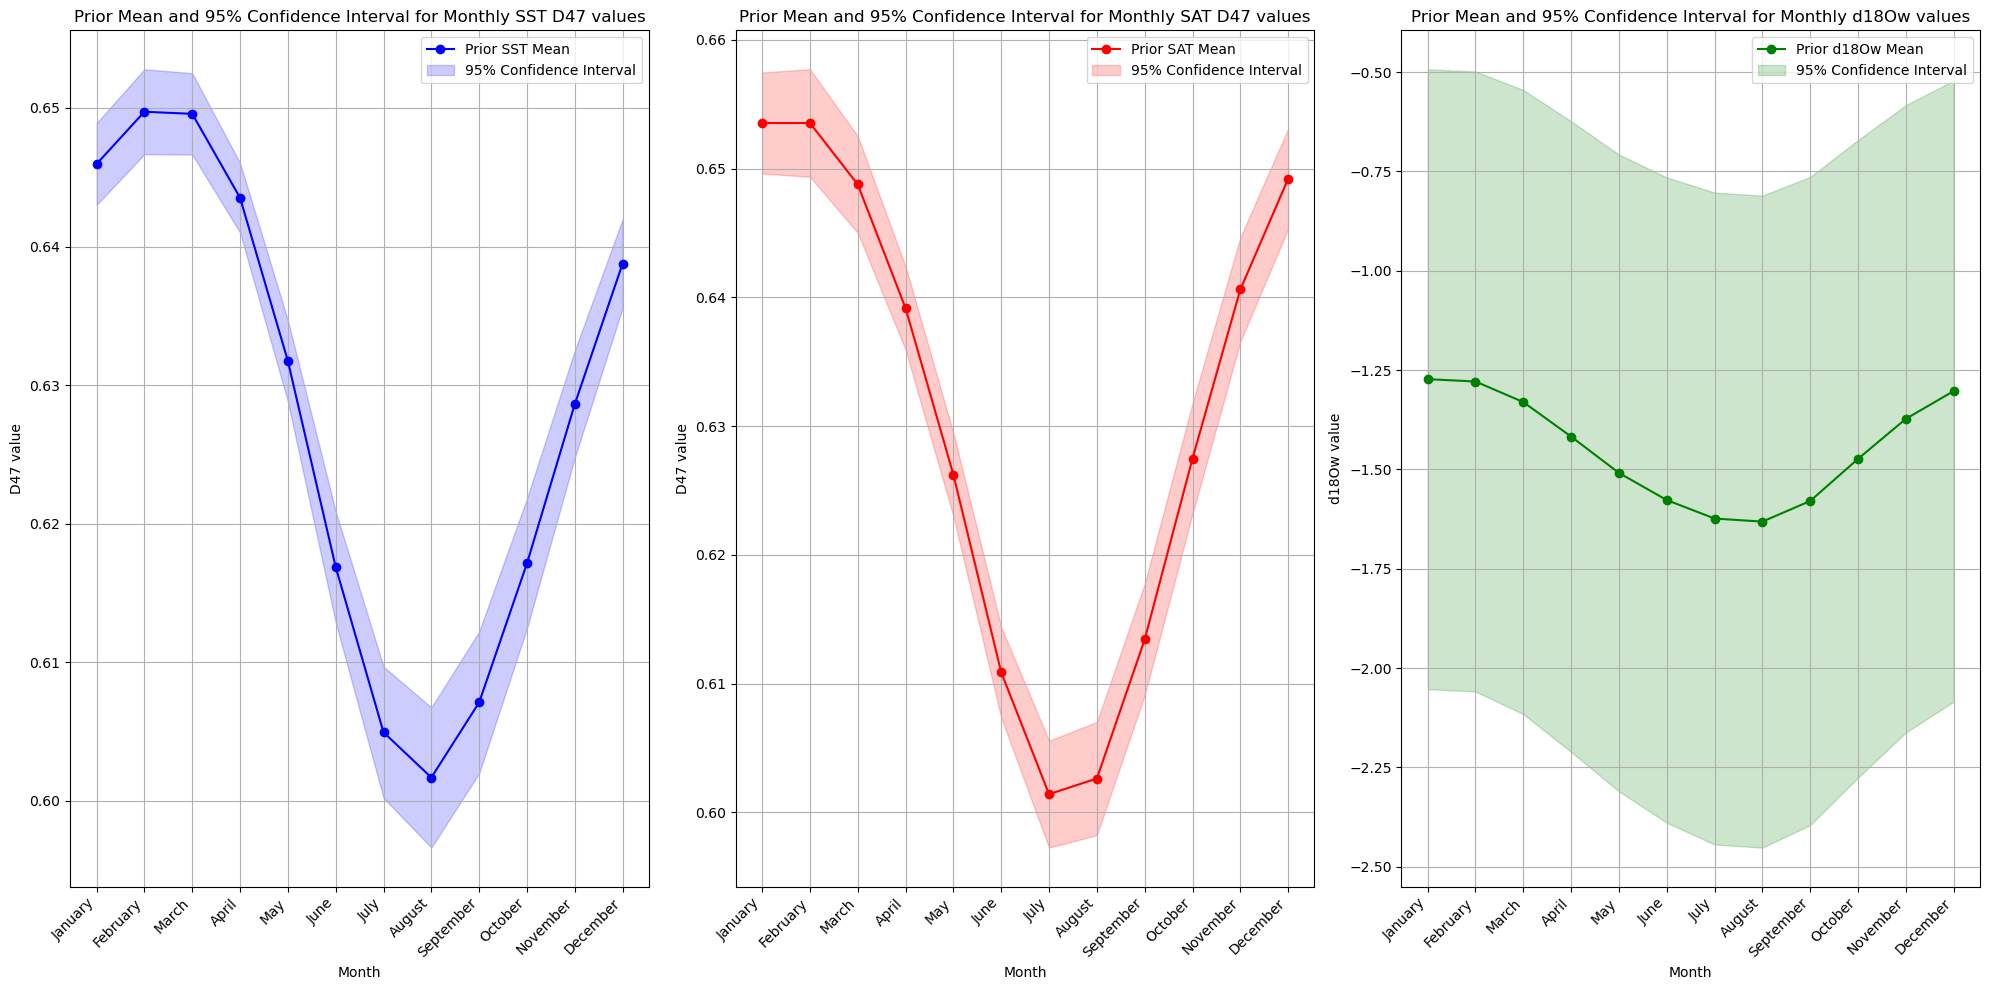

In [14]:
# Plot monthly prior distribution
fig, axes = plt.subplots(1, 3, figsize=(20, 10))  # Adjust the figure to have 3 panels

# Plot the prior distribution for SST
axes[0].plot(months_scale, mu_prior_SST_D47_monthly, label='Prior SST Mean', color='b', marker='o')
axes[0].fill_between(months_scale,
                     mu_prior_SST_D47_monthly - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SST_D47_monthly / np.sqrt(n_models_monthly),
                     mu_prior_SST_D47_monthly + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SST_D47_monthly / np.sqrt(n_models_monthly),
                     color='b', alpha=0.2, label='95% Confidence Interval')
axes[0].set_xticks(months_scale)
axes[0].set_xticklabels(month_names, rotation=45, ha="right")
axes[0].set_title('Prior Mean and 95% Confidence Interval for Monthly SST D47 values')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('D47 value')
axes[0].legend()
axes[0].grid(True)

# Plot the prior distribution for SAT
axes[1].plot(months_scale, mu_prior_SAT_D47_monthly, label='Prior SAT Mean', color='r', marker='o')
axes[1].fill_between(months_scale,
                     mu_prior_SAT_D47_monthly - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SAT_D47_monthly / np.sqrt(n_models_monthly),
                     mu_prior_SAT_D47_monthly + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SAT_D47_monthly / np.sqrt(n_models_monthly),
                     color='r', alpha=0.2, label='95% Confidence Interval')
axes[1].set_xticks(months_scale)
axes[1].set_xticklabels(month_names, rotation=45, ha="right")
axes[1].set_title('Prior Mean and 95% Confidence Interval for Monthly SAT D47 values')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('D47 value')
axes[1].legend()
axes[1].grid(True)

# Plot the prior distribution for d18Ow
axes[2].plot(months_scale, mu_prior_SSS_d18Ow_monthly, label='Prior d18Ow Mean', color='g', marker='o')
axes[2].fill_between(months_scale,
                     mu_prior_SSS_d18Ow_monthly - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SSS_d18Ow_monthly / np.sqrt(n_models_monthly),
                     mu_prior_SSS_d18Ow_monthly + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SSS_d18Ow_monthly / np.sqrt(n_models_monthly),
                     color='g', alpha=0.2, label='95% Confidence Interval')
axes[2].set_xticks(months_scale)
axes[2].set_xticklabels(month_names, rotation=45, ha="right")
axes[2].set_title('Prior Mean and 95% Confidence Interval for Monthly d18Ow values')
axes[2].set_xlabel('Month')
axes[2].set_ylabel('d18Ow value')
axes[2].legend()
axes[2].grid(True)

# Update the layout and show the plot
plt.tight_layout()
plt.show()

## Calculate the monthly covariance matrix for D47 values of SST and SAT

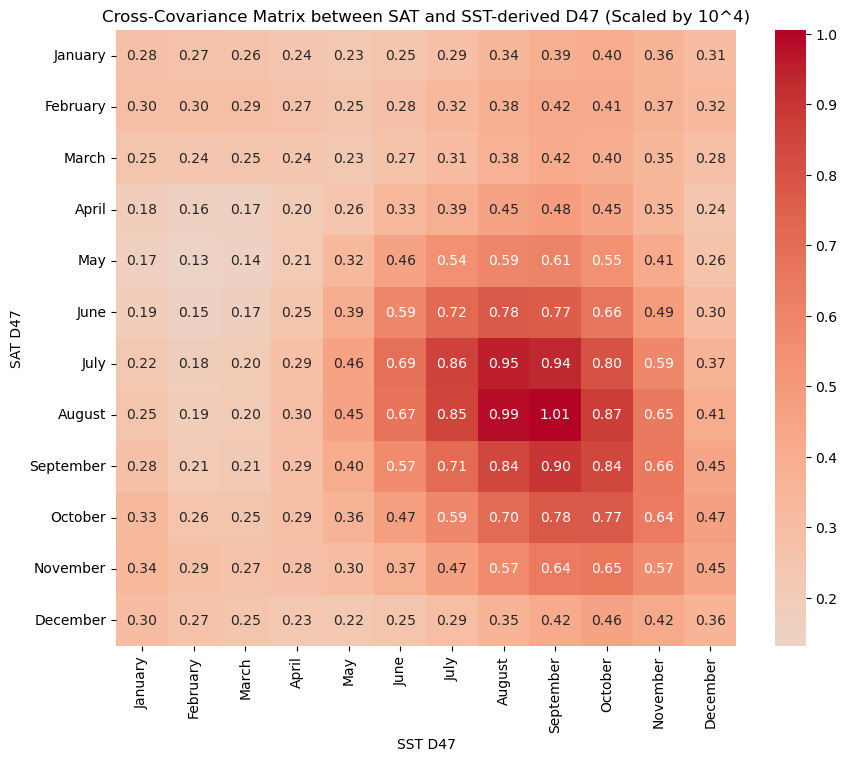

In [15]:
# Extract the relevant columns for SAT and SST D47
SAT_D47_columns_monthly = [f"{month}_SAT_D47" for month in months]
SST_D47_columns_monthly = [f"{month}_SST_D47" for month in months]

# Combine the relevant columns into a single dataframe
combined_data_monthly_D47 = PlioMIP[SAT_D47_columns_monthly + SST_D47_columns_monthly]

# Calculate the covariance matrix for the combined data
cov_combined_monthly_D47 = np.cov(combined_data_monthly_D47.dropna(), rowvar = False)

# Extract the covariance matrices for SAT and SST D47
cov_SAT_D47_monthly = cov_combined_monthly_D47[:len(months), :len(months)]
cov_SST_D47_monthly = cov_combined_monthly_D47[len(months):, len(months):]

# Extract the cross-covariance matrix
cross_cov_SAT_SST_D47_monthly = cov_combined_monthly_D47[:len(months), len(months):]

# Plot a heatmap of the cross-covariance matrix
plt.figure(figsize = (10, 8))
sns.heatmap(
    cross_cov_SAT_SST_D47_monthly * 10 ** 4, # Scale by 10^4 for better visualization
    annot = True,
    fmt = ".2f",
    cmap = "coolwarm",
    center = 0,
    xticklabels = month_names,
    yticklabels = month_names
)
plt.title("Cross-Covariance Matrix between SAT and SST-derived D47 (Scaled by 10^4)")
plt.xlabel("SST D47")
plt.ylabel("SAT D47")
plt.show()

## Create combined monthly state vector in D47 domain

In [ ]:
# Combine the prior means of D47 and SAT into a single state vector
mu_prior_monthly_combined = np.concatenate((mu_prior_SST_D47_monthly, mu_prior_SAT_D47_monthly))

# Combine the covariance matrices of D47 values of SST and SAT, including the cross-covariance
cov_prior_monthly_combined = np.block([
    [cov_prior_SST_D47_monthly, cross_cov_SAT_SST_D47_monthly],
    [cross_cov_SAT_SST_D47_monthly.T, cov_prior_SAT_D47_monthly]
])

# Plot a heatmap of the combined covariance matrix
plt.figure(figsize = (10, 8))
sns.heatmap(
    np.round(cov_prior_monthly_combined * 10 ** 4, 1), # Scale by 10^4 for better visualization and round values
    annot = True,
    fmt = ".1f",
    cmap = "coolwarm",
    center = 0,
    xticklabels = month_names + month_names,
    yticklabels = month_names + month_names
)
plt.title("Combined Covariance Matrix between SAT and SST in D47 units (Scaled by 10^4)")
plt.show()

# PRIOR - SEASONAL

## Seasonal model data (convert the PlioMIP data to seasonal means)

In [ ]:
# Define the seasons
seasons = {
    "winter": ["dc", "ja", "fb"],
    "spring": ["mr", "ar", "my"],
    "summer": ["jn", "jl", "ag"],
    "autumn": ["sp", "ot", "nv"],
}

# Stack monthly columns to create a seasonal dataframes
# Initialize dictionaries to store seasonal data
PlioMIP_seasonal_dict = {}

# Identify the columns to process (all except the modelname column)
columns_to_process = [col for col in PlioMIP.columns if any(suffix in col for suffix in ['_SST', '_SAT', '_SST_D47', '_SST_D47_SE', '_SAT_D47', '_SAT_D47_SE'])]

# Process each season
for season, months in seasons.items(): # Iterate over the seasons and corresponding months
    for col in columns_to_process: # Iterate over the columns to process
        base_col_name = col.split('_')[0] # Extract the base column name
        suffix = '_'.join(col.split('_')[1:]) # Extract the suffix
        if base_col_name in months: # Check if the column corresponds to the current season
            season_col_name = f"{season}_{suffix}" # Create the new column name
            if season_col_name not in PlioMIP_seasonal_dict: # Check if the new column name already exists in the seasonal data
                PlioMIP_seasonal_dict[season_col_name] = [] # If not, tnitialize a new column in the seasonal data means
            PlioMIP_seasonal_dict[season_col_name].append(PlioMIP[col])

# Combine the seasonal data into a single dataframe
PlioMIP_seasonal = pd.DataFrame()
for season_col_name, data in PlioMIP_seasonal_dict.items():
    # Concatenate the data for each season and reshape it properly
    concatenated_data = pd.concat(data, axis = 0).reset_index(drop = True)
    PlioMIP_seasonal[season_col_name] = concatenated_data

# Add model names
PlioMIP_seasonal["modelname"] = np.tile(PlioMIP["modelname"].values, 3) # Repeat the model names for each season

# Display the new seasonal DataFrame
D47_columns_seasonal = [col for col in PlioMIP_seasonal.columns if col.endswith('_D47')]
D47_se_columns_seasonal = [col for col in PlioMIP_seasonal.columns if '_D47_SE' in col]

print("Seasonal D47 values for all SST model outcomes:\n", PlioMIP_seasonal[D47_columns_seasonal].head())
print("Calibration standard errors for all SST model outcomes:\n", PlioMIP_seasonal[D47_se_columns_seasonal].head())

## Calculate the seasonal prior for model SST and SAT values

In [ ]:
# Prior SST & SAT estimates from climate models (mean)
mu_prior_SAT_seasonal = np.array(PlioMIP_seasonal[[f"{season}_SAT" for season in seasons]].mean(axis = 0, skipna = True))
mu_prior_SST_seasonal = np.array(PlioMIP_seasonal[[f"{season}_SST" for season in seasons]].mean(axis = 0, skipna = True))

# Covariance between seasons in prior SST & SAT estimates from climate models (covariance matrix)
cov_prior_SAT_seasonal = np.cov(PlioMIP_seasonal[[f"{season}_SAT" for season in seasons]].dropna(), rowvar=False)  # Compute the covariance matrix for the raw data (without measurement uncertainty)
cov_prior_SST_seasonal = np.cov(PlioMIP_seasonal[[f"{season}_SST" for season in seasons]].dropna(), rowvar=False)  # Compute the covariance matrix for the raw data (without measurement uncertainty)

# Store copy of original prior means to keep when later updating the prior
mu_prior_SAT_seasonal_original, cov_prior_SAT_seasonal_original = mu_prior_SAT_seasonal.copy(), cov_prior_SAT_seasonal.copy()
mu_prior_SST_seasonal_original, cov_prior_SST_seasonal_original = mu_prior_SST_seasonal.copy(), cov_prior_SST_seasonal.copy()

# Extract the standard deviations (uncertainty) from the covariance matrix
std_prior_SAT_seasonal = np.sqrt(np.diag(cov_prior_SAT_seasonal))
std_prior_SST_seasonal = np.sqrt(np.diag(cov_prior_SST_seasonal))

print(mu_prior_SAT_seasonal)
print(std_prior_SAT_seasonal)

## Plot the seasonal prior for model SAT values

In [ ]:
# Define the seasons, number of models, and scale for the x-axis
seasons = ["winter", "spring", "summer", "autumn"]
n_models_seasonal = len(PlioMIP["modelname"])  # Find the total number of models (use monthly data because seasonal data has this column duplicated 3 times)
seasons_scale = np.arange(len(seasons)) + 1  # Create seasonal scale

# Plot the prior distribution and confidence envelopes per season for SST & SAT
plt.figure(figsize = (10, 6))

# Plot the prior mean for SST & SAT
plt.plot(seasons_scale, mu_prior_SAT_seasonal, label = 'Prior SAT Mean', marker = 'o')
plt.plot(seasons_scale, mu_prior_SST_seasonal, label = 'Prior SST Mean', marker = 'o')

# Add 95% confidence intervals (mean ± t_inv * standard deviation)
plt.fill_between(seasons_scale,
                 mu_prior_SAT_seasonal - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SAT_seasonal / np.sqrt(n_models_seasonal),
                 mu_prior_SAT_seasonal + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SAT_seasonal / np.sqrt(n_models_seasonal),
                 alpha = 0.2,
                 label = '95% Confidence Interval')
plt.fill_between(seasons_scale,
                 mu_prior_SST_seasonal - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SST_seasonal / np.sqrt(n_models_seasonal),
                 mu_prior_SST_seasonal + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SST_seasonal / np.sqrt(n_models_seasonal),
                 alpha = 0.2,
                 label = '95% Confidence Interval')

# Update the x-axis with season names
plt.xticks(seasons_scale, seasons)
plt.title('Prior Mean and 95% Confidence Interval for Seasonal SST & SAT values')
plt.xlabel('Season')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

## Calculate the seasonal prior for model SST and SAT-derived D47 values with propagated uncertainty

In [ ]:
# Set the weights of the data based on the standard errors
weights_seasonal_SST_D47 = 1 / PlioMIP_seasonal[[f"{season}_SST_D47_SE" for season in seasons]] ** 2
weights_seasonal_SAT_D47 = 1 / PlioMIP_seasonal[[f"{season}_SAT_D47_SE" for season in seasons]] ** 2

# Change the column suffixes from "_D47_SE" to "_D47" in weights_seasonal to match the headers of the D47 matrix later for multiplication
weights_seasonal_SST_D47.columns = [col.replace('_SST_D47_SE', '_SST_D47') for col in weights_seasonal_SST_D47.columns]
weights_seasonal_SAT_D47.columns = [col.replace('_SAT_D47_SE', '_SAT_D47') for col in weights_seasonal_SAT_D47.columns]

# Prior D47 estimates from climate models (weighted mean)
mu_prior_SST_D47_seasonal = np.array((PlioMIP_seasonal[[f"{season}_SST_D47" for season in seasons]] * weights_seasonal_SST_D47).sum(axis = 0, skipna = True) / weights_seasonal_SST_D47.sum(axis = 0, skipna = True)) # Calculate weighted seasonal mean D47 values and convert to numpy array
mu_prior_SAT_D47_seasonal = np.array((PlioMIP_seasonal[[f"{season}_SAT_D47" for season in seasons]] * weights_seasonal_SAT_D47).sum(axis = 0, skipna = True) / weights_seasonal_SAT_D47.sum(axis = 0, skipna = True)) # Calculate weighted seasonal mean D47 values and convert to numpy array

# Decompose variance within and between model outcomes
model_variances_SST_D47 = PlioMIP_seasonal[[f"{season}_SST_D47" for season in seasons]].var(axis = 0, ddof = 1)  # Compute variance across models
model_variances_SAT_D47 = PlioMIP_seasonal[[f"{season}_SAT_D47" for season in seasons]].var(axis = 0, ddof = 1)  # Compute variance across models
measurement_variances_SST_D47 = (PlioMIP_seasonal[[f"{season}_SST_D47_SE" for season in seasons]] ** 2).mean(axis = 0, skipna = True)  # Compute variance on measurements
measurement_variances_SAT_D47 = (PlioMIP_seasonal[[f"{season}_SAT_D47_SE" for season in seasons]] ** 2).mean(axis = 0, skipna = True)  # Compute variance on measurements

# Covariance between seasons in prior D47 estimates from climate models (weighted covariance matrix)
cov_raw_seasonal_SST_D47 = np.cov(PlioMIP_seasonal[[f"{season}_SST_D47" for season in seasons]].dropna(), rowvar = False)  # Compute the covariance matrix for the raw data (without measurement uncertainty)
cov_raw_seasonal_SAT_D47 = np.cov(PlioMIP_seasonal[[f"{season}_SAT_D47" for season in seasons]].dropna(), rowvar = False)  # Compute the covariance matrix for the raw data (without measurement uncertainty)
cov_prior_SST_D47_seasonal = cov_raw_seasonal_SST_D47.copy()  # Copy covariance matrix to add uncertainty coming from the measurements
cov_prior_SAT_D47_seasonal = cov_raw_seasonal_SAT_D47.copy()  # Copy covariance matrix to add uncertainty coming from the measurements
np.fill_diagonal(cov_prior_SST_D47_seasonal, np.diagonal(cov_raw_seasonal_SST_D47) + measurement_variances_SST_D47)  # Add diagonal terms for measurement uncertainties (which have no covariance between models)
np.fill_diagonal(cov_prior_SAT_D47_seasonal, np.diagonal(cov_raw_seasonal_SAT_D47) + measurement_variances_SAT_D47)  # Add diagonal terms for measurement uncertainties (which have no covariance between models)

# Store copy of original prior means to keep when later updating the prior
mu_prior_SST_D47_seasonal_original, cov_prior_SST_D47_seasonal_original = mu_prior_SST_D47_seasonal.copy(), cov_prior_SST_D47_seasonal.copy()
mu_prior_SAT_D47_seasonal_original, cov_prior_SAT_D47_seasonal_original = mu_prior_SAT_D47_seasonal.copy(), cov_prior_SAT_D47_seasonal.copy()

# Extract the standard deviations (uncertainty) from the covariance matrix
std_prior_SST_D47_seasonal = np.sqrt(np.diag(cov_prior_SST_D47_seasonal))
std_prior_SAT_D47_seasonal = np.sqrt(np.diag(cov_prior_SAT_D47_seasonal))

print(mu_prior_SST_D47_seasonal)
print(std_prior_SST_D47_seasonal)
print(mu_prior_SAT_D47_seasonal)
print(std_prior_SAT_D47_seasonal)

## Plot the seasonal prior for model SST-derived D47 values with propagated uncertainty

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (15, 6))

# Plot for SST-derived D47 values
axes[0].plot(seasons_scale, mu_prior_SST_D47_seasonal, label = 'Prior SST D47 Mean', color = 'b', marker = 'o')
axes[0].fill_between(seasons_scale,
                     mu_prior_SST_D47_seasonal - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SST_D47_seasonal / np.sqrt(n_models_seasonal),
                     mu_prior_SST_D47_seasonal + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SST_D47_seasonal / np.sqrt(n_models_seasonal),
                     color = 'b', alpha = 0.2, label = '95% Confidence Interval')
axes[0].set_xticks(seasons_scale)
axes[0].set_xticklabels(seasons)
axes[0].set_title('Prior Mean and 95% Confidence Interval for Seasonal SST-derived D47 values')
axes[0].set_xlabel('Season')
axes[0].set_ylabel('D47 value (I-CDES; Daëron and Vermeesch, 2023)')
axes[0].legend()

# Plot for SAT-derived D47 values
axes[1].plot(seasons_scale, mu_prior_SAT_D47_seasonal, label = 'Prior SAT D47 Mean', color = 'r', marker = 'o')
axes[1].fill_between(seasons_scale,
                     mu_prior_SAT_D47_seasonal - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SAT_D47_seasonal / np.sqrt(n_models_seasonal),
                     mu_prior_SAT_D47_seasonal + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SAT_D47_seasonal / np.sqrt(n_models_seasonal),
                     color = 'r', alpha = 0.2, label = '95% Confidence Interval')
axes[1].set_xticks(seasons_scale)
axes[1].set_xticklabels(seasons)
axes[1].set_title('Prior Mean and 95% Confidence Interval for Seasonal SAT-derived D47 values')
axes[1].set_xlabel('Season')
axes[1].set_ylabel('D47 value (I-CDES; Daëron and Vermeesch, 2023)')
axes[1].legend()

plt.tight_layout()
plt.show()

## Calculate the seasonal covariance matrix for D47 values derived from SST and SAT values

In [ ]:
# Extract the relevant columns for SST and SAT D47
SST_D47_columns_seasonal = [f"{season}_SST_D47" for season in seasons]
SAT_D47_columns_seasonal = [f"{season}_SAT_D47" for season in seasons]

# Combine the relevant columns into a single dataframe
combined_data_seasonal_D47 = PlioMIP_seasonal[SST_D47_columns_seasonal + SAT_D47_columns_seasonal]

# Calculate the covariance matrix for the combined data
cov_combined_seasonal_D47 = np.cov(combined_data_seasonal_D47.dropna(), rowvar = False)

# Extract the covariance matrices for SST and SAT D47
cov_SST_D47_seasonal = cov_combined_seasonal_D47[:len(seasons), :len(seasons)]
cov_SAT_D47_seasonal = cov_combined_seasonal_D47[len(seasons):, len(seasons):]

# Extract the cross-covariance matrix
cross_cov_SST_SAT_D47_seasonal = cov_combined_seasonal_D47[:len(seasons), len(seasons):]

# Plot a heatmap of the cross-covariance matrix
plt.figure(figsize = (10, 8))
sns.heatmap(
    np.round(cross_cov_SST_SAT_D47_seasonal * 10 ** 4, 1), # Scale by 10^4 for better visualization and round values
    annot = True,
    fmt = ".2f",
    cmap = "coolwarm",
    center = 0,
    xticklabels = seasons,
    yticklabels = seasons
)
plt.title("Cross-Covariance Matrix between SST and SAT-derived D47 (scaled by 10^4)")
plt.xlabel("SAT D47")
plt.ylabel("SST D47")
plt.show()

## Create combined seasonal state vector

In [ ]:
# Combine the prior means of D47 and SAT into a single state vector
mu_prior_seasonal_combined = np.concatenate((mu_prior_SST_D47_seasonal, mu_prior_SAT_D47_seasonal))

# Combine the covariance matrices of D47 values of SST and SAT, including the cross-covariance
cov_prior_seasonal_combined = np.block([
    [cov_prior_SST_D47_seasonal, cross_cov_SST_SAT_D47_seasonal],
    [cross_cov_SST_SAT_D47_seasonal, cov_prior_SAT_D47_seasonal]
])

# Plot a heatmap of the combined covariance matrix
plt.figure(figsize = (10, 8))
sns.heatmap(
    np.round(cov_prior_seasonal_combined * 10 ** 4, 1), # Scale by 10^4 for better visualization and round values
    annot = True,
    fmt = ".2f",
    cmap = "coolwarm",
    center = 0,
    xticklabels = seasons + seasons,
    yticklabels = seasons + seasons
)
plt.title("Combined Covariance Matrix between SST and SAT-derived D47 in I-CDES units (scaled by 10^4)")
plt.show()

# OBSERVATIONS
## Load clumped data for updating
### Seasonal data from PWP paper

In [ ]:
# Load seasonal measurements and format them into a dictionary
# This is precompiled seasonal data per specimen and therefore does not come with a time uncertainty
PWP_D47_seasonal = pd.read_csv('PWP case/PWP_proxy_data_seasonal.csv') # Load the data for this assignment into Python and in the Jupyter environment.
PWP_D47_seasonal_dict = PWP_D47_seasonal.to_dict('records') # Convert to dictionary with column headers as keys

# Add an entry for the time uncertainty (which is always zero in this case, because data is already aggregated seasonally)
for record in PWP_D47_seasonal_dict:
    record["Season_err"] = 0

### Monthly and seasonal data calculated from ShellChron outcomes

In [ ]:
# Load measurements and format them into a dictionary
# These are the actual individual D47 measurements and ShellChron outcomes and thus come with a time uncertainty which can be propagated.
PWP_D47 = pd.read_csv('PWP case/PWP_proxy_data_months.csv') # Load the data for this assignment into Python and in the Jupyter environment.
PWP_D47_dict = PWP_D47.to_dict('records') # Convert to dictionary with column headers as keys

# Process the ShellChron_DOY_err field and create a new entry for months
for record in PWP_D47_dict:
    # Handle missing values and convert from days to months and seasons
    shell_chron_doy_err = record.get("ShellChron_DOY_err", np.nan)  # Get value, default to NaN if missing
    if pd.isna(shell_chron_doy_err):  # Check if the value is NaN
        record["ShellChron_Month_err"] = 0  # Set the new entry to 0 if missing
        record["ShellChron_Season_err"] = 0  # Set the new entry to 0 if missing
    else:
        record["ShellChron_Month_err"] = shell_chron_doy_err / 365 * 12  # Convert days to months
        record["ShellChron_Season_err"] = shell_chron_doy_err / 365 * 4  # Convert days to seasons
    
    # Add the month_score2 and season_score field based on the ShellChron_DOY field
    ShellChron_DOY = record.get("ShellChron_DOY_rotated", np.nan)  # Get the ShellChron day of the year value
    if not pd.isna(ShellChron_DOY):  # Check if the ShellChron value is not NaN
        record["month_score2"] = ShellChron_DOY / 365 * 12  # Convert DOY value to month_score
        record["season_score"] = ShellChron_DOY / 365 * 4  # Convert DOY value to season_score

## Prepare measurement and observation matrices

### Define a wrapped normal distribution to allow uncertainty in the time domain to flow around the year

In [ ]:
# Function to calculate wrapped normal distribution weights
def wrapped_normal_pdf(x, mean, sd, num_bins):
    # Calculate the normal PDF for each bin
    pdf = stats.norm.pdf(x, loc = mean, scale = sd)
    # Wrap around the bins
    for i in range(1, num_bins):
        pdf += stats.norm.pdf(x + i * num_bins, loc = mean, scale = sd)
        pdf += stats.norm.pdf(x - i * num_bins, loc = mean, scale = sd)
    # Normalize the weights to ensure the sum equals 1
    pdf /= pdf.sum()
    return pdf

## Observations on seasonal scale

### Measurement matrix for specimen and season-averaged D47 values

In [ ]:
# Extract measurements and uncertainties from the dictionary
measurements_seasonal = [measurement["D47"] for measurement in PWP_D47_seasonal_dict] # Extract the D47 values
measurement_uncertainties_seasonal = [measurement["D47_sd"] ** 2 for measurement in PWP_D47_seasonal_dict] # Square the standard deviation to get the variance

# Create the measurement matrix Z
Z_seasonal_averaged = np.array(measurements_seasonal).reshape(-1, 1)

# Create the measurement uncertainty matrix R (diagonal matrix)
R_seasonal_averaged = np.diag(measurement_uncertainties_seasonal)

### Observation matrix for specimen and season-averaged D47 data

In [ ]:
# Create the observation matrix H for monthly data based on individual measurements

# Number of seasonally averaged measurements
N_measurements_seasonal = len(measurements_seasonal)
H_seasonal_averaged = np.zeros((N_measurements_seasonal, len(mu_prior_seasonal_combined)))

# Fill the observation matrix H with ones at the positions corresponding to the measurements
for i, measurement in enumerate(PWP_D47_seasonal_dict):
    time_index = int(measurement["season"])
    H_seasonal_averaged[i, time_index] = 1

print(H_seasonal_averaged)

### Measurement matrix for individual D47 values

In [ ]:
# Extract measurements and uncertainties from the dictionary, skipping missing values
measurements = [measurement["D47_corrETF_strict"] for measurement in PWP_D47_dict if not pd.isna(measurement["D47_corrETF_strict"])] # Extract the D47 values
measurement_uncertainties = [measurement["D47_sd_ext"] ** 2 for measurement in PWP_D47_dict if not pd.isna(measurement["D47_corrETF_strict"])] # Square the standard deviation to get the variance

# Create the measurement matrix Z
Z_monthly = np.array(measurements).reshape(-1, 1)

# Create the measurement uncertainty matrix R (diagonal matrix)
R_monthly = np.diag(measurement_uncertainties)

### Observation matrix for seasonal D47 data from individual D47 values

In [ ]:
# Create the observation matrix H for monthly data based on individual measurements
# Number of measurements
N_measurements = len(measurements)
H_seasonal = np.zeros((N_measurements, len(mu_prior_seasonal_combined)))

# Fill the observation matrix H with ones at the positions corresponding to the measurements
i = 0 # Count the number of stored values, ignoring NaNa in the D47 values
for measurement in PWP_D47_dict:
    if not pd.isna(measurement["D47_corrETF_strict"]):  # Check if the D47 value is not NaN
        time_index = int(measurement["season_score"])
        H_seasonal[i, time_index] = 1
        i = i + 1 # increment the number of stored values

print(H_seasonal)

### Observation matrix for seasonal D47 data from individual D47 values with time uncertainty

In [ ]:
# Define the number of seasons or months
num_seasons = 4

# Create the observation matrix H for monthly data based on individual measurements
H_seasonal_timeSD = np.zeros((N_measurements, num_seasons * 2))

# Fill the observation matrix H with ones at the positions corresponding to the measurements
i = 0 # Count the number of stored values, ignoring NaNa in the D47 values
for measurement in PWP_D47_dict:
    if not pd.isna(measurement["D47_corrETF_strict"]):  # Check if the D47 value is not NaN
        time_index = int(measurement["season_score"])
        time_sd = measurement["ShellChron_Season_err"]
        if time_sd == 0: # If the uncertainty is zero, set the value in H to 1 for the assigned season
            H_seasonal_timeSD[i, time_index] = 1
        else:
            # Calculate the weights for each season based on the normal distribution
            weights = wrapped_normal_pdf(np.arange(num_seasons), mean = time_index, sd = time_sd, num_bins = num_seasons)
            weights /= weights.sum()  # Normalize the weights
            weights = np.concatenate((weights, np.zeros(num_seasons)))  # Concatenate the weights with zeros for the SAT values
            H_seasonal_timeSD[i, :] = weights
        i = i + 1 # Increment number of stored values

# Print the observation matrix H with 3 decimal places
np.set_printoptions(precision = 3, suppress = True)
print(H_seasonal_timeSD)

### Measurement matrix for seasonally aggregated D47 values ignoring time uncertainty

In [ ]:
# Initialize dictionaries to store aggregated measurements and uncertainties per season
seasonal_measurements = {season: [] for season in seasons}
seasonal_uncertainties = {season: [] for season in seasons}

# Aggregate measurements and uncertainties per season
for measurement in PWP_D47_dict:
    if not pd.isna(measurement["D47_corrETF_strict"]):
        season_index = int(measurement["season_score"])
        seasonal_measurements[seasons[season_index]].append(measurement["D47_corrETF_strict"])
        seasonal_uncertainties[seasons[season_index]].append(measurement["D47_sd_ext"] ** 2)

# Calculate weighted mean and propagated uncertainty for each season
aggregated_measurements_seasonal = []
aggregated_uncertainties_seasonal = []

for season in seasons:
    if seasonal_measurements[season]:
        weights = 1 / np.array(seasonal_uncertainties[season])
        weighted_mean = np.sum(np.array(seasonal_measurements[season]) * weights) / np.sum(weights)
        measurement_variance = np.var(seasonal_measurements[season], ddof=1)
        propagated_uncertainty = np.sqrt(1 / np.sum(weights) + measurement_variance)
        aggregated_measurements_seasonal.append(weighted_mean)
        aggregated_uncertainties_seasonal.append(propagated_uncertainty ** 2)

# Create the measurement matrix Z
Z_seasonal_aggregated = np.array(aggregated_measurements_seasonal).reshape(-1, 1)

# Create the measurement uncertainty matrix R (diagonal matrix)
R_seasonal_aggregated = np.diag(aggregated_uncertainties_seasonal)

print("Z_seasonal_aggregated:", Z_seasonal_aggregated)
print("R_seasonal_aggregated:", R_seasonal_aggregated)

### Measurement matrix for seasonally aggregated D47 values including time uncertainty

In [ ]:
# FIXME: Implement the aggregation of seasonal data with time uncertainty later

# # Initialize dictionaries to store aggregated measurements and uncertainties per season
# seasonal_measurements = {season: [] for season in seasons}
# seasonal_uncertainties = {season: [] for season in seasons}

# # Aggregate measurements and uncertainties per season
# for measurement in PWP_D47_dict:
#     if not pd.isna(measurement["D47_corrETF_strict"]):
#         season_index = int(measurement["season_score"])
#         time_sd = measurement["ShellChron_Season_err"]
#         if time_sd == 0:
#             seasonal_measurements[seasons[season_index]].append(measurement["D47_corrETF_strict"])
#             seasonal_uncertainties[seasons[season_index]].append(measurement["D47_sd_ext"] ** 2)
#         else:
#             weights = wrapped_normal_pdf(np.arange(num_seasons), mean=season_index, sd=time_sd, num_bins=num_seasons)
#             for i, season in enumerate(seasons):
#                 seasonal_measurements[season].append(measurement["D47_corrETF_strict"] * weights[i])
#                 seasonal_uncertainties[season].append((measurement["D47_sd_ext"] ** 2) * weights[i])

# # Calculate weighted mean and propagated uncertainty for each season
# aggregated_measurements_seasonal = []
# aggregated_uncertainties_seasonal = []

# for season in seasons:
#     if seasonal_measurements[season]:
#         weights = 1 / np.array(seasonal_uncertainties[season])
#         weighted_mean = np.sum(np.array(seasonal_measurements[season]) * weights) / np.sum(weights)
#         measurement_variance = np.var(seasonal_measurements[season], ddof=1)
#         propagated_uncertainty = np.sqrt(1 / np.sum(weights) + measurement_variance)
#         aggregated_measurements_seasonal.append(weighted_mean)
#         aggregated_uncertainties_seasonal.append(propagated_uncertainty ** 2)

# # Create the measurement matrix Z
# Z_seasonal_aggregated = np.array(aggregated_measurements_seasonal).reshape(-1, 1)

# # Create the measurement uncertainty matrix R (diagonal matrix)
# R_seasonal_aggregated = np.diag(aggregated_uncertainties_seasonal)

# print("Z_seasonal_aggregated:", Z_seasonal_aggregated)
# print("R_seasonal_aggregated:", R_seasonal_aggregated)

### Observation matrix for seasonally aggregated D47 data

In [ ]:
# Create the observation matrix H for seasonally aggregated data

# Number of seasonally aggregated measurements
N_measurements_seasonal_aggregated = len(aggregated_measurements_seasonal)
H_seasonal_aggregated = np.zeros((N_measurements_seasonal_aggregated, len(mu_prior_seasonal_combined)))

# Fill the observation matrix H with ones at the positions corresponding to the measurements
for i, measurement in enumerate(aggregated_measurements_seasonal):
    time_index = i % num_seasons  # Ensure the index is within the range of seasons
    H_seasonal_aggregated[i, time_index] = 1

print(H_seasonal_aggregated)

## Observations on monthly scale

### Observation matrix for monthly D47 data

In [ ]:
# Create the observation matrix H for monthly data based on individual measurements
H_monthly = np.zeros((N_measurements, len(mu_prior_monthly_combined)))

# Fill the observation matrix H with ones at the positions corresponding to the measurements
i = 0 # Count the number of stored values, ignoring NaNa in the D47 values
for measurement in PWP_D47_dict:
    if not pd.isna(measurement["D47_corrETF_strict"]):  # Check if the D47 value is not NaN
        time_index = int(measurement["month_score2"])
        H_monthly[i, time_index] = 1
        i = i + 1 # increment the number of stored values

print(H_monthly)

### Observation matrix for monthly D47 data from individual D47 values with time uncertainty

In [ ]:
# Define the number of seasons or months
num_months = 12

# Create the observation matrix H for monthly data based on individual measurements
H_monthly_timeSD = np.zeros((N_measurements, num_months * 2))

# Fill the observation matrix H with ones at the positions corresponding to the measurements
i = 0 # Count the number of stored values, ignoring NaNa in the D47 values
for measurement in PWP_D47_dict:
    if not pd.isna(measurement["D47_corrETF_strict"]):  # Check if the D47 value is not NaN
        time_index = int(measurement["month_score2"])
        time_sd = measurement["ShellChron_Month_err"]
        if time_sd == 0: # If the uncertainty is zero, set the value in H to 1 for the assigned season
            H_monthly_timeSD[i, time_index] = 1
        else:
            # Calculate the weights for each season based on the normal distribution
            weights = wrapped_normal_pdf(np.arange(num_months), mean = time_index, sd = time_sd, num_bins = num_months)
            weights /= weights.sum()  # Normalize the weights
            weights = np.concatenate((weights, np.zeros(num_months)))  # Concatenate the weights with zeros for the SAT values
            H_monthly_timeSD[i, :] = weights
        i = i + 1 # Increment number of stored values

# Print the observation matrix H with 3 decimal places
np.set_printoptions(precision = 3, suppress = True)
print(H_monthly_timeSD)

### Measurement matrix for monthly aggregated D47 values

In [ ]:
# Initialize dictionaries to store aggregated measurements and uncertainties per month
monthly_measurements = {month: [] for month in month_names}
monthly_uncertainties = {month: [] for month in month_names}

# Aggregate measurements and uncertainties per month
for measurement in PWP_D47_dict:
    if not pd.isna(measurement["D47_corrETF_strict"]):
        month_index = int(measurement["month_score2"])
        monthly_measurements[month_names[month_index]].append(measurement["D47_corrETF_strict"])
        monthly_uncertainties[month_names[month_index]].append(measurement["D47_sd_ext"] ** 2)

# Calculate weighted mean and propagated uncertainty for each month
aggregated_measurements_monthly = []
aggregated_uncertainties_monthly = []

for month in month_names:
    if monthly_measurements[month]:
        weights = 1 / np.array(monthly_uncertainties[month])
        weighted_mean = np.sum(np.array(monthly_measurements[month]) * weights) / np.sum(weights)
        measurement_variance = np.var(monthly_measurements[month], ddof=1)
        propagated_uncertainty = np.sqrt(1 / np.sum(weights) + measurement_variance)
        aggregated_measurements_monthly.append(weighted_mean)
        aggregated_uncertainties_monthly.append(propagated_uncertainty ** 2)

# Create the measurement matrix Z
Z_monthly_aggregated = np.array(aggregated_measurements_monthly).reshape(-1, 1)

# Create the measurement uncertainty matrix R (diagonal matrix)
R_monthly_aggregated = np.diag(aggregated_uncertainties_monthly)

print("Z_monthly_aggregated:", Z_monthly_aggregated)
print("R_monthly_aggregated:", R_monthly_aggregated)

### Observation matrix for monthly aggregated D47 data

In [ ]:
# Create the observation matrix H for monthly aggregated data

# Number of monthly aggregated measurements
N_measurements_monthly_aggregated = len(aggregated_measurements_monthly)
H_monthly_aggregated = np.zeros((N_measurements_monthly_aggregated, len(mu_prior_monthly_combined)))

# Fill the observation matrix H with ones at the positions corresponding to the measurements
for i, measurement in enumerate(aggregated_measurements_monthly):
    time_index = i % num_months  # Ensure the index is within the range of months
    H_monthly_aggregated[i, time_index] = 1

print(H_monthly_aggregated)

# UPDATE

## Create updating function (Kalman filter)
- Include updating of second variable (SAT) through cross-covariance
- Use block updating

Input:
- Prior means (mu_prior)
- Prior covariance matrix (P)
- Observation matrix (H)
- Measurement matrix (Z)
- Uncertainty matrix (R)

Output:
- Posterior means (mu_post)
- Posterior covariance matrix (P_post)

In [ ]:
def kalman_update_block(
    mu_prior: np.ndarray,
    cov_prior: np.ndarray,
    Z: np.ndarray,
    R: np.ndarray,
    H: np.ndarray,
    debug_print: bool = False
):
    """
    Perform a Kalman update step for a block of observations.

    Parameters:
    mu_prior (np.ndarray): The prior mean vector.
    cov_prior (np.ndarray): The prior covariance matrix.
    Z (np.ndarray): The measurement matrix.
    R (np.ndarray): The measurement noise covariance matrix.
    H (np.ndarray): The observation matrix.
    debug_print (bool): If True, print debug statements.

    Returns:
    mu_posterior (np.ndarray): The posterior mean vector.
    cov_posterior (np.ndarray): The posterior covariance matrix.
    """
    if debug_print:
        # Print shapes of key variables for debugging
        print("Shape of cov_prior:", cov_prior.shape)
        print("Shape of H:", H.shape)
        print("Shape of R:", R.shape)
        print("Shape of mu_prior:", mu_prior.shape)
        print("Shape of Z:", Z.shape)

    # Compute the Kalman gain
    K = cov_prior @ H.T @ np.linalg.inv(H @ cov_prior @ H.T + R)
    if debug_print:
        print("Shape of K:", K.shape)

    # In-between steps for debugging
    Y_hat = H @ mu_prior  # Compute the predicted observation
    if debug_print:
        print("Shape of Y_hat:", Y_hat.shape)
    innovation = Z - Y_hat.reshape(-1, 1)  # Compute the innovation
    if debug_print:
        print("Shape of innovation:", innovation.shape)
    kalman_gain = K @ innovation  # Compute the Kalman gain
    if debug_print:
        print("Shape of kalman_gain:", kalman_gain.shape)

    # Update the posterior mean estimate
    mu_posterior = mu_prior + kalman_gain.flatten()

    # Update the posterior covariance estimate
    cov_posterior = cov_prior - K @ H @ cov_prior

    return mu_posterior, cov_posterior


## Create function to track the statistics of the likelihood (combining just the reconstruction data)

In [ ]:
# Create function to keep track of the likelihood statistics and data

# Suppress FutureWarning
warnings.simplefilter(action = 'ignore', category = FutureWarning)

def likelihood_statistics(
    weighted_sum,
    effective_weights_total,
    n_update,
    data_library,
    measurement,
    timestamp,
    timestamp_sd,
    Variable_name = "Variable_name",
    Variable_name_SD = "Variable_name_SD"
):
    """
    Incrementally updates the likelihood statistics for seasonal data.

    Parameters:
    - weighted_sum: list
        List tracking the mean times the effective weight for each time bin.
    - effective_weights_total: list
        List tracking the sum of effective weights for each time bin.
    - n_update: list
        List tracking the number of datapoints for each time bin.
    - data_library: dict
        Dictionary tracking individual data points and their uncertainties.
    - measurement: dict
        A single measurement containing seasonal and temperature data.
    - timestamp: str
        Key in the measurement dictionary for the timestamp (0-based index).
    - timestamp_sd: float
        Standard deviation of uncertainty in the timestamp.
    - Variable_name: str
        Key in the measurement dictionary for the time bin (e.g. month or season).
    - Variable_name_SD: str
        Key in the measurement dictionary for the standard deviation on the age model (e.g. month or season).
    """
    if timestamp in measurement and Variable_name in measurement and Variable_name_SD in measurement:
        time = measurement[timestamp]
        time_sd = measurement[timestamp_sd]
        data_val = measurement[Variable_name]
        data_sd = measurement[Variable_name_SD]
        
        # print(time, time_sd, data_val, data_sd) # Print to check the values

        # Check if the data is valid
        if not np.isnan(data_val) and not np.isnan(data_sd):
            # Calculate the weight (inverse of variance)
            weight = 1 / (data_sd ** 2)
                        
            # Determine the number of bins
            num_bins = len(weighted_sum)
            bin_indices = np.arange(num_bins, dtype = np.float64)
            
            # Calculate the probability density for each bin
            if time_sd == 0: # Catch cases where the time uncertainty is zero (or unknown)
                probabilities = np.zeros(num_bins, dtype = np.float64)
                bin_index = int(time) % num_bins  # Ensure the bin index is within range
                probabilities[bin_index] = 1 # Set the probability to 1 for the correct bin
            else:
                probabilities = stats.norm.pdf(bin_indices, loc = time, scale = time_sd) # For non-zero time uncertainty, use a normal distribution
                probabilities /= probabilities.sum()  # Normalize to ensure the sum of probabilities is 1
            
            for i, prob in enumerate(probabilities): # Loop over all possible bin numbers in the probability vector
                bin_index = i % num_bins  # Wrap around to the first bin if it overflows
                
                # Update the weighted sums and sample count
                effective_weight = weight * prob
                if weighted_sum[bin_index] is None:
                    weighted_sum[bin_index] = 0
                    effective_weights_total[bin_index] = 0
                weighted_sum[bin_index] = weighted_sum[bin_index] + data_val * effective_weight
                effective_weights_total[bin_index] = effective_weights_total[bin_index] + effective_weight
            
            n_update[int(time) % num_bins] = n_update[int(time) % num_bins] + 1 # update sample number per bin

            # Track individual data points and their uncertainties
            if time not in data_library:
                data_library[int(time)] = []  # Initialize the list for a new time bin
            data_library[int(time)].append((time_sd, data_val, data_sd))
    
    return weighted_sum, effective_weights_total, n_update, data_library # Return the updated values

## EXECUTE UPDATING FUNCTIONS - SEASONAL

## Update seasonal prior with data
* Data and model outcomes aggregated in 4 seasons
* No sclero-dating uncertainty
* D47 Data aggregated per specimen

### Block updating version

In [ ]:
# Apply Kalman function to update the prior with seasonal data including updating the SAT estimates
# Update the seasonal D47 and SAT prior with all measurements using block updating
seasonal_data = {} # Keep track of datapoints per season
n_update_seasonal = mu_prior_SST_D47_seasonal * 0 # Vector to store sample size per season for confidence interval plotting
weighted_sum_seasonal = mu_prior_SST_D47_seasonal * 0 # Vector to store mean temperature per season for confidence interval plotting
effective_weights_total_seasonal = mu_prior_SST_D47_seasonal * 0 # Vector to store temperature uncertainty per season for confidence interval plotting
mu_likelihood_seasonal = mu_prior_SST_D47_seasonal * 0 # Vector to store mean temperature per season for confidence interval plotting
std_likelihood_seasonal = mu_prior_SST_D47_seasonal * 0 # Vector to store temperature uncertainty per season for confidence interval plotting

# Update the prior with seasonal data using the Kalman filter in block updating form
mu_post_seasonal_averaged, cov_post_seasonal_averaged = kalman_update_block(
    mu_prior_seasonal_combined,
    cov_prior_seasonal_combined,
    Z_seasonal_averaged,
    R_seasonal_averaged,
    H_seasonal_averaged
)

# Extract the updated D47 and SAT values from the combined state vector
mu_post_SST_D47_seasonal_averaged = mu_post_seasonal_averaged[:len(mu_prior_SST_D47_seasonal)]
mu_post_SAT_D47_seasonal_averaged = mu_post_seasonal_averaged[len(mu_prior_SST_D47_seasonal):]

# Extract the updated covariance matrices for D47 and SAT
cov_post_SST_D47_seasonal_averaged = cov_post_seasonal_averaged[:len(mu_prior_SST_D47_seasonal), :len(mu_prior_SST_D47_seasonal)]
cov_post_SAT_D47_seasonal_averaged = cov_post_seasonal_averaged[len(mu_prior_SST_D47_seasonal):, len(mu_prior_SST_D47_seasonal):]

for measurement in PWP_D47_seasonal_dict: # Loop over measurements    
    # Track and update likelihood statistics
    weighted_sum_seasonal, effective_weights_total_seasonal, n_update_seasonal, seasonal_data = likelihood_statistics(
        weighted_sum_seasonal,
        effective_weights_total_seasonal,
        n_update_seasonal,
        seasonal_data,
        measurement,
        timestamp = "season",
        timestamp_sd = "Season_err",
        Variable_name = "D47",
        Variable_name_SD = "D47_sd"
    )

# Normalize the weighted_sum_seasonal to obtain weighted mean
# Calculate inverse square root of the effective_weights_total_seasonal to contain the weighted standard deviation
# Print likelihood statistics
print("Likelihood statistics:")
for i in range(len(weighted_sum_seasonal)):
    if effective_weights_total_seasonal[i] is not None and effective_weights_total_seasonal[i] != 0:
        mu_likelihood_seasonal[i] = weighted_sum_seasonal[i] / effective_weights_total_seasonal[i]
        std_likelihood_seasonal[i] = np.sqrt(1 / effective_weights_total_seasonal[i])

    print(f"Month: {i + 1}")
    print(f"Weighted Average D47: {mu_likelihood_seasonal[i]}")
    print(f"Aggregated Uncertainty (D47_sd): {std_likelihood_seasonal[i]}")
    print(f"Number of Data Points: {n_update_seasonal[i]}\n")

print("Original Prior Mean SST-D47 Seasonal:\n", mu_prior_SST_D47_seasonal_original)
print("Original Prior Standard Deviation SST-D47 Seasonal:\n", np.sqrt(np.diag(cov_prior_SST_D47_seasonal_original)))
print("Updated Posterior Mean SST-D47 Seasonal:\n", mu_post_SST_D47_seasonal_averaged)
print("Updated Posterior Standard Deviation SST-D47 Seasonal:\n", np.sqrt(np.diag(cov_post_SST_D47_seasonal_averaged)))
print("Original Prior Mean SAT-D47 Seasonal:\n", mu_prior_SAT_seasonal_original)
print("Original Prior Standard Deviation SAT-D47 Seasonal:\n", np.sqrt(np.diag(cov_prior_SAT_seasonal_original)))
print("Updated Posterior Mean SAT-D47 Seasonal:\n", mu_post_SAT_D47_seasonal_averaged)
print("Updated Posterior Standard Deviation SAT-D47 Seasonal:\n", np.sqrt(np.diag(cov_post_SAT_D47_seasonal_averaged)))

### Plot seasonal SST posterior in D47 domain

In [ ]:
# Plot the updated seasonal posterior
std_post_SST_D47_seasonal_averaged = np.sqrt(np.diag(cov_post_SST_D47_seasonal_averaged))
std_prior_SST_D47_seasonal_original = np.sqrt(np.diag(cov_prior_SST_D47_seasonal_original))

# Initiate figure
plt.figure(figsize = (10, 6))

# PRIOR
# Add prior mean
plt.plot(seasons_scale, mu_prior_SST_D47_seasonal_original, label = 'Prior Mean (PlioMIP models)', color = 'b', marker = 'o')
# Add 95% confidence intervals for the prior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_prior_SST_D47_seasonal_original - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SST_D47_seasonal_original / np.sqrt(n_models_seasonal),
    mu_prior_SST_D47_seasonal_original + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SST_D47_seasonal_original / np.sqrt(n_models_seasonal), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# LIKELIHOOD
# Add likelihood mean
plt.plot(seasons_scale, mu_likelihood_seasonal, label = 'Likelihood Mean (clumped data)', color = 'y', marker = 'o')
# Add 95% confidence intervals for the likelihood (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_likelihood_seasonal - stats.t.ppf(1 - 0.025, n_update_seasonal) * std_likelihood_seasonal / np.sqrt(n_update_seasonal),
    mu_likelihood_seasonal + stats.t.ppf(1 - 0.025, n_update_seasonal) * std_likelihood_seasonal / np.sqrt(n_update_seasonal), 
    color = 'y',
    alpha = 0.2,
    label = '95% Confidence Interval'
)
# Plot datapoints used to update the prior
for measurement in PWP_D47_seasonal_dict: # Loop over measurements
    plt.plot(measurement["season"] + 1, measurement["D47"], color = "y", marker = "o", alpha = 0.2)
    plt.errorbar(measurement["season"] + 1, measurement["D47"], yerr = measurement["D47_sd"], color = "y", alpha = 0.2, capsize = 5)
# Add numbers of datapoints used for updating to top
secax = plt.gca().secondary_xaxis('top')
secax.set_xticks(seasons_scale)
secax.set_xticklabels([f"n = {int(n)}" for n in n_update_seasonal])
secax.tick_params(axis = 'x', rotation = 0)

# POSTERIOR
# Add posterior mean
plt.plot(seasons_scale, mu_post_SST_D47_seasonal_averaged, label = 'Posterior Mean (PlioMIP models + clumped data)', color = 'r', marker = 'o')
# Add 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_post_SST_D47_seasonal_averaged - stats.t.ppf(1 - 0.025, (n_update_seasonal + n_models_seasonal)) * std_post_SST_D47_seasonal_averaged / np.sqrt(n_update_seasonal + n_models_seasonal),
    mu_post_SST_D47_seasonal_averaged + stats.t.ppf(1 - 0.025, (n_update_seasonal + n_models_seasonal)) * std_post_SST_D47_seasonal_averaged / np.sqrt(n_update_seasonal + n_models_seasonal),
    color = 'r',
    alpha = 0.2,
    label = '95% Confidence Interval (Posterior)'
)

# Plot layout
plt.xticks(seasons_scale, seasons)
plt.title('Prior and posterior Mean and 95% Confidence Interval for Seasonal SST-D47 values\n(Based on seasonal averages per specimen)')
plt.xlabel('Season')
plt.ylabel('D47 value (I-CDES; Daëron and Vermeesch, 2023)')
plt.ylim(0.55, 0.7)
plt.legend()
plt.grid(True)
plt.show()

## Update seasonal prior with data based on ShellChron
* Aggregate data and model outcomes in 4 seasons based on ShellChron outcomes
* Including sclero-dating uncertainty
* Treat each D47 datapoint as an individual datapoint

In [ ]:
# FIXME: Solve NaN treatment in block updating

# Update the seasonal prior with all measurements assigned to the seasons according to the ShellChron_DOY_rotated field
seasonalSC_data = {} # Keep track of datapoints per season
n_update_seasonalSC = mu_prior_SST_D47_seasonal * 0 # Vector to store sample size per season for confidence interval plotting
weighted_sum_seasonalSC = mu_prior_SST_D47_seasonal * 0 # Vector to store mean temperature per season for confidence interval plotting
effective_weights_total_seasonalSC = mu_prior_SST_D47_seasonal * 0 # Vector to store temperature uncertainty per season for confidence interval plotting
mu_likelihood_seasonalSC = mu_prior_SST_D47_seasonal * 0 # Vector to store mean temperature per season for confidence interval plotting
std_likelihood_seasonalSC = mu_prior_SST_D47_seasonal * 0 # Vector to store temperature uncertainty per season for confidence interval plotting

# Update the prior with seasonal data using the Kalman filter in block updating form
mu_post_seasonal, cov_post_seasonal = kalman_update_block(
    mu_prior_seasonal_combined,
    cov_prior_seasonal_combined,
    Z_monthly,
    R_monthly,
    H_seasonal_timeSD
)

# Extract the updated D47 and SAT values from the combined state vector
mu_post_SST_D47_seasonal = mu_post_seasonal[:len(mu_prior_SST_D47_seasonal)]
mu_post_SAT_D47_seasonal = mu_post_seasonal[len(mu_prior_SST_D47_seasonal):]

# Extract the updated covariance matrices for D47 and SAT
cov_post_SST_D47_seasonal = cov_post_seasonal[:len(mu_prior_SST_D47_seasonal), :len(mu_prior_SST_D47_seasonal)]
cov_post_SAT_D47_seasonal = cov_post_seasonal[len(mu_prior_SST_D47_seasonal):, len(mu_prior_SST_D47_seasonal):]

for measurement in PWP_D47_dict: # Loop over measurements
    # Track and update likelihood statistics
    weighted_sum_seasonalSC, effective_weights_total_seasonalSC, n_update_seasonalSC, seasonalSC_data = likelihood_statistics(
        weighted_sum_seasonalSC,
        effective_weights_total_seasonalSC,
        n_update_seasonalSC,
        seasonalSC_data,
        measurement,
        timestamp = "season_score",
        timestamp_sd = "ShellChron_Season_err",
        Variable_name = "D47_corrETF_strict",
        Variable_name_SD = "D47_sd_ext"
    )

# Normalize the weighted_sum_seasonalSC to obtain weighted mean
# Calculate inverse square root of the effective_weights_total_seasonalSC to contain the weighted standard deviation
# Print likelihood statistics
print("Likelihood statistics:")
for i in range(len(weighted_sum_seasonalSC)):
    if effective_weights_total_seasonalSC[i] is not None and effective_weights_total_seasonalSC[i] != 0:
        mu_likelihood_seasonalSC[i] = weighted_sum_seasonalSC[i] / effective_weights_total_seasonalSC[i]
        std_likelihood_seasonalSC[i] = np.sqrt(1 / effective_weights_total_seasonalSC[i])

    print(f"Season: {i + 1}")
    print(f"Weighted Average D47: {mu_likelihood_seasonalSC[i]}")
    print(f"Aggregated Uncertainty (D47_sd): {std_likelihood_seasonalSC[i]}")
    print(f"Number of Data Points: {n_update_seasonalSC[i]}\n")

print("Original Prior Mean SST-D47 Seasonal:\n", mu_prior_SST_D47_seasonal_original)
print("Original Prior Standard Deviation SST-D47 Seasonal:\n", np.sqrt(np.diag(cov_prior_SST_D47_seasonal_original)))
print("Updated Posterior Mean SST-D47 Seasonal:\n", mu_post_SST_D47_seasonal)
print("Updated Posterior Standard Deviation SST-D47 Seasonal:\n", np.sqrt(np.diag(cov_post_SST_D47_seasonal)))
print("Original Prior Mean SAT-D47 Seasonal:\n", mu_prior_SAT_D47_seasonal_original)
print("Original Prior Standard Deviation SAT-D47 Seasonal:\n", np.sqrt(np.diag(cov_prior_SAT_D47_seasonal_original)))
print("Updated Posterior Mean SAT-D47 Seasonal:\n", mu_post_SAT_D47_seasonal)
print("Updated Posterior Standard Deviation SAT-D47 Seasonal:\n", np.sqrt(np.diag(cov_post_SAT_D47_seasonal)))

### Plot seasonal posterior in D47 domain based on ShellChron dating

In [ ]:
# Plot the updated seasonal posterior
std_post_SST_D47_seasonalSC = np.sqrt(np.diag(cov_post_SST_D47_seasonal))
std_prior_seasonal_original = np.sqrt(np.diag(cov_prior_SST_D47_seasonal_original))

# Initiate figure
plt.figure(figsize = (10, 6))

# PRIOR
# Add prior mean
plt.plot(seasons_scale, mu_prior_SST_D47_seasonal_original, label = 'Prior Mean (PlioMIP models)', color = 'b', marker = 'o')
# Add 95% confidence intervals for the prior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_prior_SST_D47_seasonal_original - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_seasonal_original / np.sqrt(n_models_seasonal),
    mu_prior_SST_D47_seasonal_original + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_seasonal_original / np.sqrt(n_models_seasonal), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# LIKELIHOOD
# Add likelihood mean
plt.plot(seasons_scale, mu_likelihood_seasonalSC, label = 'Likelihood Mean (clumped data)', color = 'y', marker = 'o')
# Add 95% confidence intervals for the likelihood (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_likelihood_seasonalSC - stats.t.ppf(1 - 0.025, n_update_seasonalSC) * std_likelihood_seasonalSC / np.sqrt(n_update_seasonalSC),
    mu_likelihood_seasonalSC + stats.t.ppf(1 - 0.025, n_update_seasonalSC) * std_likelihood_seasonalSC / np.sqrt(n_update_seasonalSC), 
    color = 'y',
    alpha = 0.2,
    label = '95% Confidence Interval'
)
# Plot datapoints used to update the prior
for measurement in PWP_D47_dict: # Loop over measurements
    plt.plot(int(measurement["season_score"]) + 1, measurement["D47_corrETF_strict"], color = "y", marker = "o", alpha = 0.2)
    plt.errorbar(int(measurement["season_score"]) + 1, measurement["D47_corrETF_strict"], yerr = measurement["D47_sd_ext"], color = "y", alpha = 0.2, capsize = 5)
# Add numbers of datapoints used for updating to top
secax = plt.gca().secondary_xaxis('top')
secax.set_xticks(seasons_scale)
secax.set_xticklabels([f"n = {int(n)}" for n in n_update_seasonalSC])
secax.tick_params(axis = 'x', rotation = 0)

# POSTERIOR
# Add posterior mean
plt.plot(seasons_scale, mu_post_SST_D47_seasonal, label = 'Posterior Mean (PlioMIP models + clumped data)', color = 'r', marker = 'o')
# Add 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_post_SST_D47_seasonal - stats.t.ppf(1 - 0.025, (n_update_seasonalSC + n_models_seasonal)) * std_post_SST_D47_seasonalSC / np.sqrt(n_update_seasonalSC + n_models_seasonal),
    mu_post_SST_D47_seasonal + stats.t.ppf(1 - 0.025, (n_update_seasonalSC + n_models_seasonal)) * std_post_SST_D47_seasonalSC / np.sqrt(n_update_seasonalSC + n_models_seasonal),
    color = 'r',
    alpha = 0.2,
    label = '95% Confidence Interval (Posterior)'
)

# Plot layout
plt.xticks(seasons_scale, seasons)
plt.title('Prior and posterior Mean and 95% Confidence Interval for Seasonal SST-D47 values\n(Based on ShellChron, including ShellChron uncertainty)')
plt.xlabel('Season')
plt.ylabel('D47 value (I-CDES; Daëron and Vermeesch, 2023)')
plt.ylim(0.55, 0.7)
plt.legend()
plt.grid(True)
plt.show()

## Update seasonal prior with data based on ShellChron
* Aggregate data and model outcomes in 4 seasonal bins
* Ignore sclero-dating uncertainty
* Treat each D47 datapoint as an individual datapoint

In [ ]:
# Update the seasonal prior with all measurements assigned to the seasons according to the ShellChron_DOY_rotated field
seasonalSC_noerr_data = {} # Keep track of datapoints per season
n_update_seasonalSC_noerr = mu_prior_SST_D47_seasonal * 0 # Vector to store sample size per season for confidence interval plotting
weighted_sum_seasonalSC_noerr = mu_prior_SST_D47_seasonal * 0 # Vector to store mean temperature per season for confidence interval plotting
effective_weights_total_seasonalSC_noerr = mu_prior_SST_D47_seasonal * 0 # Vector to store temperature uncertainty per season for confidence interval plotting
mu_likelihood_seasonalSC_noerr = mu_prior_SST_D47_seasonal * 0 # Vector to store mean temperature per season for confidence interval plotting
std_likelihood_seasonalSC_noerr = mu_prior_SST_D47_seasonal * 0 # Vector to store temperature uncertainty per season for confidence interval plotting

# Update the prior with seasonal data using the Kalman filter in block updating form
mu_post_seasonal_noerr, cov_post_seasonal_noerr = kalman_update_block(
    mu_prior_seasonal_combined,
    cov_prior_seasonal_combined,
    Z_monthly,
    R_monthly,
    H_seasonal
)

# Extract the updated D47 and SAT values from the combined state vector
mu_post_SST_D47_seasonal_noerr = mu_post_seasonal_noerr[:len(mu_prior_SST_D47_seasonal)]
mu_post_SAT_D47_seasonal_noerr = mu_post_seasonal_noerr[len(mu_prior_SST_D47_seasonal):]

# Extract the updated covariance matrices for D47 and SAT
cov_post_SST_D47_seasonal_noerr = cov_post_seasonal_noerr[:len(mu_prior_SST_D47_seasonal), :len(mu_prior_SST_D47_seasonal)]
cov_post_SAT_D47_seasonal_noerr = cov_post_seasonal_noerr[len(mu_prior_SST_D47_seasonal):, len(mu_prior_SST_D47_seasonal):]

for measurement in PWP_D47_dict: # Loop over measurements
    # Track and update likelihood statistics
    weighted_sum_seasonalSC_noerr, effective_weights_total_seasonalSC_noerr, n_update_seasonalSC_noerr, seasonalSC_noerr_data = likelihood_statistics(
        weighted_sum_seasonalSC_noerr,
        effective_weights_total_seasonalSC_noerr,
        n_update_seasonalSC_noerr,
        seasonalSC_noerr_data,
        measurement,
        timestamp = "season_score",
        timestamp_sd = "ShellChron_Season_err",
        Variable_name = "D47_corrETF_strict",
        Variable_name_SD = "D47_sd_ext"
    )

# Normalize the weighted_sum_seasonalSC_noerr to obtain weighted mean
# Calculate inverse square root of the effective_weights_total_seasonalSC_noerr to contain the weighted standard deviation
# Print likelihood statistics
print("Likelihood statistics:")
for i in range(len(weighted_sum_seasonalSC_noerr)):
    if effective_weights_total_seasonalSC_noerr[i] is not None and effective_weights_total_seasonalSC_noerr[i] != 0:
        mu_likelihood_seasonalSC_noerr[i] = weighted_sum_seasonalSC_noerr[i] / effective_weights_total_seasonalSC_noerr[i]
        std_likelihood_seasonalSC_noerr[i] = np.sqrt(1 / effective_weights_total_seasonalSC_noerr[i])

    print(f"Season: {i + 1}")
    print(f"Weighted Average D47: {mu_likelihood_seasonalSC_noerr[i]}")
    print(f"Aggregated Uncertainty (D47_sd): {std_likelihood_seasonalSC_noerr[i]}")
    print(f"Number of Data Points: {n_update_seasonalSC_noerr[i]}\n")

print("Original Prior Mean SST-D47 Seasonal:\n", mu_prior_SST_D47_seasonal_original)
print("Original Prior Standard Deviation SST-D47 Seasonal:\n", np.sqrt(np.diag(cov_prior_SST_D47_seasonal_original)))
print("Updated Posterior Mean SST-D47 Seasonal:\n", mu_post_SST_D47_seasonal_noerr)
print("Updated Posterior Standard Deviation SST-D47 Seasonal:\n", np.sqrt(np.diag(cov_post_SST_D47_seasonal_noerr)))
print("Original Prior Mean SAT-D47 Seasonal:\n", mu_prior_SAT_D47_seasonal_original)
print("Original Prior Standard Deviation SAT-D47 Seasonal:\n", np.sqrt(np.diag(cov_prior_SAT_D47_seasonal_original)))
print("Updated Posterior Mean SAT-D47 Seasonal:\n", mu_post_SAT_D47_seasonal_noerr)
print("Updated Posterior Standard Deviation SAT-D47 Seasonal:\n", np.sqrt(np.diag(cov_post_SAT_D47_seasonal_noerr)))

### Plot seasonal posterior in D47 domain based on ShellChron dating

In [ ]:
# Plot the updated seasonal posterior
std_post_SST_D47_seasonal_noerr = np.sqrt(np.diag(cov_post_SST_D47_seasonal_noerr))
std_prior_seasonal_original = np.sqrt(np.diag(cov_prior_SST_D47_seasonal_original))

# Initiate figure
plt.figure(figsize = (10, 6))

# PRIOR
# Add prior mean
plt.plot(seasons_scale, mu_prior_SST_D47_seasonal_original, label = 'Prior Mean (PlioMIP models)', color = 'b', marker = 'o')
# Add 95% confidence intervals for the prior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_prior_SST_D47_seasonal_original - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_seasonal_original / np.sqrt(n_models_seasonal),
    mu_prior_SST_D47_seasonal_original + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_seasonal_original / np.sqrt(n_models_seasonal), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# LIKELIHOOD
# Add likelihood mean
plt.plot(seasons_scale, mu_likelihood_seasonalSC_noerr, label = 'Likelihood Mean (clumped data)', color = 'y', marker = 'o')
# Add 95% confidence intervals for the likelihood (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_likelihood_seasonalSC_noerr - stats.t.ppf(1 - 0.025, n_update_seasonalSC_noerr) * std_likelihood_seasonalSC_noerr / np.sqrt(n_update_seasonalSC_noerr),
    mu_likelihood_seasonalSC_noerr + stats.t.ppf(1 - 0.025, n_update_seasonalSC_noerr) * std_likelihood_seasonalSC_noerr / np.sqrt(n_update_seasonalSC_noerr), 
    color = 'y',
    alpha = 0.2,
    label = '95% Confidence Interval'
)
# Plot datapoints used to update the prior
for measurement in PWP_D47_dict: # Loop over measurements
    plt.plot(int(measurement["season_score"]) + 1, measurement["D47_corrETF_strict"], color = "y", marker = "o", alpha = 0.2)
    plt.errorbar(int(measurement["season_score"]) + 1, measurement["D47_corrETF_strict"], yerr = measurement["D47_sd_ext"], color = "y", alpha = 0.2, capsize = 5)
# Add numbers of datapoints used for updating to top
secax = plt.gca().secondary_xaxis('top')
secax.set_xticks(seasons_scale)
secax.set_xticklabels([f"n = {int(n)}" for n in n_update_seasonalSC_noerr])
secax.tick_params(axis = 'x', rotation = 0)

# POSTERIOR
# Add posterior mean
plt.plot(seasons_scale, mu_post_SST_D47_seasonal_noerr, label = 'Posterior Mean (PlioMIP models + clumped data)', color = 'r', marker = 'o')
# Add 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_post_SST_D47_seasonal_noerr - stats.t.ppf(1 - 0.025, (n_update_seasonalSC_noerr + n_models_seasonal)) * std_post_SST_D47_seasonal_noerr / np.sqrt(n_update_seasonalSC_noerr + n_models_seasonal),
    mu_post_SST_D47_seasonal_noerr + stats.t.ppf(1 - 0.025, (n_update_seasonalSC_noerr + n_models_seasonal)) * std_post_SST_D47_seasonal_noerr / np.sqrt(n_update_seasonalSC_noerr + n_models_seasonal),
    color = 'r',
    alpha = 0.2,
    label = '95% Confidence Interval (Posterior)'
)

# Plot layout
plt.xticks(seasons_scale, seasons)
plt.title('Prior and posterior Mean and 95% Confidence Interval for Seasonal SST-D47 values\n(Based on ShellChron, ignoring ShellChron uncertainty)')
plt.xlabel('Season')
plt.ylabel('D47 value (I-CDES; Daëron and Vermeesch, 2023)')
plt.ylim(0.55, 0.7)
plt.legend()
plt.grid(True)
plt.show()

## Update seasonal prior with data based on ShellChron
* Assemble data and model outcomes in 4 seasonal bins
* Ignore sclero-dating uncertainty
* Use pre-aggregated D47 data on seasonal scale

In [ ]:
# Update the seasonal prior with all measurements assigned to the seasons according to the ShellChron_DOY_rotated field
seasonal_aggregated_data = {} # Keep track of datapoints per season
n_update_seasonal_aggregated = mu_prior_SST_D47_seasonal * 0 # Vector to store sample size per season for confidence interval plotting
weighted_sum_seasonal_aggregated = mu_prior_SST_D47_seasonal * 0 # Vector to store mean temperature per season for confidence interval plotting
effective_weights_total_seasonal_aggregated = mu_prior_SST_D47_seasonal * 0 # Vector to store temperature uncertainty per season for confidence interval plotting
mu_likelihood_seasonal_aggregated = mu_prior_SST_D47_seasonal * 0 # Vector to store mean temperature per season for confidence interval plotting
std_likelihood_seasonal_aggregated = mu_prior_SST_D47_seasonal * 0 # Vector to store temperature uncertainty per season for confidence interval plotting

# Update the prior with seasonal data using the Kalman filter in block updating form
mu_post_seasonal_aggregated, cov_post_seasonal_aggregated = kalman_update_block(
    mu_prior_seasonal_combined,
    cov_prior_seasonal_combined,
    Z_seasonal_aggregated,
    R_seasonal_aggregated,
    H_seasonal_aggregated
)

# Extract the updated D47 and SAT values from the combined state vector
mu_post_SST_D47_seasonal_aggregated = mu_post_seasonal_aggregated[:len(mu_prior_SST_D47_seasonal)]
mu_post_SAT_D47_seasonal_aggregated = mu_post_seasonal_aggregated[len(mu_prior_SST_D47_seasonal):]

# Extract the updated covariance matrices for D47 and SAT
cov_post_SST_D47_seasonal_aggregated = cov_post_seasonal_aggregated[:len(mu_prior_SST_D47_seasonal), :len(mu_prior_SST_D47_seasonal)]
cov_post_SAT_D47_seasonal_aggregated = cov_post_seasonal_aggregated[len(mu_prior_SST_D47_seasonal):, len(mu_prior_SST_D47_seasonal):]

for measurement in PWP_D47_dict: # Loop over measurements
    # Track and update likelihood statistics
    weighted_sum_seasonal_aggregated, effective_weights_total_seasonal_aggregated, n_update_seasonal_aggregated, seasonal_aggregated_data = likelihood_statistics(
        weighted_sum_seasonal_aggregated,
        effective_weights_total_seasonal_aggregated,
        n_update_seasonal_aggregated,
        seasonal_aggregated_data,
        measurement,
        timestamp = "season_score",
        timestamp_sd = "ShellChron_Season_err",
        Variable_name = "D47_corrETF_strict",
        Variable_name_SD = "D47_sd_ext"
    )

# Normalize the weighted_sum_seasonal_aggregated to obtain weighted mean
# Calculate inverse square root of the effective_weights_total_seasonal_aggregated to contain the weighted standard deviation
# Print likelihood statistics
print("Likelihood statistics:")
for i in range(len(weighted_sum_seasonal_aggregated)):
    if effective_weights_total_seasonal_aggregated[i] is not None and effective_weights_total_seasonal_aggregated[i] != 0:
        mu_likelihood_seasonal_aggregated[i] = weighted_sum_seasonal_aggregated[i] / effective_weights_total_seasonal_aggregated[i]
        std_likelihood_seasonal_aggregated[i] = np.sqrt(1 / effective_weights_total_seasonal_aggregated[i])

    print(f"Season: {i + 1}")
    print(f"Weighted Average D47: {mu_likelihood_seasonal_aggregated[i]}")
    print(f"Aggregated Uncertainty (D47_sd): {std_likelihood_seasonal_aggregated[i]}")
    print(f"Number of Data Points: {n_update_seasonal_aggregated[i]}\n")

print("Original Prior Mean SST-D47 Seasonal:\n", mu_prior_SST_D47_seasonal_original)
print("Original Prior Standard Deviation SST-D47 Seasonal:\n", np.sqrt(np.diag(cov_prior_SST_D47_seasonal_original)))
print("Updated Posterior Mean SST-D47 Seasonal:\n", mu_post_SST_D47_seasonal_aggregated)
print("Updated Posterior Standard Deviation SST-D47 Seasonal:\n", np.sqrt(np.diag(cov_post_SST_D47_seasonal_aggregated)))
print("Original Prior Mean SAT-D47 Seasonal:\n", mu_prior_SAT_D47_seasonal_original)
print("Original Prior Standard Deviation SAT-D47 Seasonal:\n", np.sqrt(np.diag(cov_prior_SAT_D47_seasonal_original)))
print("Updated Posterior Mean SAT-D47 Seasonal:\n", mu_post_SAT_D47_seasonal_aggregated)
print("Updated Posterior Standard Deviation SAT-D47 Seasonal:\n", np.sqrt(np.diag(cov_post_SAT_D47_seasonal_aggregated)))

### Plot seasonal posterior in D47 domain based on ShellChron dating

In [ ]:
# Plot the updated seasonal posterior
std_post_SST_D47_seasonal_aggregated = np.sqrt(np.diag(cov_post_SST_D47_seasonal_aggregated))
std_prior_seasonal_original = np.sqrt(np.diag(cov_prior_SST_D47_seasonal_original))

# Initiate figure
plt.figure(figsize = (10, 6))

# PRIOR
# Add prior mean
plt.plot(seasons_scale, mu_prior_SST_D47_seasonal_original, label = 'Prior Mean (PlioMIP models)', color = 'b', marker = 'o')
# Add 95% confidence intervals for the prior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_prior_SST_D47_seasonal_original - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_seasonal_original / np.sqrt(n_models_seasonal),
    mu_prior_SST_D47_seasonal_original + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_seasonal_original / np.sqrt(n_models_seasonal), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# LIKELIHOOD
# Add likelihood mean
plt.plot(seasons_scale, Z_seasonal_aggregated.flatten(), label = 'Likelihood Mean (clumped data)', color = 'y', marker = 'o')
# Add 95% confidence intervals for the likelihood (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    Z_seasonal_aggregated.flatten() - np.sqrt(np.diag(R_seasonal_aggregated)) / np.sqrt(n_update_seasonal_aggregated),
    Z_seasonal_aggregated.flatten() + np.sqrt(np.diag(R_seasonal_aggregated)) / np.sqrt(n_update_seasonal_aggregated),
    color = 'y',
    alpha = 0.2,
    label = 'Standard Error (Likelihood)'
)
# Add numbers of datapoints used for updating to top
secax = plt.gca().secondary_xaxis('top')
secax.set_xticks(seasons_scale)
secax.set_xticklabels([f"n = {int(n)}" for n in n_update_seasonal_aggregated])
secax.tick_params(axis = 'x', rotation = 0)

# POSTERIOR
# Add posterior mean
plt.plot(seasons_scale, mu_post_SST_D47_seasonal_aggregated, label = 'Posterior Mean (PlioMIP models + clumped data)', color = 'r', marker = 'o')
# Add 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_post_SST_D47_seasonal_aggregated - stats.t.ppf(1 - 0.025, (n_update_seasonal_aggregated + n_models_seasonal)) * std_post_SST_D47_seasonal_aggregated / np.sqrt(n_update_seasonal_aggregated + n_models_seasonal),
    mu_post_SST_D47_seasonal_aggregated + stats.t.ppf(1 - 0.025, (n_update_seasonal_aggregated + n_models_seasonal)) * std_post_SST_D47_seasonal_aggregated / np.sqrt(n_update_seasonal_aggregated + n_models_seasonal),
    color = 'r',
    alpha = 0.2,
    label = '95% Confidence Interval (Posterior)'
)

# Plot layout
plt.xticks(seasons_scale, seasons)
plt.title('Prior and posterior Mean and 95% Confidence Interval for Seasonal SST-D47 values\n(Based on ShellChron, ignoring ShellChron uncertainty)')
plt.xlabel('Season')
plt.ylabel('D47 value (I-CDES; Daëron and Vermeesch, 2023)')
plt.ylim(0.55, 0.7)
plt.legend()
plt.grid(True)
plt.show()

## EXECUTE UPDATING FUNCTIONS - MONTHLY

## Update monthly prior with data
* Data and model outcomes aggregated per month
* Including sclero-dating uncertainty
* D47 data treated as individual datapoints

In [ ]:
# Update the Monthly prior with all measurements assigned to the Months according to the ShellChron_DOY_rotated field
monthly_data = {} # Keep track of datapoints per Month
n_update_monthly = mu_prior_SST_D47_monthly * 0 # Vector to store sample size per Month for confidence interval plotting
weighted_sum_monthly = mu_prior_SST_D47_monthly * 0 # Vector to store mean temperature per Month for confidence interval plotting
effective_weights_total_monthly = mu_prior_SST_D47_monthly * 0 # Vector to store temperature uncertainty per Month for confidence interval plotting
mu_likelihood_monthly = mu_prior_SST_D47_monthly * 0 # Vector to store mean temperature per Month for confidence interval plotting
std_likelihood_monthly = mu_prior_SST_D47_monthly * 0 # Vector to store temperature uncertainty per Month for confidence interval plotting

# Update the prior with Monthly data using the Kalman filter in block updating form
mu_post_monthly, cov_post_monthly = kalman_update_block(
    mu_prior_monthly_combined,
    cov_prior_monthly_combined,
    Z_monthly,
    R_monthly,
    H_monthly_timeSD
)

# Extract the updated D47 and SAT values from the combined state vector
mu_post_SST_D47_monthly = mu_post_monthly[:len(mu_prior_SST_D47_monthly)]
mu_post_SAT_D47_monthly = mu_post_monthly[len(mu_prior_SST_D47_monthly):]

# Extract the updated covariance matrices for D47 and SAT
cov_post_SST_D47_monthly = cov_post_monthly[:len(mu_prior_SST_D47_monthly), :len(mu_prior_SST_D47_monthly)]
cov_post_SAT_D47_monthly = cov_post_monthly[len(mu_prior_SST_D47_monthly):, len(mu_prior_SST_D47_monthly):]

for measurement in PWP_D47_dict: # Loop over measurements
    # Track and update likelihood statistics
    weighted_sum_monthly, effective_weights_total_monthly, n_update_monthly, monthly_data = likelihood_statistics(
        weighted_sum_monthly,
        effective_weights_total_monthly,
        n_update_monthly,
        monthly_data,
        measurement,
        timestamp = "month_score2",
        timestamp_sd = "ShellChron_Month_err",
        Variable_name = "D47_corrETF_strict",
        Variable_name_SD = "D47_sd_ext"
    )

# Normalize the weighted_sum_monthly to obtain weighted mean
# Calculate inverse square root of the effective_weights_total_monthly to contain the weighted standard deviation
# Print likelihood statistics
print("Likelihood statistics:")
for i in range(len(weighted_sum_monthly)):
    if effective_weights_total_monthly[i] is not None and effective_weights_total_monthly[i] != 0:
        mu_likelihood_monthly[i] = weighted_sum_monthly[i] / effective_weights_total_monthly[i]
        std_likelihood_monthly[i] = np.sqrt(1 / effective_weights_total_monthly[i])

    print(f"Month: {i + 1}")
    print(f"Weighted Average D47: {mu_likelihood_monthly[i]}")
    print(f"Aggregated Uncertainty (D47_sd): {std_likelihood_monthly[i]}")
    print(f"Number of Data Points: {n_update_monthly[i]}\n")

print("Original Prior Mean SST-D47 Monthly:\n", mu_prior_SST_D47_monthly_original)
print("Original Prior Standard Deviation SST-D47 Monthly:\n", np.sqrt(np.diag(cov_prior_SST_D47_monthly_original)))
print("Updated Posterior Mean SST-D47 Monthly:\n", mu_post_SST_D47_monthly)
print("Updated Posterior Standard Deviation SST-D47 Monthly:\n", np.sqrt(np.diag(cov_post_SST_D47_monthly)))
print("Original Prior Mean SAT-D47 Monthly:\n", mu_prior_SAT_D47_monthly_original)
print("Original Prior Standard Deviation SAT-D47 Monthly:\n", np.sqrt(np.diag(cov_prior_SAT_D47_monthly_original)))
print("Updated Posterior Mean SAT-D47 Monthly:\n", mu_post_SAT_D47_monthly)
print("Updated Posterior Standard Deviation SAT-D47 Monthly:\n", np.sqrt(np.diag(cov_post_SAT_D47_monthly)))

### Plot monthly posterior in D47 domain

In [ ]:
# Plot the updated seasonal posterior
std_post_SST_D47_monthly = np.sqrt(np.diag(cov_post_SST_D47_monthly))
std_prior_SST_D47_monthly_original = np.sqrt(np.diag(cov_prior_SST_D47_monthly_original))

# Initiate figure
plt.figure(figsize = (10, 6))

# PRIOR
# Add prior mean
plt.plot(months_scale, mu_prior_SST_D47_monthly_original, label = 'Prior Mean (PlioMIP models)', color = 'b', marker = 'o')
# Add 95% confidence intervals for the prior (mean ± 1.96 * std deviation)
plt.fill_between(months_scale,
    mu_prior_SST_D47_monthly_original - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SST_D47_monthly_original / np.sqrt(n_models_monthly),
    mu_prior_SST_D47_monthly_original + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SST_D47_monthly_original / np.sqrt(n_models_monthly), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# LIKELIHOOD
# Add likelihood mean
plt.plot(months_scale, mu_likelihood_monthly, label = 'Likelihood Mean (clumped data)', color = 'y', marker = 'o')
# Add 95% confidence intervals for the likelihood (mean ± 1.96 * std deviation)
plt.fill_between(months_scale,
    mu_likelihood_monthly - stats.t.ppf(1 - 0.025, n_update_monthly) * std_likelihood_monthly / np.sqrt(n_update_monthly),
    mu_likelihood_monthly + stats.t.ppf(1 - 0.025, n_update_monthly) * std_likelihood_monthly / np.sqrt(n_update_monthly), 
    color = 'y',
    alpha = 0.2,
    label = '95% Confidence Interval'
)
# Plot datapoints used to update the prior
for measurement in PWP_D47_dict: # Loop over measurements
    plt.plot(int(measurement["month_score2"]) + 1, measurement["D47_corrETF_strict"], color = "y", marker = "o", alpha = 0.2)
    plt.errorbar(int(measurement["month_score2"]) + 1, measurement["D47_corrETF_strict"], yerr = measurement["D47_sd_ext"], color = "y", alpha = 0.2, capsize = 5)
# Add numbers of datapoints used for updating to top
secax = plt.gca().secondary_xaxis('top')
secax.set_xticks(months_scale)
secax.set_xticklabels([f"n = {int(n)}" for n in n_update_monthly])
secax.tick_params(axis = 'x', rotation = 0)

# POSTERIOR
# Add posterior mean
plt.plot(months_scale, mu_post_SST_D47_monthly, label = 'Posterior Mean (PlioMIP models + clumped data)', color = 'r', marker = 'o')
# Add 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(months_scale,
    mu_post_SST_D47_monthly - stats.t.ppf(1 - 0.025, (n_update_monthly + n_models_monthly)) * std_post_SST_D47_monthly / np.sqrt(n_update_monthly + n_models_monthly),
    mu_post_SST_D47_monthly + stats.t.ppf(1 - 0.025, (n_update_monthly + n_models_monthly)) * std_post_SST_D47_monthly / np.sqrt(n_update_monthly + n_models_monthly),
    color = 'r',
    alpha = 0.2,
    label = '95% Confidence Interval (Posterior)'
)

# Plot layout
plt.xticks(months_scale, month_names)
plt.title('Prior and posterior Mean and 95% Confidence Interval for Monthly SST-D47 values\n(Based on ShellChron, including ShellChron uncertainty)')
plt.xlabel('Season')
plt.ylabel('D47 value (I-CDES; Daëron and Vermeesch, 2023)')
plt.ylim(0.55, 0.7)
plt.legend()
plt.grid(True)
plt.show()

## Update monthly prior with data
* Data and model outcomes aggregated per month
* Ignore sclero-dating uncertainty
* D47 data treated as individual datapoints

In [ ]:
# Update the Monthly prior with all measurements assigned to the months according to the ShellChron_DOY_rotated field
monthly_data = {} # Keep track of datapoints per season
n_update_monthly_noerr = mu_prior_SST_D47_monthly * 0 # Vector to store sample size per season for confidence interval plotting
weighted_sum_monthly_noerr = mu_prior_SST_D47_monthly * 0 # Vector to store mean temperature per season for confidence interval plotting
effective_weights_total_monthly_noerr = mu_prior_SST_D47_monthly * 0 # Vector to store temperature uncertainty per season for confidence interval plotting
mu_likelihood_monthly_noerr = mu_prior_SST_D47_monthly * 0 # Vector to store mean temperature per season for confidence interval plotting
std_likelihood_monthly_noerr = mu_prior_SST_D47_monthly * 0 # Vector to store temperature uncertainty per season for confidence interval plotting

# Update the prior with Monthly data using the Kalman filter in block updating form
mu_post_monthly_noerr, cov_post_monthly_noerr = kalman_update_block(
    mu_prior_monthly_combined,
    cov_prior_monthly_combined,
    Z_monthly,
    R_monthly,
    H_monthly
)

# Extract the updated D47 and SAT values from the combined state vector
mu_post_SST_D47_monthly_noerr = mu_post_monthly_noerr[:len(mu_prior_SST_D47_monthly)]
mu_post_SAT_D47_monthly_noerr = mu_post_monthly_noerr[len(mu_prior_SST_D47_monthly):]

# Extract the updated covariance matrices for D47 and SAT
cov_post_SST_D47_monthly_noerr = cov_post_monthly_noerr[:len(mu_prior_SST_D47_monthly), :len(mu_prior_SST_D47_monthly)]
cov_post_SAT_D47_monthly_noerr = cov_post_monthly_noerr[len(mu_prior_SST_D47_monthly):, len(mu_prior_SST_D47_monthly):]

for measurement in PWP_D47_dict: # Loop over measurements
    # Track and update likelihood statistics
    weighted_sum_monthly_noerr, effective_weights_total_monthly_noerr, n_update_monthly_noerr, monthly_data = likelihood_statistics(
        weighted_sum_monthly_noerr,
        effective_weights_total_monthly_noerr,
        n_update_monthly_noerr,
        monthly_data,
        measurement,
        timestamp = "month_score2",
        timestamp_sd = "ShellChron_Month_err",
        Variable_name = "D47_corrETF_strict",
        Variable_name_SD = "D47_sd_ext"
    )

# Normalize the weighted_sum_monthly_noerr to obtain weighted mean
# Calculate inverse square root of the effective_weights_total_monthly_noerr to contain the weighted standard deviation
# Print likelihood statistics
print("Likelihood statistics:")
for i in range(len(weighted_sum_monthly_noerr)):
    if effective_weights_total_monthly_noerr[i] is not None and effective_weights_total_monthly_noerr[i] != 0:
        mu_likelihood_monthly_noerr[i] = weighted_sum_monthly_noerr[i] / effective_weights_total_monthly_noerr[i]
        std_likelihood_monthly_noerr[i] = np.sqrt(1 / effective_weights_total_monthly_noerr[i])

    print(f"Month: {i + 1}")
    print(f"Weighted Average D47: {mu_likelihood_monthly_noerr[i]}")
    print(f"Aggregated Uncertainty (D47_sd): {std_likelihood_monthly_noerr[i]}")
    print(f"Number of Data Points: {n_update_monthly_noerr[i]}\n")

print("Original Prior Mean SST-D47 Monthly:\n", mu_prior_SST_D47_monthly_original)
print("Original Prior Standard Deviation SST-D47 Monthly:\n", np.sqrt(np.diag(cov_prior_SST_D47_monthly_original)))
print("Updated Posterior Mean SST-D47 Monthly:\n", mu_post_SST_D47_monthly_noerr)
print("Updated Posterior Standard Deviation SST-D47 Monthly:\n", np.sqrt(np.diag(cov_post_SST_D47_monthly_noerr)))
print("Original Prior Mean SAT-D47 Monthly:\n", mu_prior_SAT_D47_monthly_original)
print("Original Prior Standard Deviation SAT-D47 Monthly:\n", np.sqrt(np.diag(cov_prior_SAT_D47_monthly_original)))
print("Updated Posterior Mean SAT-D47 Monthly:\n", mu_post_SAT_D47_monthly_noerr)
print("Updated Posterior Standard Deviation SAT-D47 Monthly:\n", np.sqrt(np.diag(cov_post_SAT_D47_monthly_noerr)))

### Plot monthly posterior without sclero-dating uncertainty in D47 domain

In [ ]:
# Plot the updated posterior
std_post_SST_D47_monthly_noerr = np.sqrt(np.diag(cov_post_SST_D47_monthly_noerr))

# Initiate plot
plt.figure(figsize = (10, 6))

# PRIOR
# Add prior mean
plt.plot(months_scale, mu_prior_SST_D47_monthly_original, label = 'Prior Mean (PlioMIP models)', color = 'b', marker = 'o')
# Add 95% confidence intervals for the prior (mean ± 1.96 * std deviation)
plt.fill_between(months_scale,
    mu_prior_SST_D47_monthly_original - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SST_D47_monthly_original / np.sqrt(n_models_monthly),
    mu_prior_SST_D47_monthly_original + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SST_D47_monthly_original / np.sqrt(n_models_monthly), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# LIKELIHOOD
# Add likelihood mean
plt.plot(months_scale, mu_likelihood_monthly_noerr, label = 'Likelihood Mean (clumped data)', color = 'y', marker = 'o')
# Add 95% confidence intervals for the likelihood (mean ± 1.96 * std deviation)
plt.fill_between(months_scale,
    mu_likelihood_monthly_noerr - stats.t.ppf(1 - 0.025, n_update_monthly_noerr) * std_likelihood_monthly / np.sqrt(n_update_monthly_noerr),
    mu_likelihood_monthly_noerr + stats.t.ppf(1 - 0.025, n_update_monthly_noerr) * std_likelihood_monthly / np.sqrt(n_update_monthly_noerr), 
    color = 'y',
    alpha = 0.2,
    label = '95% Confidence Interval'
)
# Plot datapoints used to update the prior
for measurement in PWP_D47_dict: # Loop over measurements
    plt.plot(measurement["month_score"], measurement["D47_corrETF_strict"], color = "y", marker = "o", alpha = 0.2)
    plt.errorbar(measurement["month_score"], measurement["D47_corrETF_strict"], yerr = measurement["D47_sd_ext"], color = "y", alpha = 0.2, capsize = 5)
# Add numbers of datapoints used for updating to top
secax = plt.gca().secondary_xaxis('top')
secax.set_xticks(months_scale)
secax.set_xticklabels([f"n = {int(n)}" for n in n_update_monthly_noerr])
secax.tick_params(axis = 'x', rotation = 0)

# POSTERIOR
# Add posterior mean
plt.plot(months_scale, mu_post_SST_D47_monthly_noerr, label = 'Posterior Mean (PlioMIP models + clumped data)', color = 'r', marker = 'o')
# Add 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(months_scale,
    mu_post_SST_D47_monthly_noerr - stats.t.ppf(1 - 0.025, (n_update_monthly_noerr + n_models_monthly)) * std_post_SST_D47_monthly_noerr / np.sqrt(n_update_monthly_noerr + n_models_monthly),
    mu_post_SST_D47_monthly_noerr + stats.t.ppf(1 - 0.025, (n_update_monthly_noerr + n_models_monthly)) * std_post_SST_D47_monthly_noerr / np.sqrt(n_update_monthly_noerr + n_models_monthly),
    color = 'r',
    alpha = 0.2,
    label = '95% Confidence Interval (Posterior)'
)

# Plot layout
plt.xticks(months_scale, month_names, rotation = 45, ha = "right")
plt.title('Posterior Mean and 95% Confidence Interval for Monthly SST-D47 values\n(Based on ShellChron, ignoring ShellChron uncertainty)')
plt.xlabel('Month')
plt.ylabel('D47 value (I-CDES; Daëron and Vermeesch, 2023)')
plt.ylim(0.55, 0.7)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

## Update monthly prior with data
* Data and model outcomes assembled per month
* Ignore sclero-dating uncertainty
* D47 data aggregated in monthly bins prior to assembly

In [ ]:
# Update the Monthly prior with all measurements assigned to the months according to the ShellChron_DOY_rotated field
monthly_data = {} # Keep track of datapoints per season
n_update_monthly_aggregated = mu_prior_SST_D47_monthly * 0 # Vector to store sample size per season for confidence interval plotting
weighted_sum_monthly_aggregated = mu_prior_SST_D47_monthly * 0 # Vector to store mean temperature per season for confidence interval plotting
effective_weights_total_monthly_aggregated = mu_prior_SST_D47_monthly * 0 # Vector to store temperature uncertainty per season for confidence interval plotting
mu_likelihood_monthly_aggregated = mu_prior_SST_D47_monthly * 0 # Vector to store mean temperature per season for confidence interval plotting
std_likelihood_monthly_aggregated = mu_prior_SST_D47_monthly * 0 # Vector to store temperature uncertainty per season for confidence interval plotting

# Update the prior with Monthly data using the Kalman filter in block updating form
mu_post_monthly_aggregated, cov_post_monthly_aggregated = kalman_update_block(
    mu_prior_monthly_combined,
    cov_prior_monthly_combined,
    Z_monthly_aggregated,
    R_monthly_aggregated,
    H_monthly_aggregated
)

# Extract the updated D47 and SAT values from the combined state vector
mu_post_SST_D47_monthly_aggregated = mu_post_monthly_aggregated[:len(mu_prior_SST_D47_monthly)]
mu_post_SAT_D47_monthly_aggregated = mu_post_monthly_aggregated[len(mu_prior_SST_D47_monthly):]

# Extract the updated covariance matrices for D47 and SAT
cov_post_SST_D47_monthly_aggregated = cov_post_monthly_aggregated[:len(mu_prior_SST_D47_monthly), :len(mu_prior_SST_D47_monthly)]
cov_post_SAT_D47_monthly_aggregated = cov_post_monthly_aggregated[len(mu_prior_SST_D47_monthly):, len(mu_prior_SST_D47_monthly):]

for measurement in PWP_D47_dict: # Loop over measurements
    # Track and update likelihood statistics
    weighted_sum_monthly_aggregated, effective_weights_total_monthly_aggregated, n_update_monthly_aggregated, monthly_data = likelihood_statistics(
        weighted_sum_monthly_aggregated,
        effective_weights_total_monthly_aggregated,
        n_update_monthly_aggregated,
        monthly_data,
        measurement,
        timestamp = "month_score2",
        timestamp_sd = "ShellChron_Month_err",
        Variable_name = "D47_corrETF_strict",
        Variable_name_SD = "D47_sd_ext"
    )

# Normalize the weighted_sum_monthly_aggregated to obtain weighted mean
# Calculate inverse square root of the effective_weights_total_monthly_aggregated to contain the weighted standard deviation
# Print likelihood statistics
print("Likelihood statistics:")
for i in range(len(weighted_sum_monthly_aggregated)):
    if effective_weights_total_monthly_aggregated[i] is not None and effective_weights_total_monthly_aggregated[i] != 0:
        mu_likelihood_monthly_aggregated[i] = weighted_sum_monthly_aggregated[i] / effective_weights_total_monthly_aggregated[i]
        std_likelihood_monthly_aggregated[i] = np.sqrt(1 / effective_weights_total_monthly_aggregated[i])

    print(f"Month: {i + 1}")
    print(f"Weighted Average D47: {mu_likelihood_monthly_aggregated[i]}")
    print(f"Aggregated Uncertainty (D47_sd): {std_likelihood_monthly_aggregated[i]}")
    print(f"Number of Data Points: {n_update_monthly_aggregated[i]}\n")

print("Original Prior Mean SST-D47 Monthly:\n", mu_prior_SST_D47_monthly_original)
print("Original Prior Standard Deviation SST-D47 Monthly:\n", np.sqrt(np.diag(cov_prior_SST_D47_monthly_original)))
print("Updated Posterior Mean SST-D47 Monthly:\n", mu_post_SST_D47_monthly_aggregated)
print("Updated Posterior Standard Deviation SST-D47 Monthly:\n", np.sqrt(np.diag(cov_post_SST_D47_monthly_aggregated)))
print("Original Prior Mean SAT-D47 Monthly:\n", mu_prior_SAT_D47_monthly_original)
print("Original Prior Standard Deviation SAT-D47 Monthly:\n", np.sqrt(np.diag(cov_prior_SAT_D47_monthly_original)))
print("Updated Posterior Mean SAT-D47 Monthly:\n", mu_post_SAT_D47_monthly_aggregated)
print("Updated Posterior Standard Deviation SAT-D47 Monthly:\n", np.sqrt(np.diag(cov_post_SAT_D47_monthly_aggregated)))

### Plot monthly posterior without sclero-dating uncertainty in D47 domain

In [ ]:
# Plot the updated posterior
std_post_SST_D47_monthly_aggregated = np.sqrt(np.diag(cov_post_SST_D47_monthly_aggregated))

# Initiate plot
plt.figure(figsize = (10, 6))

# PRIOR
# Add prior mean
plt.plot(months_scale, mu_prior_SST_D47_monthly_original, label = 'Prior Mean (PlioMIP models)', color = 'b', marker = 'o')
# Add 95% confidence intervals for the prior (mean ± 1.96 * std deviation)
plt.fill_between(months_scale,
    mu_prior_SST_D47_monthly_original - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SST_D47_monthly_original / np.sqrt(n_models_monthly),
    mu_prior_SST_D47_monthly_original + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SST_D47_monthly_original / np.sqrt(n_models_monthly), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# LIKELIHOOD
# Add likelihood mean
plt.plot(months_scale, Z_monthly_aggregated.flatten(), label = 'Likelihood Mean (clumped data)', color = 'y', marker = 'o')
# Add 95% confidence intervals for the likelihood (mean ± 1.96 * std deviation)
plt.fill_between(months_scale,
    Z_monthly_aggregated.flatten() - np.sqrt(np.diag(R_monthly_aggregated)).flatten() / np.sqrt(n_update_monthly_aggregated),
    Z_monthly_aggregated.flatten() + np.sqrt(np.diag(R_monthly_aggregated)).flatten() / np.sqrt(n_update_monthly_aggregated), 
    color = 'y',
    alpha = 0.2,
    label = 'Standard Error (Likelihood)'
)
# Add numbers of datapoints used for updating to top
secax = plt.gca().secondary_xaxis('top')
secax.set_xticks(months_scale)
secax.set_xticklabels([f"n = {int(n)}" for n in n_update_monthly_aggregated])
secax.tick_params(axis = 'x', rotation = 0)

# POSTERIOR
# Add posterior mean
plt.plot(months_scale, mu_post_SST_D47_monthly_aggregated, label = 'Posterior Mean (PlioMIP models + clumped data)', color = 'r', marker = 'o')
# Add 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(months_scale,
    mu_post_SST_D47_monthly_aggregated - stats.t.ppf(1 - 0.025, (n_update_monthly_aggregated + n_models_monthly)) * std_post_SST_D47_monthly_aggregated / np.sqrt(n_update_monthly_aggregated + n_models_monthly),
    mu_post_SST_D47_monthly_aggregated + stats.t.ppf(1 - 0.025, (n_update_monthly_aggregated + n_models_monthly)) * std_post_SST_D47_monthly_aggregated / np.sqrt(n_update_monthly_aggregated + n_models_monthly),
    color = 'r',
    alpha = 0.2,
    label = '95% Confidence Interval (Posterior)'
)

# Plot layout
plt.xticks(months_scale, month_names, rotation = 45, ha = "right")
plt.title('Posterior Mean and 95% Confidence Interval for Monthly SST-D47 values\n(Based on ShellChron, ignoring ShellChron uncertainty)')
plt.xlabel('Month')
plt.ylabel('D47 value (I-CDES; Daëron and Vermeesch, 2023)')
plt.ylim(0.55, 0.7)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# POSTERIORS IN TEMPERATURE DOMAIN - SEASONAL

## Updated seasonal prior in SST domain
* Data and model outcomes aggregated in 4 seasons
* No sclero-dating uncertainty
* D47 Data aggregated per specimen

### Convert seasonal prior, likelihood and posterior to temperature and plot

In [ ]:
# Convert prior D47 to temp
mu_prior_SST_D47_seasonal_T = D47c.OGLS23.T47(D47 = mu_prior_SST_D47_seasonal_original, sD47 = cov_prior_SST_D47_seasonal_original, return_covar = True)[0]
cov_prior_SST_D47_seasonal_T = D47c.OGLS23.T47(D47 = mu_prior_SST_D47_seasonal_original, sD47 = cov_prior_SST_D47_seasonal_original, return_covar = True)[1]
# Convert likelihood D47 to temp
mu_likelihood_seasonal_T = D47c.OGLS23.T47(D47 = mu_likelihood_seasonal, sD47 = std_likelihood_seasonal, return_covar = True)[0]
cov_likelihood_seasonal_T = D47c.OGLS23.T47(D47 = mu_likelihood_seasonal, sD47 = std_likelihood_seasonal, return_covar = True)[1]
# Convert posterior D47 to temp
mu_post_SST_D47_seasonal_averaged_T = D47c.OGLS23.T47(D47 = mu_post_SST_D47_seasonal_averaged, sD47 = cov_post_SST_D47_seasonal_averaged, return_covar = True)[0]
cov_post_SST_D47_seasonal_averaged_T = D47c.OGLS23.T47(D47 = mu_post_SST_D47_seasonal_averaged, sD47 = cov_post_SST_D47_seasonal_averaged, return_covar = True)[1]

# Plot in temperature domain
std_prior_SST_D47_seasonal_T = np.sqrt(np.diag(cov_prior_SST_D47_seasonal_T))
std_likelihood_seasonal_T = np.sqrt(np.diag(cov_likelihood_seasonal_T))
std_post_SST_D47_seasonal_averaged_T = np.sqrt(np.diag(cov_post_SST_D47_seasonal_averaged_T))

# Initiate plot
plt.figure(figsize = (10, 6))

# PRIOR
# Add prior mean
plt.plot(seasons_scale, mu_prior_SST_D47_seasonal_T, label = 'Prior Mean (PlioMIP models)', color = 'b', marker = 'o')
# Add 95% confidence intervals for the prior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_prior_SST_D47_seasonal_T - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SST_D47_seasonal_T / np.sqrt(n_models_seasonal),
    mu_prior_SST_D47_seasonal_T + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SST_D47_seasonal_T / np.sqrt(n_models_seasonal), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# LIKELIHOOD
# Add likelihood mean
plt.plot(seasons_scale, mu_likelihood_seasonal_T, label = 'Likelihood Mean (clumped data)', color = 'y', marker = 'o')
# Add 95% confidence intervals for the likelihood (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_likelihood_seasonal_T - stats.t.ppf(1 - 0.025, n_update_seasonal) * std_likelihood_seasonal_T / np.sqrt(n_update_seasonal),
    mu_likelihood_seasonal_T + stats.t.ppf(1 - 0.025, n_update_seasonal) * std_likelihood_seasonal_T / np.sqrt(n_update_seasonal), 
    color = 'y',
    alpha = 0.2,
    label = '95% Confidence Interval'
)
# Plot datapoints used to update the prior
for measurement in PWP_D47_seasonal_dict: # Loop over measurements
    plt.plot(measurement["season"] + 1, D47c.OGLS23.T47(D47 = measurement["D47"], sD47 = measurement["D47_sd"])[0], color = "y", marker = "o", alpha = 0.2)
    plt.errorbar(measurement["season"] + 1, D47c.OGLS23.T47(D47 = measurement["D47"], sD47 = measurement["D47_sd"])[0], yerr = D47c.OGLS23.T47(D47 = measurement["D47"], sD47 = measurement["D47_sd"])[1], color = "y", alpha = 0.2, capsize = 5)
# Add numbers of datapoints used for updating to top
secax = plt.gca().secondary_xaxis('top')
secax.set_xticks(seasons_scale)
secax.set_xticklabels([f"n = {int(n)}" for n in n_update_seasonal])
secax.tick_params(axis = 'x', rotation = 0)

# POSTERIOR
# Add posterior mean
plt.plot(seasons_scale, mu_post_SST_D47_seasonal_averaged_T, label = 'Posterior Mean (PlioMIP models + clumped data)', color = 'r', marker = 'o')
# Add 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_post_SST_D47_seasonal_averaged_T - stats.t.ppf(1 - 0.025, (n_update_seasonal + n_models_seasonal)) * std_post_SST_D47_seasonal_averaged_T / np.sqrt(n_update_seasonal + n_models_seasonal),
    mu_post_SST_D47_seasonal_averaged_T + stats.t.ppf(1 - 0.025, (n_update_seasonal + n_models_seasonal)) * std_post_SST_D47_seasonal_averaged_T / np.sqrt(n_update_seasonal + n_models_seasonal),
    color = 'r',
    alpha = 0.2,
    label = '95% Confidence Interval (Posterior)'
)

# Plot layout
plt.xticks(seasons_scale, seasons, rotation = 45, ha = "right")
plt.title('Prior and Posterior Mean and 95% Confidence Interval for Seasonal Sea Surface Temperatures\n(Based on seasonal averages per specimen)')
plt.xlabel('Season')
plt.ylabel('Temperature (degrees C)')
plt.ylim(0, 35)
plt.legend(loc = 'upper left')
plt.grid(True)
plt.show()

### Plot SAT prior and posterior

In [ ]:
# Convert posterior D47 to temp
mu_post_SAT_D47_seasonal_averaged_T = D47c.OGLS23.T47(D47 = mu_post_SAT_D47_seasonal_averaged, sD47 = cov_post_SAT_D47_seasonal_averaged, return_covar = True)[0]
cov_post_SAT_D47_seasonal_averaged_T = D47c.OGLS23.T47(D47 = mu_post_SAT_D47_seasonal_averaged, sD47 = cov_post_SAT_D47_seasonal_averaged, return_covar = True)[1]

# Convert posterior SAT-D47 back to temperature
std_post_SAT_D47_seasonal_averaged_T = np.nan_to_num(np.sqrt(np.diag(cov_post_SAT_D47_seasonal_averaged_T)))

# Initiate plot
plt.figure(figsize = (10, 6))

# PRIOR
# Add prior mean
plt.plot(seasons_scale, mu_prior_SAT_seasonal_original, label = 'Prior Mean (PlioMIP models)', color = 'b', marker = 'o')
# Add 95% confidence intervals for the prior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_prior_SAT_seasonal_original - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SAT_seasonal / np.sqrt(n_models_seasonal),
    mu_prior_SAT_seasonal_original + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SAT_seasonal / np.sqrt(n_models_seasonal), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# POSTERIOR
# Add posterior mean
plt.plot(seasons_scale, mu_post_SAT_D47_seasonal_averaged_T, label = 'Posterior Mean (PlioMIP models + clumped data)', color = 'r', marker = 'o')
# Add 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_post_SAT_D47_seasonal_averaged_T - stats.t.ppf(1 - 0.025, (n_update_seasonal + n_models_seasonal)) * std_post_SAT_D47_seasonal_averaged_T / np.sqrt(n_update_seasonal + n_models_seasonal),
    mu_post_SAT_D47_seasonal_averaged_T + stats.t.ppf(1 - 0.025, (n_update_seasonal + n_models_seasonal)) * std_post_SAT_D47_seasonal_averaged_T / np.sqrt(n_update_seasonal + n_models_seasonal),
    color = 'r',
    alpha = 0.2,
    label = '95% Confidence Interval (Posterior)'
)

# Plot layout
plt.xticks(seasons_scale, seasons, rotation = 45, ha = "right")
plt.title('Posterior Mean and 95% Confidence Interval for Seasonal Surface Air Temperatures\n(Based on seasonal averages per specimen)')
plt.xlabel('Season')
plt.ylabel('Temperature (degrees C)')
plt.ylim(0, 35)
plt.legend(loc = 'upper left')
plt.grid(True)
plt.show()

### Plot SAT and SST and posterior

In [ ]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize = (15, 8))

# Plot the prior distribution and confidence envelopes per season for SST & SAT
axes[0].plot(seasons_scale, mu_prior_SST_seasonal, label='Prior SST Mean', marker='o')
axes[0].plot(seasons_scale, mu_prior_SAT_seasonal, label='Prior SAT Mean', marker='o')
axes[0].fill_between(seasons_scale,
                     mu_prior_SST_seasonal - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SST_seasonal / np.sqrt(n_models_seasonal),
                     mu_prior_SST_seasonal + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SST_seasonal / np.sqrt(n_models_seasonal),
                     alpha=0.2, label='95% Confidence Interval')
axes[0].fill_between(seasons_scale,
                     mu_prior_SAT_seasonal - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SAT_seasonal / np.sqrt(n_models_seasonal),
                     mu_prior_SAT_seasonal + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SAT_seasonal / np.sqrt(n_models_seasonal),
                     alpha=0.2, label='95% Confidence Interval')
axes[0].set_xticks(seasons_scale)
axes[0].set_xticklabels(seasons)
axes[0].set_title('Prior Mean and 95% Confidence Interval for Seasonal SST & SAT values')
axes[0].set_xlabel('Season')
axes[0].set_ylabel('Temperature (degrees C)')
axes[0].set_ylim(0, 25)
axes[0].legend(loc = 'upper left')
axes[0].grid(True)

# Plot the posterior distribution and confidence envelopes per season for SST & SAT
axes[1].plot(seasons_scale, mu_post_SST_D47_seasonal_averaged_T, label='Posterior SST Mean', marker='o')
axes[1].plot(seasons_scale, mu_post_SAT_D47_seasonal_averaged_T, label='Posterior SAT Mean', marker='o')
axes[1].fill_between(seasons_scale,
                     mu_post_SST_D47_seasonal_averaged_T - stats.t.ppf(1 - 0.025, n_update_seasonal + n_models_seasonal) * std_post_SST_D47_seasonal_averaged_T / np.sqrt(n_update_seasonal + n_models_seasonal),
                     mu_post_SST_D47_seasonal_averaged_T + stats.t.ppf(1 - 0.025, n_update_seasonal + n_models_seasonal) * std_post_SST_D47_seasonal_averaged_T / np.sqrt(n_update_seasonal + n_models_seasonal),
                     alpha=0.2, label='95% Confidence Interval')
axes[1].fill_between(seasons_scale,
                     mu_post_SAT_D47_seasonal_averaged_T - stats.t.ppf(1 - 0.025, n_update_seasonal + n_models_seasonal) * std_post_SAT_D47_seasonal_averaged_T / np.sqrt(n_update_seasonal + n_models_seasonal),
                     mu_post_SAT_D47_seasonal_averaged_T + stats.t.ppf(1 - 0.025, n_update_seasonal + n_models_seasonal) * std_post_SAT_D47_seasonal_averaged_T / np.sqrt(n_update_seasonal + n_models_seasonal),
                     alpha=0.2, label='95% Confidence Interval')
axes[1].set_xticks(seasons_scale)
axes[1].set_xticklabels(seasons)
axes[1].set_title('Posterior Mean and 95% Confidence Interval for Seasonal SST & SAT values')
axes[1].set_xlabel('Season')
axes[1].set_ylabel('Temperature (degrees C)')
axes[1].set_ylim(0, 25)
axes[1].legend(loc = 'upper left')
axes[1].grid(True)

plt.tight_layout()
plt.show()

## Updated seasonal prior in SST domain with data based on ShellChron
* Aggregate data and model outcomes in 4 seasons based on ShellChron outcomes
* Including sclero-dating uncertainty
* Treat each D47 datrapoint as an individual datapoint

### Convert seasonal prior, likelihood and posterior to temperature and plot

In [ ]:
# (Priors are identical to the seasonal priors above)
# Convert likelihood D47 to temp
mu_likelihood_seasonalSC_T = D47c.OGLS23.T47(D47 = mu_likelihood_seasonalSC, sD47 = std_likelihood_seasonalSC, return_covar = True)[0]
cov_likelihood_seasonalSC_T = D47c.OGLS23.T47(D47 = mu_likelihood_seasonalSC, sD47 = std_likelihood_seasonalSC, return_covar = True)[1]
# # Convert posterior D47 to temp
mu_post_SST_D47_seasonal_T = D47c.OGLS23.T47(D47 = mu_post_SST_D47_seasonal, sD47 = cov_post_SST_D47_seasonal, return_covar = True)[0]
cov_post_SST_D47_seasonal_T = D47c.OGLS23.T47(D47 = mu_post_SST_D47_seasonal, sD47 = cov_post_SST_D47_seasonal, return_covar = True)[1]

# Plot in temperature domain
std_likelihood_seasonalSC_T = np.sqrt(np.diag(cov_likelihood_seasonalSC_T))
std_post_SST_D47_seasonal_T = np.sqrt(np.diag(cov_post_SST_D47_seasonal_T))

# Initiate plot
plt.figure(figsize = (10, 6))

# PRIOR
# Add prior mean
plt.plot(seasons_scale, mu_prior_SST_D47_seasonal_T, label = 'Prior Mean (PlioMIP models)', color = 'b', marker = 'o')
# Add 95% confidence intervals for the prior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_prior_SST_D47_seasonal_T - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SST_D47_seasonal_T / np.sqrt(n_models_seasonal),
    mu_prior_SST_D47_seasonal_T + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SST_D47_seasonal_T / np.sqrt(n_models_seasonal), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# LIKELIHOOD
# Add likelihood mean
plt.plot(seasons_scale, mu_likelihood_seasonalSC_T, label = 'Likelihood Mean (clumped data)', color = 'y', marker = 'o')
# Add 95% confidence intervals for the likelihood (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_likelihood_seasonalSC_T - stats.t.ppf(1 - 0.025, n_update_seasonalSC) * std_likelihood_seasonalSC_T / np.sqrt(n_update_seasonalSC),
    mu_likelihood_seasonalSC_T + stats.t.ppf(1 - 0.025, n_update_seasonalSC) * std_likelihood_seasonalSC_T / np.sqrt(n_update_seasonalSC), 
    color = 'y',
    alpha = 0.2,
    label = '95% Confidence Interval'
)
# Plot datapoints used to update the prior
for measurement in PWP_D47_dict: # Loop over measurements
    plt.plot(int(measurement["season_score"]) + 1, D47c.OGLS23.T47(D47 = measurement["D47_corrETF_strict"], sD47 = measurement["D47_sd_ext"])[0], color = "y", marker = "o", alpha = 0.2)
    plt.errorbar(int(measurement["season_score"]) + 1, D47c.OGLS23.T47(D47 = measurement["D47_corrETF_strict"], sD47 = measurement["D47_sd_ext"])[0], yerr = D47c.OGLS23.T47(D47 = measurement["D47_corrETF_strict"], sD47 = measurement["D47_sd_ext"])[1], color = "y", alpha = 0.2, capsize = 5)
# Add numbers of datapoints used for updating to top
secax = plt.gca().secondary_xaxis('top')
secax.set_xticks(seasons_scale)
secax.set_xticklabels([f"n = {int(n)}" for n in n_update_seasonalSC])
secax.tick_params(axis = 'x', rotation = 0)

# POSTERIOR
# Add posterior mean
plt.plot(seasons_scale, mu_post_SST_D47_seasonal_T, label = 'Posterior Mean (PlioMIP models + clumped data)', color = 'r', marker = 'o')
# Add 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_post_SST_D47_seasonal_T - stats.t.ppf(1 - 0.025, (n_update_seasonalSC + n_models_seasonal)) * std_post_SST_D47_seasonal_T / np.sqrt(n_update_seasonalSC + n_models_seasonal),
    mu_post_SST_D47_seasonal_T + stats.t.ppf(1 - 0.025, (n_update_seasonalSC + n_models_seasonal)) * std_post_SST_D47_seasonal_T / np.sqrt(n_update_seasonalSC + n_models_seasonal),
    color = 'r',
    alpha = 0.2,
    label = '95% Confidence Interval (Posterior)'
)

# Plot layout
plt.xticks(seasons_scale, seasons, rotation = 45, ha = "right")
plt.title('Posterior Mean and 95% Confidence Interval for Seasonal Sea Surface Temperatures')
plt.xlabel('Season')
plt.ylabel('Temperature (degrees C)')
plt.ylim(0, 35)
plt.legend(loc = 'upper left')
plt.grid(True)
plt.show()

### Plot SAT prior and posterior

In [ ]:
# Convert posterior D47 to temp
mu_post_SAT_D47_seasonal_T = D47c.OGLS23.T47(D47 = mu_post_SAT_D47_seasonal, sD47 = cov_post_SAT_D47_seasonal, return_covar = True)[0]
cov_post_SAT_D47_seasonal_T = D47c.OGLS23.T47(D47 = mu_post_SAT_D47_seasonal, sD47 = cov_post_SAT_D47_seasonal, return_covar = True)[1]

# Plot in temperature domain, set nan values to zero
std_post_SAT_D47_seasonal_T = np.nan_to_num(np.sqrt(np.diag(cov_post_SAT_D47_seasonal_T)))

# Initiate plot
plt.figure(figsize = (10, 6))

# PRIOR
# Add prior mean
plt.plot(seasons_scale, mu_prior_SAT_seasonal_original, label = 'Prior Mean (PlioMIP models)', color = 'b', marker = 'o')
# Add 95% confidence intervals for the prior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_prior_SAT_seasonal_original - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SAT_seasonal / np.sqrt(n_models_seasonal),
    mu_prior_SAT_seasonal_original + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SAT_seasonal / np.sqrt(n_models_seasonal), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# POSTERIOR
# Add posterior mean
plt.plot(seasons_scale, mu_post_SAT_D47_seasonal_T, label = 'Posterior Mean (PlioMIP models + clumped data)', color = 'r', marker = 'o')
# Add 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_post_SAT_D47_seasonal_T - stats.t.ppf(1 - 0.025, (n_update_seasonal + n_models_seasonal)) * std_post_SAT_D47_seasonal_T / np.sqrt(n_update_seasonal + n_models_seasonal),
    mu_post_SAT_D47_seasonal_T + stats.t.ppf(1 - 0.025, (n_update_seasonal + n_models_seasonal)) * std_post_SAT_D47_seasonal_T / np.sqrt(n_update_seasonal + n_models_seasonal),
    color = 'r',
    alpha = 0.2,
    label = '95% Confidence Interval (Posterior)'
)

# Plot layout
plt.xticks(seasons_scale, seasons, rotation = 45, ha = "right")
plt.title('Posterior Mean and 95% Confidence Interval for Seasonal Surface Air Temperatures\n(Based on individual datapoints, including ShellChron uncertainty)')
plt.xlabel('Season')
plt.ylabel('Temperature (degrees C)')
plt.ylim(0, 35)
plt.legend(loc = 'upper left')
plt.grid(True)
plt.show()

### Plot SAT and SST and posterior

In [ ]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize = (15, 8))

# Plot the prior distribution and confidence envelopes per season for SST & SAT
axes[0].plot(seasons_scale, mu_prior_SST_seasonal_original, label='Prior SST Mean', marker='o')
axes[0].plot(seasons_scale, mu_prior_SAT_seasonal_original, label='Prior SAT Mean', marker='o')
axes[0].fill_between(seasons_scale,
                     mu_prior_SST_seasonal_original - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SST_seasonal / np.sqrt(n_models_seasonal),
                     mu_prior_SST_seasonal_original + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SST_seasonal / np.sqrt(n_models_seasonal),
                     alpha=0.2, label='95% Confidence Interval')
axes[0].fill_between(seasons_scale,
                     mu_prior_SAT_seasonal_original - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SAT_seasonal / np.sqrt(n_models_seasonal),
                     mu_prior_SAT_seasonal_original + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SAT_seasonal / np.sqrt(n_models_seasonal),
                     alpha=0.2, label='95% Confidence Interval')
axes[0].set_xticks(seasons_scale)
axes[0].set_xticklabels(seasons)
axes[0].set_title('Prior Mean and 95% Confidence Interval for Seasonal SST & SAT values')
axes[0].set_xlabel('Season')
axes[0].set_ylabel('Temperature (degrees C)')
axes[0].set_ylim(0, 25)
axes[0].legend(loc = 'upper left')
axes[0].grid(True)

# Plot the posterior distribution and confidence envelopes per season for SST & SAT
axes[1].plot(seasons_scale, mu_post_SST_D47_seasonal_T, label='Posterior SST Mean', marker='o')
axes[1].plot(seasons_scale, mu_post_SAT_D47_seasonal_T, label='Posterior SAT Mean', marker='o')
axes[1].fill_between(seasons_scale,
                     mu_post_SST_D47_seasonal_T - stats.t.ppf(1 - 0.025, n_update_seasonal + n_models_seasonal) * std_post_SST_D47_seasonal_T / np.sqrt(n_update_seasonal + n_models_seasonal),
                     mu_post_SST_D47_seasonal_T + stats.t.ppf(1 - 0.025, n_update_seasonal + n_models_seasonal) * std_post_SST_D47_seasonal_T / np.sqrt(n_update_seasonal + n_models_seasonal),
                     alpha = 0.2, label='95% Confidence Interval')
axes[1].fill_between(seasons_scale,
                     mu_post_SAT_D47_seasonal_T - stats.t.ppf(1 - 0.025, n_update_seasonal + n_models_seasonal) * std_post_SAT_D47_seasonal_T / np.sqrt(n_update_seasonal + n_models_seasonal),
                     mu_post_SAT_D47_seasonal_T + stats.t.ppf(1 - 0.025, n_update_seasonal + n_models_seasonal) * std_post_SAT_D47_seasonal_T / np.sqrt(n_update_seasonal + n_models_seasonal),
                     alpha = 0.2, label='95% Confidence Interval')
axes[1].set_xticks(seasons_scale)
axes[1].set_xticklabels(seasons)
axes[1].set_title('Posterior Mean and 95% Confidence Interval for Seasonal SST & SAT values')
axes[1].set_xlabel('Season')
axes[1].set_ylabel('Temperature (degrees C)')
axes[1].set_ylim(0, 25)
axes[1].legend(loc = 'upper left')
axes[1].grid(True)

plt.tight_layout()
plt.show()

## Updated seasonal prior in SST domain with data based on ShellChron
* Aggregate data and model outcomes in 4 seasonal bins
* Ignore sclero-dating uncertainty
* Treat each D47 datapoint as an individual datapoint

### Convert seasonal prior, likelihood and posterior to temperature and plot

In [ ]:
# (Priors are identical to the seasonal priors above)
# # Convert likelihood D47 to temp
mu_likelihood_seasonalSC_noerr_T = D47c.OGLS23.T47(D47 = mu_likelihood_seasonalSC_noerr, sD47 = std_likelihood_seasonalSC_noerr, return_covar = True)[0]
cov_likelihood_seasonalSC_noerr_T = D47c.OGLS23.T47(D47 = mu_likelihood_seasonalSC_noerr, sD47 = std_likelihood_seasonalSC_noerr, return_covar = True)[1]
# # Convert posterior D47 to temp
mu_post_SST_D47_seasonalSC_noerr_T = D47c.OGLS23.T47(D47 = mu_post_SST_D47_seasonal_noerr, sD47 = cov_post_SST_D47_seasonal_noerr, return_covar = True)[0]
cov_post_SST_D47_seasonalSC_noerr_T = D47c.OGLS23.T47(D47 = mu_post_SST_D47_seasonal_noerr, sD47 = cov_post_SST_D47_seasonal_noerr, return_covar = True)[1]

# Plot in temperature domain
std_likelihood_seasonalSC_noerr_T = np.sqrt(np.diag(cov_likelihood_seasonalSC_noerr_T))
std_post_SST_D47_seasonalSC_noerr_T = np.sqrt(np.diag(cov_post_SST_D47_seasonalSC_noerr_T))

# Initiate plot
plt.figure(figsize = (10, 6))

# PRIOR
# Add prior mean
plt.plot(seasons_scale, mu_prior_SST_D47_seasonal_T, label = 'Prior Mean (PlioMIP models)', color = 'b', marker = 'o')
# Add 95% confidence intervals for the prior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_prior_SST_D47_seasonal_T - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SST_D47_seasonal_T / np.sqrt(n_models_seasonal),
    mu_prior_SST_D47_seasonal_T + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SST_D47_seasonal_T / np.sqrt(n_models_seasonal), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# LIKELIHOOD
# Add likelihood mean
plt.plot(seasons_scale, mu_likelihood_seasonalSC_noerr_T, label = 'Likelihood Mean (clumped data)', color = 'y', marker = 'o')
# Add 95% confidence intervals for the likelihood (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_likelihood_seasonalSC_noerr_T - stats.t.ppf(1 - 0.025, n_update_seasonalSC_noerr) * std_likelihood_seasonalSC_noerr_T / np.sqrt(n_update_seasonalSC_noerr),
    mu_likelihood_seasonalSC_noerr_T + stats.t.ppf(1 - 0.025, n_update_seasonalSC_noerr) * std_likelihood_seasonalSC_noerr_T / np.sqrt(n_update_seasonalSC_noerr), 
    color = 'y',
    alpha = 0.2,
    label = '95% Confidence Interval'
)
# Plot datapoints used to update the prior
for measurement in PWP_D47_dict: # Loop over measurements
    plt.plot(int(measurement["season_score"]) + 1, D47c.OGLS23.T47(D47 = measurement["D47_corrETF_strict"], sD47 = measurement["D47_sd_ext"])[0], color = "y", marker = "o", alpha = 0.2)
    plt.errorbar(int(measurement["season_score"]) + 1, D47c.OGLS23.T47(D47 = measurement["D47_corrETF_strict"], sD47 = measurement["D47_sd_ext"])[0], yerr = D47c.OGLS23.T47(D47 = measurement["D47_corrETF_strict"], sD47 = measurement["D47_sd_ext"])[1], color = "y", alpha = 0.2, capsize = 5)
# Add numbers of datapoints used for updating to top
secax = plt.gca().secondary_xaxis('top')
secax.set_xticks(seasons_scale)
secax.set_xticklabels([f"n = {int(n)}" for n in n_update_seasonalSC_noerr])
secax.tick_params(axis = 'x', rotation = 0)

# POSTERIOR
# Add posterior mean
plt.plot(seasons_scale, mu_post_SST_D47_seasonalSC_noerr_T, label = 'Posterior Mean (PlioMIP models + clumped data)', color = 'r', marker = 'o')
# Add 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_post_SST_D47_seasonalSC_noerr_T - stats.t.ppf(1 - 0.025, (n_update_seasonalSC_noerr + n_models_seasonal)) * std_post_SST_D47_seasonalSC_noerr_T / np.sqrt(n_update_seasonalSC_noerr + n_models_seasonal),
    mu_post_SST_D47_seasonalSC_noerr_T + stats.t.ppf(1 - 0.025, (n_update_seasonalSC_noerr + n_models_seasonal)) * std_post_SST_D47_seasonalSC_noerr_T / np.sqrt(n_update_seasonalSC_noerr + n_models_seasonal),
    color = 'r',
    alpha = 0.2,
    label = '95% Confidence Interval (Posterior)'
)

# Plot layout
plt.xticks(seasons_scale, seasons, rotation = 45, ha = "right")
plt.title('Posterior Mean and 95% Confidence Interval for Seasonal Sea Surface Temperatures\n(Based on ShellChron, without ShellChron uncertainty)')
plt.xlabel('Season')
plt.ylabel('Temperature (degrees C)')
plt.ylim(0, 35)
plt.legend(loc = 'upper left')
plt.grid(True)
plt.show()

### Plot SAT prior and posterior

In [ ]:
# Convert posterior D47 to temp
mu_post_SAT_D47_seasonal_noerr_T = D47c.OGLS23.T47(D47 = mu_post_SAT_D47_seasonal_noerr, sD47 = cov_post_SAT_D47_seasonal_noerr, return_covar = True)[0]
cov_post_SAT_D47_seasonal_noerr_T = D47c.OGLS23.T47(D47 = mu_post_SAT_D47_seasonal_noerr, sD47 = cov_post_SAT_D47_seasonal_noerr, return_covar = True)[1]

# Plot in temperature domain, set nan values to zero
std_post_SAT_D47_seasonal_noerr_T = np.nan_to_num(np.sqrt(np.diag(cov_post_SAT_D47_seasonal_noerr_T)))

# Initiate plot
plt.figure(figsize = (10, 6))

# PRIOR
# Add prior mean
plt.plot(seasons_scale, mu_prior_SAT_seasonal_original, label = 'Prior Mean (PlioMIP models)', color = 'b', marker = 'o')
# Add 95% confidence intervals for the prior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_prior_SAT_seasonal_original - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SAT_seasonal / np.sqrt(n_models_seasonal),
    mu_prior_SAT_seasonal_original + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SAT_seasonal / np.sqrt(n_models_seasonal), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# POSTERIOR
# Add posterior mean
plt.plot(seasons_scale, mu_post_SAT_D47_seasonal_noerr_T, label = 'Posterior Mean (PlioMIP models + clumped data)', color = 'r', marker = 'o')
# Add 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
   mu_post_SAT_D47_seasonal_noerr_T - stats.t.ppf(1 - 0.025, (n_update_seasonal + n_models_seasonal)) * std_post_SAT_D47_seasonal_noerr_T / np.sqrt(n_update_seasonal + n_models_seasonal),
   mu_post_SAT_D47_seasonal_noerr_T + stats.t.ppf(1 - 0.025, (n_update_seasonal + n_models_seasonal)) * std_post_SAT_D47_seasonal_noerr_T / np.sqrt(n_update_seasonal + n_models_seasonal),
    color = 'r',
    alpha = 0.2,
    label = '95% Confidence Interval (Posterior)'
)

# Plot layout
plt.xticks(seasons_scale, seasons, rotation = 45, ha = "right")
plt.title('Posterior Mean and 95% Confidence Interval for Seasonal Surface Air Temperatures\n(Based on ShellChron, without ShellChron uncertainty)')
plt.xlabel('Season')
plt.ylabel('Temperature (degrees C)')
plt.ylim(0, 35)
plt.legend(loc = 'upper left')
plt.grid(True)
plt.show()

### Plot SAT and SST and posterior

In [ ]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize = (15, 8))

# Plot the prior distribution and confidence envelopes per season for SST & SAT
axes[0].plot(seasons_scale, mu_prior_SST_seasonal_original, label='Prior SST Mean', marker='o')
axes[0].plot(seasons_scale, mu_prior_SAT_seasonal_original, label='Prior SAT Mean', marker='o')
axes[0].fill_between(seasons_scale,
                     mu_prior_SST_seasonal_original - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SST_seasonal / np.sqrt(n_models_seasonal),
                     mu_prior_SST_seasonal_original + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SST_seasonal / np.sqrt(n_models_seasonal),
                     alpha=0.2, label='95% Confidence Interval')
axes[0].fill_between(seasons_scale,
                     mu_prior_SAT_seasonal_original - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SAT_seasonal / np.sqrt(n_models_seasonal),
                     mu_prior_SAT_seasonal_original + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SAT_seasonal / np.sqrt(n_models_seasonal),
                     alpha=0.2, label='95% Confidence Interval')
axes[0].set_xticks(seasons_scale)
axes[0].set_xticklabels(seasons)
axes[0].set_title('Prior Mean and 95% Confidence Interval for Seasonal SST & SAT values')
axes[0].set_xlabel('Season')
axes[0].set_ylabel('Temperature (degrees C)')
axes[0].set_ylim(0, 25)
axes[0].legend(loc = 'upper left')
axes[0].grid(True)

# Plot the posterior distribution and confidence envelopes per season for SST & SAT
axes[1].plot(seasons_scale, mu_post_SST_D47_seasonalSC_noerr_T, label='Posterior SST Mean', marker='o')
axes[1].plot(seasons_scale, mu_post_SAT_D47_seasonal_noerr_T, label='Posterior SAT Mean', marker='o')
axes[1].fill_between(seasons_scale,
                     mu_post_SST_D47_seasonalSC_noerr_T - stats.t.ppf(1 - 0.025, n_update_seasonal + n_models_seasonal) * std_post_SST_D47_seasonalSC_noerr_T / np.sqrt(n_update_seasonal + n_models_seasonal),
                     mu_post_SST_D47_seasonalSC_noerr_T + stats.t.ppf(1 - 0.025, n_update_seasonal + n_models_seasonal) * std_post_SST_D47_seasonalSC_noerr_T / np.sqrt(n_update_seasonal + n_models_seasonal),
                     alpha=0.2, label='95% Confidence Interval')
axes[1].fill_between(seasons_scale,
                     mu_post_SAT_D47_seasonal_noerr_T - stats.t.ppf(1 - 0.025, n_update_seasonal + n_models_seasonal) * std_post_SAT_D47_seasonal_noerr_T / np.sqrt(n_update_seasonal + n_models_seasonal),
                     mu_post_SAT_D47_seasonal_noerr_T + stats.t.ppf(1 - 0.025, n_update_seasonal + n_models_seasonal) * std_post_SAT_D47_seasonal_noerr_T / np.sqrt(n_update_seasonal + n_models_seasonal),
                     alpha=0.2, label='95% Confidence Interval')
axes[1].set_xticks(seasons_scale)
axes[1].set_xticklabels(seasons)
axes[1].set_title('Posterior Mean and 95% Confidence Interval for Seasonal SST & SAT values')
axes[1].set_xlabel('Season')
axes[1].set_ylabel('Temperature (degrees C)')
axes[1].set_ylim(0, 25)
axes[1].legend(loc = 'upper left')
axes[1].grid(True)

plt.tight_layout()
plt.show()

## Updated seasonal prior in SST domain with aggregated data
* Assemble data and model outcomes in 4 seasonal bins
* Ignore sclero-dating uncertainty
* Aggregate each D47 datapoint into a seasonal bin prior to assembly

### Convert seasonal prior, likelihood and posterior to temperature and plot

In [ ]:
# (Priors are identical to the seasonal priors above)
# # Convert likelihood D47 to temp
mu_likelihood_seasonal_aggregated_T = D47c.OGLS23.T47(D47 = Z_seasonal_aggregated.flatten(), sD47 = np.sqrt(np.diag(R_seasonal_aggregated)).flatten(), return_covar = True)[0]
cov_likelihood_seasonal_aggregated_T = D47c.OGLS23.T47(D47 = Z_seasonal_aggregated.flatten(), sD47 = np.sqrt(np.diag(R_seasonal_aggregated)).flatten(), return_covar = True)[1]
# # Convert posterior D47 to temp
mu_post_SST_D47_seasonal_aggregated_T = D47c.OGLS23.T47(D47 = mu_post_SST_D47_seasonal_aggregated, sD47 = cov_post_SST_D47_seasonal_aggregated, return_covar = True)[0]
cov_post_SST_D47_seasonal_aggregated_T = D47c.OGLS23.T47(D47 = mu_post_SST_D47_seasonal_aggregated, sD47 = cov_post_SST_D47_seasonal_aggregated, return_covar = True)[1]

# Plot in temperature domain
std_likelihood_seasonal_aggregated_T = np.sqrt(np.diag(cov_likelihood_seasonal_aggregated_T))
std_post_SST_D47_seasonal_aggregated_T = np.sqrt(np.diag(cov_post_SST_D47_seasonal_aggregated_T))

# Initiate plot
plt.figure(figsize = (10, 6))

# PRIOR
# Add prior mean
plt.plot(seasons_scale, mu_prior_SST_D47_seasonal_T, label = 'Prior Mean (PlioMIP models)', color = 'b', marker = 'o')
# Add 95% confidence intervals for the prior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_prior_SST_D47_seasonal_T - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SST_D47_seasonal_T / np.sqrt(n_models_seasonal),
    mu_prior_SST_D47_seasonal_T + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SST_D47_seasonal_T / np.sqrt(n_models_seasonal), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# LIKELIHOOD
# Add likelihood mean
plt.plot(seasons_scale, mu_likelihood_seasonal_aggregated_T, label = 'Likelihood Mean (clumped data)', color = 'y', marker = 'o')
# Add 95% confidence intervals for the likelihood (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_likelihood_seasonal_aggregated_T - stats.t.ppf(1 - 0.025, n_update_seasonal_aggregated) * std_likelihood_seasonal_aggregated_T / np.sqrt(n_update_seasonal_aggregated),
    mu_likelihood_seasonal_aggregated_T + stats.t.ppf(1 - 0.025, n_update_seasonal_aggregated) * std_likelihood_seasonal_aggregated_T / np.sqrt(n_update_seasonal_aggregated), 
    color = 'y',
    alpha = 0.2,
    label = 'Standard Error'
)
# Add numbers of datapoints used for updating to top
secax = plt.gca().secondary_xaxis('top')
secax.set_xticks(seasons_scale)
secax.set_xticklabels([f"n = {int(n)}" for n in n_update_seasonal_aggregated])
secax.tick_params(axis = 'x', rotation = 0)

# POSTERIOR
# Add posterior mean
plt.plot(seasons_scale, mu_post_SST_D47_seasonal_aggregated_T, label = 'Posterior Mean (PlioMIP models + clumped data)', color = 'r', marker = 'o')
# Add 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_post_SST_D47_seasonal_aggregated_T - stats.t.ppf(1 - 0.025, (n_update_seasonal_aggregated + n_models_seasonal)) * std_post_SST_D47_seasonal_aggregated_T / np.sqrt(n_update_seasonal_aggregated + n_models_seasonal),
    mu_post_SST_D47_seasonal_aggregated_T + stats.t.ppf(1 - 0.025, (n_update_seasonal_aggregated + n_models_seasonal)) * std_post_SST_D47_seasonal_aggregated_T / np.sqrt(n_update_seasonal_aggregated + n_models_seasonal),
    color = 'r',
    alpha = 0.2,
    label = '95% Confidence Interval (Posterior)'
)

# Plot layout
plt.xticks(seasons_scale, seasons, rotation = 45, ha = "right")
plt.title('Posterior Mean and 95% Confidence Interval for Seasonal Sea Surface Temperatures\n(Based on aggregated data, without ShellChron uncertainty)')
plt.xlabel('Season')
plt.ylabel('Temperature (degrees C)')
plt.ylim(0, 35)
plt.legend(loc = 'upper left')
plt.grid(True)
plt.show()

### Plot SAT prior and posterior

In [ ]:
# Convert posterior D47 to temp
mu_post_SAT_D47_seasonal_aggregated_T = D47c.OGLS23.T47(D47 = mu_post_SAT_D47_seasonal_aggregated, sD47 = cov_post_SAT_D47_seasonal_aggregated, return_covar = True)[0]
cov_post_SAT_D47_seasonal_aggregated_T = D47c.OGLS23.T47(D47 = mu_post_SAT_D47_seasonal_aggregated, sD47 = cov_post_SAT_D47_seasonal_aggregated, return_covar = True)[1]

# Plot in temperature domain, set nan values to zero
std_post_SAT_D47_seasonal_aggregated_T = np.nan_to_num(np.sqrt(np.diag(cov_post_SAT_D47_seasonal_aggregated_T)))

# Initiate plot
plt.figure(figsize = (10, 6))

# PRIOR
# Add prior mean
plt.plot(seasons_scale, mu_prior_SAT_seasonal_original, label = 'Prior Mean (PlioMIP models)', color = 'b', marker = 'o')
# Add 95% confidence intervals for the prior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
    mu_prior_SAT_seasonal_original - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SAT_seasonal / np.sqrt(n_models_seasonal),
    mu_prior_SAT_seasonal_original + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SAT_seasonal / np.sqrt(n_models_seasonal), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# POSTERIOR
# Add posterior mean
plt.plot(seasons_scale, mu_post_SAT_D47_seasonal_aggregated_T, label = 'Posterior Mean (PlioMIP models + clumped data)', color = 'r', marker = 'o')
# Add 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(seasons_scale,
   mu_post_SAT_D47_seasonal_aggregated_T - stats.t.ppf(1 - 0.025, (n_update_seasonal + n_models_seasonal)) * std_post_SAT_D47_seasonal_aggregated_T / np.sqrt(n_update_seasonal + n_models_seasonal),
   mu_post_SAT_D47_seasonal_aggregated_T + stats.t.ppf(1 - 0.025, (n_update_seasonal + n_models_seasonal)) * std_post_SAT_D47_seasonal_aggregated_T / np.sqrt(n_update_seasonal + n_models_seasonal),
    color = 'r',
    alpha = 0.2,
    label = '95% Confidence Interval (Posterior)'
)

# Plot layout
plt.xticks(seasons_scale, seasons, rotation = 45, ha = "right")
plt.title('Posterior Mean and 95% Confidence Interval for Seasonal Surface Air Temperatures\n(Based on seasonally aggregated data, ShellChron errors not considered)')
plt.xlabel('Season')
plt.ylabel('Temperature (degrees C)')
plt.ylim(0, 35)
plt.legend(loc = 'upper left')
plt.grid(True)
plt.show()

### Plot SAT and SST and posterior

In [ ]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize = (15, 8))

# Plot the prior distribution and confidence envelopes per season for SST & SAT
axes[0].plot(seasons_scale, mu_prior_SST_seasonal_original, label='Prior SST Mean', marker='o')
axes[0].plot(seasons_scale, mu_prior_SAT_seasonal_original, label='Prior SAT Mean', marker='o')
axes[0].fill_between(seasons_scale,
                     mu_prior_SST_seasonal_original - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SST_seasonal / np.sqrt(n_models_seasonal),
                     mu_prior_SST_seasonal_original + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SST_seasonal / np.sqrt(n_models_seasonal),
                     alpha=0.2, label='95% Confidence Interval')
axes[0].fill_between(seasons_scale,
                     mu_prior_SAT_seasonal_original - stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SAT_seasonal / np.sqrt(n_models_seasonal),
                     mu_prior_SAT_seasonal_original + stats.t.ppf(1 - 0.025, n_models_seasonal) * std_prior_SAT_seasonal / np.sqrt(n_models_seasonal),
                     alpha=0.2, label='95% Confidence Interval')
axes[0].set_xticks(seasons_scale)
axes[0].set_xticklabels(seasons)
axes[0].set_title('Prior Mean and 95% Confidence Interval for Seasonal SST & SAT values')
axes[0].set_xlabel('Season')
axes[0].set_ylabel('Temperature (degrees C)')
axes[0].set_ylim(0, 25)
axes[0].legend(loc = 'upper left')
axes[0].grid(True)

# Plot the posterior distribution and confidence envelopes per season for SST & SAT
axes[1].plot(seasons_scale, mu_post_SST_D47_seasonal_aggregated_T, label='Posterior SST Mean', marker='o')
axes[1].plot(seasons_scale, mu_post_SAT_D47_seasonal_aggregated_T, label='Posterior SAT Mean', marker='o')
axes[1].fill_between(seasons_scale,
                     mu_post_SST_D47_seasonal_aggregated_T - stats.t.ppf(1 - 0.025, n_update_seasonal + n_models_seasonal) * std_post_SST_D47_seasonal_aggregated_T / np.sqrt(n_update_seasonal + n_models_seasonal),
                     mu_post_SST_D47_seasonal_aggregated_T + stats.t.ppf(1 - 0.025, n_update_seasonal + n_models_seasonal) * std_post_SST_D47_seasonal_aggregated_T / np.sqrt(n_update_seasonal + n_models_seasonal),
                     alpha=0.2, label='95% Confidence Interval')
axes[1].fill_between(seasons_scale,
                     mu_post_SAT_D47_seasonal_aggregated_T - stats.t.ppf(1 - 0.025, n_update_seasonal + n_models_seasonal) * std_post_SAT_D47_seasonal_aggregated_T / np.sqrt(n_update_seasonal + n_models_seasonal),
                     mu_post_SAT_D47_seasonal_aggregated_T + stats.t.ppf(1 - 0.025, n_update_seasonal + n_models_seasonal) * std_post_SAT_D47_seasonal_aggregated_T / np.sqrt(n_update_seasonal + n_models_seasonal),
                     alpha=0.2, label='95% Confidence Interval')
axes[1].set_xticks(seasons_scale)
axes[1].set_xticklabels(seasons)
axes[1].set_title('Posterior Mean and 95% Confidence Interval for Seasonal SST & SAT values')
axes[1].set_xlabel('Season')
axes[1].set_ylabel('Temperature (degrees C)')
axes[1].set_ylim(0, 25)
axes[1].legend(loc = 'upper left')
axes[1].grid(True)

plt.tight_layout()
plt.show()

# POSTERIORS IN TEMPERATURE DOMAIN - MONTHLY

## Updated monthly prior with data in SST domain
* Data and model outcomes aggregated per month
* Including sclero-dating uncertainty
* D47 data treated as individual datapoints

### Convert monthly prior, likelihood and posterior to temperature and plot including sclero-dating uncertainty

In [ ]:
# Convert prior D47 to temp
mu_prior_SST_D47_monthly_T = D47c.OGLS23.T47(D47 = mu_prior_SST_D47_monthly_original, sD47 = cov_prior_SST_D47_monthly_original, return_covar = True)[0]
cov_prior_SST_D47_monthly_T = D47c.OGLS23.T47(D47 = mu_prior_SST_D47_monthly_original, sD47 = cov_prior_SST_D47_monthly_original, return_covar = True)[1]
# Convert likelihood D47 to temp
mu_likelihood_monthly_T = D47c.OGLS23.T47(D47 = mu_likelihood_monthly, sD47 = std_likelihood_monthly, return_covar = True)[0]
cov_likelihood_monthly_T = D47c.OGLS23.T47(D47 = mu_likelihood_monthly, sD47 = std_likelihood_monthly, return_covar = True)[1]
# # Convert posterior D47 to temp
mu_post_SST_D47_monthly_T = D47c.OGLS23.T47(D47 = mu_post_SST_D47_monthly, sD47 = cov_post_SST_D47_monthly, return_covar = True)[0]
cov_post_SST_D47_monthly_T = D47c.OGLS23.T47(D47 = mu_post_SST_D47_monthly, sD47 = cov_post_SST_D47_monthly, return_covar = True)[1]

# Plot in temperature domain
std_prior_SST_D47_monthly_T = np.sqrt(np.diag(cov_prior_SST_D47_monthly_T))
std_likelihood_monthly_T = np.sqrt(np.diag(cov_likelihood_monthly_T))
std_post_SST_D47_monthly_T = np.sqrt(np.diag(cov_post_SST_D47_monthly_T))

# Initiate plot
plt.figure(figsize = (10, 6))

# PRIOR
# Add prior mean
plt.plot(months_scale, mu_prior_SST_D47_monthly_T, label = 'Prior Mean (PlioMIP models)', color = 'b', marker = 'o')
# Add 95% confidence intervals for the prior (mean ± 1.96 * std deviation)
plt.fill_between(months_scale,
    mu_prior_SST_D47_monthly_T - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SST_D47_monthly_T / np.sqrt(n_models_monthly),
    mu_prior_SST_D47_monthly_T + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SST_D47_monthly_T / np.sqrt(n_models_monthly), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# LIKELIHOOD
# Add likelihood mean
plt.plot(months_scale, mu_likelihood_monthly_T, label = 'Likelihood Mean (clumped data)', color = 'y', marker = 'o')
# Add 95% confidence intervals for the likelihood (mean ± 1.96 * std deviation)
plt.fill_between(months_scale,
    mu_likelihood_monthly_T - stats.t.ppf(1 - 0.025, n_update_monthly) * std_likelihood_monthly_T / np.sqrt(n_update_monthly),
    mu_likelihood_monthly_T + stats.t.ppf(1 - 0.025, n_update_monthly) * std_likelihood_monthly_T / np.sqrt(n_update_monthly), 
    color = 'y',
    alpha = 0.2,
    label = '95% Confidence Interval'
)
# Plot datapoints used to update the prior
for measurement in PWP_D47_dict: # Loop over measurements
    plt.plot(measurement["month_score"], D47c.OGLS23.T47(D47 = measurement["D47_corrETF_strict"], sD47 = measurement["D47_sd_ext"])[0], color = "y", marker = "o", alpha = 0.2)
    plt.errorbar(measurement["month_score"], D47c.OGLS23.T47(D47 = measurement["D47_corrETF_strict"], sD47 = measurement["D47_sd_ext"])[0], yerr = D47c.OGLS23.T47(D47 = measurement["D47_corrETF_strict"], sD47 = measurement["D47_sd_ext"])[1], color = "y", alpha = 0.2, capsize = 5)
# Add numbers of datapoints used for updating to top
secax = plt.gca().secondary_xaxis('top')
secax.set_xticks(months_scale)
secax.set_xticklabels([f"n = {int(n)}" for n in n_update_monthly])
secax.tick_params(axis = 'x', rotation = 0)

# POSTERIOR
# Add posterior mean
plt.plot(months_scale, mu_post_SST_D47_monthly_T, label = 'Posterior Mean (PlioMIP models + clumped data)', color = 'r', marker = 'o')
# Add 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(months_scale,
    mu_post_SST_D47_monthly_T - stats.t.ppf(1 - 0.025, (n_update_monthly + n_models_monthly)) * std_post_SST_D47_monthly_T / np.sqrt(n_update_monthly + n_models_monthly),
    mu_post_SST_D47_monthly_T + stats.t.ppf(1 - 0.025, (n_update_monthly + n_models_monthly)) * std_post_SST_D47_monthly_T / np.sqrt(n_update_monthly + n_models_monthly),
    color = 'r',
    alpha = 0.2,
    label = '95% Confidence Interval (Posterior)'
)

# Plot layout
plt.xticks(months_scale, month_names, rotation = 45, ha = "right")
plt.title('Posterior Mean and 95% Confidence Interval for Monthly Sea Surface Temperatures\n(Based on ShellChron, Including ShellChron uncertainty)')
plt.xlabel('Month')
plt.ylabel('Temperature (degrees C)')
plt.ylim(0, 35)
plt.legend(loc = 'upper left')
plt.grid(True)
plt.show()

### Plot SAT prior and posterior

In [ ]:
# Convert posterior D47 to temp
mu_post_SAT_D47_monthly_T = D47c.OGLS23.T47(D47 = mu_post_SAT_D47_monthly, sD47 = cov_post_SAT_D47_monthly, return_covar = True)[0]
cov_post_SAT_D47_monthly_T = D47c.OGLS23.T47(D47 = mu_post_SAT_D47_monthly, sD47 = cov_post_SAT_D47_monthly, return_covar = True)[1]

# Plot in temperature domain, set nan values to zero
std_post_SAT_D47_monthly_T = np.nan_to_num(np.sqrt(np.diag(cov_post_SAT_D47_monthly_T)))

# Initiate plot
plt.figure(figsize = (10, 6))

# PRIOR
# Add prior mean
plt.plot(months_scale, mu_prior_SAT_monthly_original, label = 'Prior Mean (PlioMIP models)', color = 'b', marker = 'o')
# Add 95% confidence intervals for the prior (mean ± 1.96 * std deviation)
plt.fill_between(months_scale,
    mu_prior_SAT_monthly_original - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SAT_monthly / np.sqrt(n_models_monthly),
    mu_prior_SAT_monthly_original + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SAT_monthly / np.sqrt(n_models_monthly), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# POSTERIOR
# Add posterior mean
plt.plot(months_scale, mu_post_SAT_D47_monthly_T, label = 'Posterior Mean (PlioMIP models + clumped data)', color = 'r', marker = 'o')
# Add 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(months_scale,
    mu_post_SAT_D47_monthly_T - stats.t.ppf(1 - 0.025, (n_update_monthly + n_models_monthly)) * std_post_SAT_D47_monthly_T / np.sqrt(n_update_monthly + n_models_monthly),
    mu_post_SAT_D47_monthly_T + stats.t.ppf(1 - 0.025, (n_update_monthly + n_models_monthly)) * std_post_SAT_D47_monthly_T / np.sqrt(n_update_monthly + n_models_monthly),
    color = 'r',
    alpha = 0.2,
    label = '95% Confidence Interval (Posterior)'
)

# Plot layout
plt.xticks(months_scale, month_names, rotation = 45, ha = "right")
plt.title('Posterior Mean and 95% Confidence Interval for monthly Surface Air Temperatures\n(Based on ShellChron, including ShellChron uncertainty)')
plt.xlabel('Season')
plt.ylabel('Temperature (degrees C)')
plt.ylim(0, 35)
plt.legend(loc = 'upper left')
plt.grid(True)
plt.show()

### Plot SAT and SST and posterior

In [ ]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize = (15, 8))

# Plot the prior distribution and confidence envelopes per season for SST & SAT
axes[0].plot(months_scale, mu_prior_SST_monthly_original, label='Prior SST Mean', marker='o')
axes[0].plot(months_scale, mu_prior_SAT_monthly_original, label='Prior SAT Mean', marker='o')
axes[0].fill_between(months_scale,
                     mu_prior_SST_monthly_original - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SST_monthly / np.sqrt(n_models_monthly),
                     mu_prior_SST_monthly_original + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SST_monthly / np.sqrt(n_models_monthly),
                     alpha=0.2, label='95% Confidence Interval')
axes[0].fill_between(months_scale,
                     mu_prior_SAT_monthly_original - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SAT_monthly / np.sqrt(n_models_monthly),
                     mu_prior_SAT_monthly_original + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SAT_monthly / np.sqrt(n_models_monthly),
                     alpha=0.2, label='95% Confidence Interval')
axes[0].set_xticks(months_scale, month_names, rotation = 45, ha = "right")
axes[0].set_title('Prior Mean and 95% Confidence Interval for monthly SST & SAT values')
axes[0].set_xlabel('Season')
axes[0].set_ylabel('Temperature (degrees C)')
axes[0].set_ylim(0, 25)
axes[0].legend(loc = 'upper left')
axes[0].grid(True)

# Plot the posterior distribution and confidence envelopes per season for SST & SAT
axes[1].plot(months_scale, mu_post_SST_D47_monthly_T, label='Posterior SST Mean', marker='o')
axes[1].plot(months_scale, mu_post_SAT_D47_monthly_T, label='Posterior SAT Mean', marker='o')
axes[1].fill_between(months_scale,
                     mu_post_SST_D47_monthly_T - stats.t.ppf(1 - 0.025, n_update_monthly + n_models_monthly) * std_post_SST_D47_monthly_T / np.sqrt(n_update_monthly + n_models_monthly),
                     mu_post_SST_D47_monthly_T + stats.t.ppf(1 - 0.025, n_update_monthly + n_models_monthly) * std_post_SST_D47_monthly_T / np.sqrt(n_update_monthly + n_models_monthly),
                     alpha=0.2, label='95% Confidence Interval')
axes[1].fill_between(months_scale,
                     mu_post_SAT_D47_monthly_T - stats.t.ppf(1 - 0.025, n_update_monthly + n_models_monthly) * std_post_SAT_D47_monthly_T / np.sqrt(n_update_monthly + n_models_monthly),
                     mu_post_SAT_D47_monthly_T + stats.t.ppf(1 - 0.025, n_update_monthly + n_models_monthly) * std_post_SAT_D47_monthly_T / np.sqrt(n_update_monthly + n_models_monthly),
                     alpha=0.2, label='95% Confidence Interval')
axes[1].set_xticks(months_scale, month_names, rotation = 45, ha = "right")
axes[1].set_title('Posterior Mean and 95% Confidence Interval for monthly SST & SAT values')
axes[1].set_xlabel('Season')
axes[1].set_ylabel('Temperature (degrees C)')
axes[1].set_ylim(0, 25)
axes[1].legend(loc = 'upper left')
axes[1].grid(True)

plt.tight_layout()
plt.show()

## Updated monthly prior with data in SST domain
* Data and model outcomes aggregated per month
* Ignore sclero-dating uncertainty
* D47 data treated as individual datapoints

### Convert monthly prior, likelihood and posterior to temperature and plot without sclero-dating uncertainty

In [ ]:
# (Prior is identical to the monthly prior above)
# Convert likelihood D47 to temp
mu_likelihood_monthly_noerr_T = D47c.OGLS23.T47(D47 = mu_likelihood_monthly_noerr, sD47 = std_likelihood_monthly_noerr, return_covar = True)[0]
cov_likelihood_monthly_noerr_T = D47c.OGLS23.T47(D47 = mu_likelihood_monthly_noerr, sD47 = std_likelihood_monthly_noerr, return_covar = True)[1]
# # Convert posterior D47 to temp
mu_post_SST_D47_monthly_noerr_T = D47c.OGLS23.T47(D47 = mu_post_SST_D47_monthly_noerr, sD47 = cov_post_SST_D47_monthly_noerr, return_covar = True)[0]
cov_post_SST_D47_monthly_noerr_T = D47c.OGLS23.T47(D47 = mu_post_SST_D47_monthly_noerr, sD47 = cov_post_SST_D47_monthly_noerr, return_covar = True)[1]

# Plot in temperature domain
std_likelihood_monthly_noerr_T = np.sqrt(np.diag(cov_likelihood_monthly_noerr_T))
std_post_SST_D47_monthly_noerr_T = np.sqrt(np.diag(cov_post_SST_D47_monthly_noerr_T))

# Initiate plot
plt.figure(figsize = (10, 6))

# PRIOR
# Add prior mean
plt.plot(months_scale, mu_prior_SST_D47_monthly_T, label = 'Prior Mean (PlioMIP models)', color = 'b', marker = 'o')
# Add 95% confidence intervals for the prior (mean ± 1.96 * std deviation)
plt.fill_between(months_scale,
    mu_prior_SST_D47_monthly_T - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SST_D47_monthly_T / np.sqrt(n_models_monthly),
    mu_prior_SST_D47_monthly_T + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SST_D47_monthly_T / np.sqrt(n_models_monthly), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# LIKELIHOOD
# Add likelihood mean
plt.plot(months_scale, mu_likelihood_monthly_noerr_T, label = 'Likelihood Mean (clumped data)', color = 'y', marker = 'o')
# Add 95% confidence intervals for the likelihood (mean ± 1.96 * std deviation)
plt.fill_between(months_scale,
    mu_likelihood_monthly_noerr_T - stats.t.ppf(1 - 0.025, n_update_monthly_noerr) * std_likelihood_monthly_noerr_T / np.sqrt(n_update_monthly_noerr),
    mu_likelihood_monthly_noerr_T + stats.t.ppf(1 - 0.025, n_update_monthly_noerr) * std_likelihood_monthly_noerr_T / np.sqrt(n_update_monthly_noerr), 
    color = 'y',
    alpha = 0.2,
    label = '95% Confidence Interval'
)
# Plot datapoints used to update the prior
for measurement in PWP_D47_dict: # Loop over measurements
    plt.plot(measurement["month_score"], D47c.OGLS23.T47(D47 = measurement["D47_corrETF_strict"], sD47 = measurement["D47_sd_ext"])[0], color = "y", marker = "o", alpha = 0.2)
    plt.errorbar(measurement["month_score"], D47c.OGLS23.T47(D47 = measurement["D47_corrETF_strict"], sD47 = measurement["D47_sd_ext"])[0], yerr = D47c.OGLS23.T47(D47 = measurement["D47_corrETF_strict"], sD47 = measurement["D47_sd_ext"])[1], color = "y", alpha = 0.2, capsize = 5)
# Add numbers of datapoints used for updating to top
secax = plt.gca().secondary_xaxis('top')
secax.set_xticks(months_scale)
secax.set_xticklabels([f"n = {int(n)}" for n in n_update_monthly_noerr])
secax.tick_params(axis = 'x', rotation = 0)

# POSTERIOR
# Add posterior mean
plt.plot(months_scale, mu_post_SST_D47_monthly_noerr_T, label = 'Posterior Mean (PlioMIP models + clumped data)', color = 'r', marker = 'o')
# Add 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(months_scale,
    mu_post_SST_D47_monthly_noerr_T - stats.t.ppf(1 - 0.025, (n_update_monthly_noerr + n_models_monthly)) * std_post_SST_D47_monthly_noerr_T / np.sqrt(n_update_monthly_noerr + n_models_monthly),
    mu_post_SST_D47_monthly_noerr_T + stats.t.ppf(1 - 0.025, (n_update_monthly_noerr + n_models_monthly)) * std_post_SST_D47_monthly_noerr_T / np.sqrt(n_update_monthly_noerr + n_models_monthly),
    color = 'r',
    alpha = 0.2,
    label = '95% Confidence Interval (Posterior)'
)

# Plot layout
plt.xticks(months_scale, month_names, rotation = 45, ha = "right")
plt.title('Posterior Mean and 95% Confidence Interval for Monthly Temperatures\n(Based on ShellChron, ignoring ShellChron uncertainty)')
plt.xlabel('Month')
plt.ylabel('Temperature (degrees C)')
plt.ylim(0, 35)
plt.legend(loc = 'upper left')
plt.grid(True)
plt.show()

### Plot SAT prior and posterior

In [ ]:
# Convert posterior D47 to temp
mu_post_SAT_D47_monthly_noerr_T = D47c.OGLS23.T47(D47 = mu_post_SAT_D47_monthly_noerr, sD47 = cov_post_SAT_D47_monthly_noerr, return_covar = True)[0]
cov_post_SAT_D47_monthly_noerr_T = D47c.OGLS23.T47(D47 = mu_post_SAT_D47_monthly_noerr, sD47 = cov_post_SAT_D47_monthly_noerr, return_covar = True)[1]

# Plot in temperature domain, set nan values to zero
std_post_SAT_D47_monthly_noerr_T = np.nan_to_num(np.sqrt(np.diag(cov_post_SAT_D47_monthly_noerr_T)))

# Initiate plot
plt.figure(figsize = (10, 6))

# PRIOR
# Add prior mean
plt.plot(months_scale, mu_prior_SAT_monthly_original, label = 'Prior Mean (PlioMIP models)', color = 'b', marker = 'o')
# Add 95% confidence intervals for the prior (mean ± 1.96 * std deviation)
plt.fill_between(months_scale,
    mu_prior_SAT_monthly_original - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SAT_monthly / np.sqrt(n_models_monthly),
    mu_prior_SAT_monthly_original + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SAT_monthly / np.sqrt(n_models_monthly), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# POSTERIOR
# Add posterior mean
plt.plot(months_scale, mu_post_SAT_D47_monthly_noerr_T, label = 'Posterior Mean (PlioMIP models + clumped data)', color = 'r', marker = 'o')
# Add 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(months_scale,
    mu_post_SAT_D47_monthly_noerr_T - stats.t.ppf(1 - 0.025, (n_update_monthly + n_models_monthly)) * std_post_SAT_D47_monthly_noerr_T / np.sqrt(n_update_monthly_noerr + n_models_monthly),
    mu_post_SAT_D47_monthly_noerr_T + stats.t.ppf(1 - 0.025, (n_update_monthly + n_models_monthly)) * std_post_SAT_D47_monthly_noerr_T / np.sqrt(n_update_monthly_noerr + n_models_monthly),
    color = 'r',
    alpha = 0.2,
    label = '95% Confidence Interval (Posterior)'
)
# Add numbers of datapoints used for updating to top
secax = plt.gca().secondary_xaxis('top')
secax.set_xticks(months_scale)
secax.set_xticklabels([f"n = {int(n)}" for n in n_update_monthly_noerr])
secax.tick_params(axis = 'x', rotation = 0)

# Plot layout
plt.xticks(months_scale, month_names, rotation = 45, ha = "right")
plt.title('Posterior Mean and 95% Confidence Interval for monthly Temperatures\n(Based on individual data points, ignoring ShellChron uncertainty)')
plt.xlabel('Season')
plt.ylabel('Temperature (degrees C)')
plt.ylim(0, 35)
plt.legend(loc = 'upper left')
plt.grid(True)
plt.show()

### Plot SAT and SST and posterior

In [ ]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize = (15, 8))

# Plot the prior distribution and confidence envelopes per season for SST & SAT
axes[0].plot(months_scale, mu_prior_SST_monthly_original, label='Prior SST Mean', marker='o')
axes[0].plot(months_scale, mu_prior_SAT_monthly_original, label='Prior SAT Mean', marker='o')
axes[0].fill_between(months_scale,
                     mu_prior_SST_monthly_original - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SST_monthly / np.sqrt(n_models_monthly),
                     mu_prior_SST_monthly_original + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SST_monthly / np.sqrt(n_models_monthly),
                     alpha=0.2, label='95% Confidence Interval')
axes[0].fill_between(months_scale,
                     mu_prior_SAT_monthly_original - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SAT_monthly / np.sqrt(n_models_monthly),
                     mu_prior_SAT_monthly_original + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SAT_monthly / np.sqrt(n_models_monthly),
                     alpha=0.2, label='95% Confidence Interval')
axes[0].set_xticks(months_scale, month_names, rotation = 45, ha = "right")
axes[0].set_title('Prior Mean and 95% Confidence Interval for monthly SST & SAT values')
axes[0].set_xlabel('Season')
axes[0].set_ylabel('Temperature (degrees C)')
axes[0].set_ylim(0, 25)
axes[0].legend(loc = 'upper left')
axes[0].grid(True)

# Plot the posterior distribution and confidence envelopes per season for SST & SAT
axes[1].plot(months_scale, mu_post_SST_D47_monthly_noerr_T, label='Posterior SST Mean', marker='o')
axes[1].plot(months_scale, mu_post_SAT_D47_monthly_noerr_T, label='Posterior SAT Mean', marker='o')
axes[1].fill_between(months_scale,
                     mu_post_SST_D47_monthly_noerr_T - stats.t.ppf(1 - 0.025, n_update_monthly + n_models_monthly) * std_post_SST_D47_monthly_noerr_T / np.sqrt(n_update_monthly + n_models_monthly),
                     mu_post_SST_D47_monthly_noerr_T + stats.t.ppf(1 - 0.025, n_update_monthly + n_models_monthly) * std_post_SST_D47_monthly_noerr_T / np.sqrt(n_update_monthly + n_models_monthly),
                     alpha=0.2, label='95% Confidence Interval')
axes[1].fill_between(months_scale,
                     mu_post_SAT_D47_monthly_noerr_T - stats.t.ppf(1 - 0.025, n_update_monthly + n_models_monthly) * std_post_SAT_D47_monthly_noerr_T / np.sqrt(n_update_monthly + n_models_monthly),
                     mu_post_SAT_D47_monthly_noerr_T + stats.t.ppf(1 - 0.025, n_update_monthly + n_models_monthly) * std_post_SAT_D47_monthly_noerr_T / np.sqrt(n_update_monthly + n_models_monthly),
                     alpha=0.2, label='95% Confidence Interval')
axes[1].set_xticks(months_scale, month_names, rotation = 45, ha = "right")
axes[1].set_title('Posterior Mean and 95% Confidence Interval for monthly SST & SAT values')
axes[1].set_xlabel('Season')
axes[1].set_ylabel('Temperature (degrees C)')
axes[1].set_ylim(0, 25)
axes[1].legend(loc = 'upper left')
axes[1].grid(True)

plt.tight_layout()
plt.show()

## Updated monthly prior with data in SST domain
* Data and model outcomes assembled per month
* Ignore sclero-dating uncertainty
* D47 data aggregated in monthly bins prior to assembly

### Convert monthly prior, likelihood and posterior to temperature and plot without sclero-dating uncertainty

In [ ]:
# (Prior is identical to the monthly prior above)
# Convert likelihood D47 to temp
mu_likelihood_monthly_aggregated_T = D47c.OGLS23.T47(D47 = Z_monthly_aggregated.flatten(), sD47 = np.sqrt(np.diag(R_monthly_aggregated)).flatten(), return_covar = True)[0]
cov_likelihood_monthly_aggregated_T = D47c.OGLS23.T47(D47 = Z_monthly_aggregated.flatten(), sD47 = np.sqrt(np.diag(R_monthly_aggregated)).flatten(), return_covar = True)[1]
# # Convert posterior D47 to temp
mu_post_SST_D47_monthly_aggregated_T = D47c.OGLS23.T47(D47 = mu_post_SST_D47_monthly_aggregated, sD47 = cov_post_SST_D47_monthly_aggregated, return_covar = True)[0]
cov_post_SST_D47_monthly_aggregated_T = D47c.OGLS23.T47(D47 = mu_post_SST_D47_monthly_aggregated, sD47 = cov_post_SST_D47_monthly_aggregated, return_covar = True)[1]

# Plot in temperature domain
std_likelihood_monthly_aggregated_T = np.sqrt(np.diag(cov_likelihood_monthly_aggregated_T))
std_post_SST_D47_monthly_aggregated_T = np.sqrt(np.diag(cov_post_SST_D47_monthly_aggregated_T))

# Initiate plot
plt.figure(figsize = (10, 6))

# PRIOR
# Add prior mean
plt.plot(months_scale, mu_prior_SST_D47_monthly_T, label = 'Prior Mean (PlioMIP models)', color = 'b', marker = 'o')
# Add 95% confidence intervals for the prior (mean ± 1.96 * std deviation)
plt.fill_between(months_scale,
    mu_prior_SST_D47_monthly_T - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SST_D47_monthly_T / np.sqrt(n_models_monthly),
    mu_prior_SST_D47_monthly_T + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SST_D47_monthly_T / np.sqrt(n_models_monthly), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# LIKELIHOOD
# Add likelihood mean
plt.plot(months_scale, mu_likelihood_monthly_aggregated_T, label = 'Likelihood Mean (clumped data)', color = 'y', marker = 'o')
# Add 95% confidence intervals for the likelihood (mean ± 1.96 * std deviation)
plt.fill_between(months_scale,
    mu_likelihood_monthly_aggregated_T - stats.t.ppf(1 - 0.025, n_update_monthly_aggregated) * std_likelihood_monthly_aggregated_T / np.sqrt(n_update_monthly_aggregated),
    mu_likelihood_monthly_aggregated_T + stats.t.ppf(1 - 0.025, n_update_monthly_aggregated) * std_likelihood_monthly_aggregated_T / np.sqrt(n_update_monthly_aggregated), 
    color = 'y',
    alpha = 0.2,
    label = 'Standard Error'
)
# Add numbers of datapoints used for updating to top
secax = plt.gca().secondary_xaxis('top')
secax.set_xticks(months_scale)
secax.set_xticklabels([f"n = {int(n)}" for n in n_update_monthly_aggregated])
secax.tick_params(axis = 'x', rotation = 0)

# POSTERIOR
# Add posterior mean
plt.plot(months_scale, mu_post_SST_D47_monthly_aggregated_T, label = 'Posterior Mean (PlioMIP models + clumped data)', color = 'r', marker = 'o')
# Add 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(months_scale,
    mu_post_SST_D47_monthly_aggregated_T - stats.t.ppf(1 - 0.025, (n_update_monthly_aggregated + n_models_monthly)) * std_post_SST_D47_monthly_aggregated_T / np.sqrt(n_update_monthly_aggregated + n_models_monthly),
    mu_post_SST_D47_monthly_aggregated_T + stats.t.ppf(1 - 0.025, (n_update_monthly_aggregated + n_models_monthly)) * std_post_SST_D47_monthly_aggregated_T / np.sqrt(n_update_monthly_aggregated + n_models_monthly),
    color = 'r',
    alpha = 0.2,
    label = '95% Confidence Interval (Posterior)'
)

# Plot layout
plt.xticks(months_scale, month_names, rotation = 45, ha = "right")
plt.title('Posterior Mean and 95% Confidence Interval for Monthly Temperatures\n(Based on monthly aggregated data, ignoring ShellChron uncertainty)')
plt.xlabel('Month')
plt.ylabel('Temperature (degrees C)')
plt.ylim(0, 35)
plt.legend(loc = 'upper left')
plt.grid(True)
plt.show()

### Plot SAT prior and posterior

In [ ]:
# Convert posterior D47 to temp
mu_post_SAT_D47_monthly_aggregated_T = D47c.OGLS23.T47(D47 = mu_post_SAT_D47_monthly_aggregated, sD47 = cov_post_SAT_D47_monthly_aggregated, return_covar = True)[0]
cov_post_SAT_D47_monthly_aggregated_T = D47c.OGLS23.T47(D47 = mu_post_SAT_D47_monthly_aggregated, sD47 = cov_post_SAT_D47_monthly_aggregated, return_covar = True)[1]

# Plot in temperature domain, set nan values to zero
std_post_SAT_D47_monthly_aggregated_T = np.nan_to_num(np.sqrt(np.diag(cov_post_SAT_D47_monthly_aggregated_T)))

# Initiate plot
plt.figure(figsize = (10, 6))

# PRIOR
# Add prior mean
plt.plot(months_scale, mu_prior_SAT_monthly_original, label = 'Prior Mean (PlioMIP models)', color = 'b', marker = 'o')
# Add 95% confidence intervals for the prior (mean ± 1.96 * std deviation)
plt.fill_between(months_scale,
    mu_prior_SAT_monthly_original - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SAT_monthly / np.sqrt(n_models_monthly),
    mu_prior_SAT_monthly_original + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SAT_monthly / np.sqrt(n_models_monthly), 
    color = 'b',
    alpha = 0.2,
    label = '95% Confidence Interval'
)

# POSTERIOR
# Add posterior mean
plt.plot(months_scale, mu_post_SAT_D47_monthly_aggregated_T, label = 'Posterior Mean (PlioMIP models + clumped data)', color = 'r', marker = 'o')
# Add 95% confidence intervals for the posterior (mean ± 1.96 * std deviation)
plt.fill_between(months_scale,
    mu_post_SAT_D47_monthly_aggregated_T - stats.t.ppf(1 - 0.025, (n_update_monthly + n_models_monthly)) * std_post_SAT_D47_monthly_aggregated_T  / np.sqrt(n_update_monthly_aggregated + n_models_monthly),
    mu_post_SAT_D47_monthly_aggregated_T + stats.t.ppf(1 - 0.025, (n_update_monthly + n_models_monthly)) * std_post_SAT_D47_monthly_aggregated_T  / np.sqrt(n_update_monthly_aggregated + n_models_monthly),
    color = 'r',
    alpha = 0.2,
    label = '95% Confidence Interval (Posterior)'
)

# Plot layout
plt.xticks(months_scale, month_names, rotation = 45, ha = "right")
plt.title('Posterior Mean and 95% Confidence Interval for monthly Temperatures\n(Based on monthly aggregated data, ignoring ShellChron uncertainty)')
plt.xlabel('Season')
plt.ylabel('Temperature (degrees C)')
plt.ylim(0, 35)
plt.legend(loc = 'upper left')
plt.grid(True)
plt.show()

### Plot SAT and SST and posterior

In [ ]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize = (15, 8))

# Plot the prior distribution and confidence envelopes per season for SST & SAT
axes[0].plot(months_scale, mu_prior_SST_monthly_original, label='Prior SST Mean', marker='o')
axes[0].plot(months_scale, mu_prior_SAT_monthly_original, label='Prior SAT Mean', marker='o')
axes[0].fill_between(months_scale,
                     mu_prior_SST_monthly_original - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SST_monthly / np.sqrt(n_models_monthly),
                     mu_prior_SST_monthly_original + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SST_monthly / np.sqrt(n_models_monthly),
                     alpha=0.2, label='95% Confidence Interval')
axes[0].fill_between(months_scale,
                     mu_prior_SAT_monthly_original - stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SAT_monthly / np.sqrt(n_models_monthly),
                     mu_prior_SAT_monthly_original + stats.t.ppf(1 - 0.025, n_models_monthly) * std_prior_SAT_monthly / np.sqrt(n_models_monthly),
                     alpha=0.2, label='95% Confidence Interval')
axes[0].set_xticks(months_scale, month_names, rotation = 45, ha = "right")
axes[0].set_title('Prior Mean and 95% Confidence Interval for monthly SST & SAT values')
axes[0].set_xlabel('Season')
axes[0].set_ylabel('Temperature (degrees C)')
axes[0].set_ylim(0, 25)
axes[0].legend(loc = 'upper left')
axes[0].grid(True)

# Plot the posterior distribution and confidence envelopes per season for SST & SAT
axes[1].plot(months_scale, mu_post_SST_D47_monthly_aggregated_T, label='Posterior SST Mean', marker='o')
axes[1].plot(months_scale, mu_post_SAT_D47_monthly_aggregated_T, label='Posterior SAT Mean', marker='o')
axes[1].fill_between(months_scale,
                     mu_post_SST_D47_monthly_aggregated_T - stats.t.ppf(1 - 0.025, n_update_monthly + n_models_monthly) * std_post_SST_D47_monthly_aggregated_T / np.sqrt(n_update_monthly + n_models_monthly),
                     mu_post_SST_D47_monthly_aggregated_T + stats.t.ppf(1 - 0.025, n_update_monthly + n_models_monthly) * std_post_SST_D47_monthly_aggregated_T / np.sqrt(n_update_monthly + n_models_monthly),
                     alpha=0.2, label='95% Confidence Interval')
axes[1].fill_between(months_scale,
                     mu_post_SAT_D47_monthly_aggregated_T - stats.t.ppf(1 - 0.025, n_update_monthly + n_models_monthly) * std_post_SAT_D47_monthly_aggregated_T / np.sqrt(n_update_monthly + n_models_monthly),
                     mu_post_SAT_D47_monthly_aggregated_T + stats.t.ppf(1 - 0.025, n_update_monthly + n_models_monthly) * std_post_SAT_D47_monthly_aggregated_T / np.sqrt(n_update_monthly + n_models_monthly),
                     alpha=0.2, label='95% Confidence Interval')
axes[1].set_xticks(months_scale, month_names, rotation = 45, ha = "right")
axes[1].set_title('Posterior Mean and 95% Confidence Interval for monthly SST & SAT values')
axes[1].set_xlabel('Season')
axes[1].set_ylabel('Temperature (degrees C)')
axes[1].set_ylim(0, 25)
axes[1].legend(loc = 'upper left')
axes[1].grid(True)

plt.tight_layout()
plt.show()